# Tucker Decomposition
This decomposition aims to dins a core matrix and factor matrices that approximate to the given tensor:

$X \approx G \times U_s \times U_t \times U_p$, 

where:
- $G$: Core matrix.
- $U_s$: Factor matrix corresponding to the **TCR sequences** dimension.
- $U_t$: Factor matrix corresponding to the **time** dimension. 
- $U_p$: Factor matrix corresponding to the **patients** dimension. 


# Imports

## Import General Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl

# Ensure all rows and columns are displayed
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust width to ºprevent line breaks
pd.set_option('display.max_colwidth', None)  # Prevent truncation of cell content

## Import tensors
We don't need to convert to tensorly tensor as the numpy tensor already works (and give same results).

In [2]:
import numpy as np

# Define preprocessing types and tensor labels
type_names = ["cent"]
tensor_names = ["tensor_70", "tensor_100", "tensor_200", "tensor_300"]

# Load tensors for each type and store them in a dictionary
tensor_data = {
    # "Normal": {
    #     "tensor_70": np.load("tensors/tensor_70.npy"),
    #     "tensor_100": np.load("tensors/tensor_100.npy"),
    #     "tensor_200": np.load("tensors/tensor_200.npy"),
    #     "tensor_300": np.load("tensors/tensor_300.npy"),
    # },
    # "log": {
    #     "tensor_70": np.load("tensors_log/tensor_70.npy"),
    #     "tensor_100": np.load("tensors_log/tensor_100.npy"),
    #     "tensor_200": np.load("tensors_log/tensor_200.npy"),
    #     "tensor_300": np.load("tensors_log/tensor_300.npy"),
    # },
    "cent": {
        "tensor_70": np.load("tensors_center/tensor_70.npy"),
        "tensor_100": np.load("tensors_center/tensor_100.npy"),
        "tensor_200": np.load("tensors_center/tensor_200.npy"),
        "tensor_300": np.load("tensors_center/tensor_300.npy"),
    },
}

# Print tensor shapes for confirmation
print("\nTensor Shapes by Type:")
print("=" * 40)
for type_name in type_names:
    print(f"\n{type_name.upper()}")
    # print("-" * 40)
    for tensor_name in tensor_names:
        shape = tensor_data[type_name][tensor_name].shape
        print(f"{tensor_name}: shape {shape}")



Tensor Shapes by Type:

CENT
tensor_70: shape (100, 8, 13)
tensor_100: shape (100, 11, 11)
tensor_200: shape (100, 21, 9)
tensor_300: shape (100, 31, 6)


## Import ranks

In [3]:
import pickle

load_path = "rank_selection_results.pkl"

# Load the full rank_dictionaries structure
with open(load_path, "rb") as pickle_file:
    rank_dictionaries = pickle.load(pickle_file)

# Print loaded content
print("\nLoaded Rank Selection Results:\n" + "="*50)

for type_name, methods_dict in rank_dictionaries.items():
    print(f"\n=== {type_name.upper()} ===")
    for method_name, tensor_dict in methods_dict.items():
        print(f"\n  • {method_name}:")
        for tensor_name, rank_values in tensor_dict.items():
            print(f"     - {tensor_name}: {rank_values}")



Loaded Rank Selection Results:

=== CENT ===

  • DIFIT:
     - tensor_70: [1, 2, 1]
     - tensor_100: [2, 2, 3]
     - tensor_200: [2, 2, 2]
     - tensor_300: [2, 3, 3]

  • BIC:
     - tensor_70: [4, 4, 7]
     - tensor_100: [5, 4, 6]
     - tensor_200: [4, 5, 6]
     - tensor_300: [4, 6, 5]

  • SVD Relative Error:
     - tensor_70: (5, 2, 5)
     - tensor_100: (5, 3, 5)
     - tensor_200: (3, 3, 3)
     - tensor_300: (4, 4, 3)

  • SVD Variance (Elbow):
     - tensor_70: [15, 2, 5]
     - tensor_100: [15, 3, 5]
     - tensor_200: [12, 5, 3]
     - tensor_300: [15, 7, 3]

  • SVD Variance (Threshold):
     - tensor_70: [8, 3, 7]
     - tensor_100: [8, 4, 6]
     - tensor_200: [5, 4, 4]
     - tensor_300: [8, 6, 4]

  • SVD Reconstruction Error (Elbow):
     - tensor_70: [15, 2, 5]
     - tensor_100: [15, 3, 5]
     - tensor_200: [12, 5, 3]
     - tensor_300: [15, 7, 3]

  • SVD Reconstruction Error (Threshold):
     - tensor_70: [8, 3, 7]
     - tensor_100: [8, 4, 6]
     - tenso

# Decompositions

In [4]:
from tensorly.decomposition import tucker, non_negative_tucker
import tensorly as tl

# Dictionary to store decomposition results by rank tuple
tucker_results = {}

# Dictionary to track processed ranks per (type, tensor)
global_processed_ranks = {
    type_name: {tensor_name: set() for tensor_name in tensor_names}
    for type_name in type_names
}

# Loop over types and methods
for type_name in type_names:
    print(f"\n===== TYPE: {type_name.upper()} =====")

    for method_name, tensor_ranks in rank_dictionaries[type_name].items():
        print(f"\n* Trying ranks from method: {method_name}")

        for tensor_name in tensor_names:
            ranks = tuple(tensor_ranks[tensor_name])  # Ensure tuple
            tensor = tensor_data[type_name][tensor_name]

            # Skip if already processed
            if ranks in global_processed_ranks[type_name][tensor_name]:
                print(f"    Skipping {tensor_name} (Ranks {ranks} already processed)")
                continue
            else:
                print(f"\n  Processing {tensor_name} with {method_name} [{type_name}] — Shape: {tensor.shape}, Ranks: {ranks}")

            try:
                tensor_tl = tl.tensor(tensor)

                # Use Tucker or Non-negative Tucker based on type
                if type_name == "cent":
                    core, factors = tucker(tensor_tl, rank=ranks)
                else:
                    core, factors = non_negative_tucker(tensor_tl, rank=ranks)

                # Store results
                if ranks not in tucker_results:
                    tucker_results[ranks] = {}

                tucker_results[ranks][f"{type_name}_{tensor_name}"] = {
                    "core_tensor": core,
                    "factor_matrices": factors
                }

                # Mark as processed
                global_processed_ranks[type_name][tensor_name].add(ranks)

                print(f"    Decomposed {tensor_name} using {method_name} ({type_name}):")
                print(f"        Core: {core.shape}")
                print(f"        Us: {factors[0].shape}")
                print(f"        Ut: {factors[1].shape}")
                print(f"        Up: {factors[2].shape}")

            except ValueError as e:
                print(f"Error in decomposition for {tensor_name} using {method_name} ({type_name}): {e}")

# Print summary
print("\nDecomposition Results by Ranks:\n" + "=" * 50)
for rank_combination, data in tucker_results.items():
    print(f"Ranks: {rank_combination} | Tensors: {', '.join(data.keys())}")



===== TYPE: CENT =====

* Trying ranks from method: DIFIT

  Processing tensor_70 with DIFIT [cent] — Shape: (100, 8, 13), Ranks: (1, 2, 1)
    Decomposed tensor_70 using DIFIT (cent):
        Core: (1, 2, 1)
        Us: (100, 1)
        Ut: (8, 2)
        Up: (13, 1)

  Processing tensor_100 with DIFIT [cent] — Shape: (100, 11, 11), Ranks: (2, 2, 3)
    Decomposed tensor_100 using DIFIT (cent):
        Core: (2, 2, 3)
        Us: (100, 2)
        Ut: (11, 2)
        Up: (11, 3)

  Processing tensor_200 with DIFIT [cent] — Shape: (100, 21, 9), Ranks: (2, 2, 2)
    Decomposed tensor_200 using DIFIT (cent):
        Core: (2, 2, 2)
        Us: (100, 2)
        Ut: (21, 2)
        Up: (9, 2)

  Processing tensor_300 with DIFIT [cent] — Shape: (100, 31, 6), Ranks: (2, 3, 3)
    Decomposed tensor_300 using DIFIT (cent):
        Core: (2, 3, 3)
        Us: (100, 2)
        Ut: (31, 3)
        Up: (6, 3)

* Trying ranks from method: BIC

  Processing tensor_70 with BIC [cent] — Shape: (100, 8

In [5]:
# Structure of the results dictionary

# tucker_results = {
#     (rank_1, rank_2, rank_3): {
#         "type_tensor_name": {
#             "core_tensor": core_tensor_array,                # ndarray
#             "factor_matrices": [U_sequences, U_time, U_pat]  # list of 3 ndarrays
#         },
#         ...
#     },
#     ...
# }


In [6]:
# Save results to disk
import pickle

# Save the tucker_results dictionary
with open("tucker_decompositions.pkl", "wb") as f:
    pickle.dump(tucker_results, f)

print(" tucker_results saved to tucker_decompositions.pkl")


# TO USE WHEN IMPORTING
# import pickle

# # Load the tucker_results dictionary
# with open("tucker_decompositions.pkl", "rb") as f:
#     tucker_results = pickle.load(f)

# print(" tucker_results loaded successfully")


 tucker_results saved to tucker_decompositions.pkl


# Visualization
We can visualise 4 different plots, one for each core and factor matrices from the decomposition. 
- `factors[0]` $ = U_s$: Factor matrix corresponding to the **TCR sequences** dimension. Can be visualised using heatmaps.
- `factors[1]` $ = U_t$: Factor matrix corresponding to the **time** dimension. Can be visualised using timeseries.
- `factors[2]` $ = U_p$: Factor matrix corresponding to the **patients** dimension. Can be visualised using clustering techniques.
- `core` $ = G$: Core matrix. Can be visualised using slice-wise heatmaps.

## Plotting functions

In [7]:
# Set global font sizes
plt.rcParams.update({
    "font.size": 14,       # Default text size
    "axes.titlesize": 16,  # Title size
    "axes.labelsize": 14,  # X and Y label size
    "xtick.labelsize": 12, # X tick labels
    "ytick.labelsize": 12, # Y tick labels
    "legend.fontsize": 12  # Legend text size
})

### Timeseries

In [8]:
# def plot_factor_matrix_timeseries(factor_matrix, y_label=None, x_label='Time (Days)', title="Factor Matrix Timeseries", step=10):
#     """
#     Plots the factor matrix as multiple time series, one per rank.

#     Parameters:
#     - factor_matrix (np.array): The factor matrix (time x ranks).
#     - y_label (str): Label for y-axis (optional).
#     - x_label (str): Label for x-axis.
#     - title (str): Title of the plot.
#     - step (int): Step size for x-axis ticks (default is 10).
#     """
#     # Find number of ranks
#     ranks = factor_matrix.shape[1]    
#     fig, ax = plt.subplots(ranks, 1, figsize=(10, 3*ranks), sharex=True)  # Share x-axis for better alignment

#     # Define correct x-axis values (time steps)
#     time_steps = np.arange(0, factor_matrix.shape[0] * step, step)  

#     if ranks == 1:
#         plt.plot(time_steps, factor_matrix[:, ranks-1])  # Plot using time_steps
#         plt.ylabel(f'Component {ranks}')

#         # Set x-ticks at correct intervals
#         plt.xticks(time_steps, labels =time_steps)
#         # plt.xtickslabels(time_steps)  # Ensure labels match tick positions

#         # Set labels and title
#         plt.xlabel(x_label)
#     else:
#         for i in range(ranks):
#             ax[i].plot(time_steps, factor_matrix[:, i])  # Plot using time_steps
#             ax[i].set_ylabel(f'Component {i+1}')

#         # Set x-ticks at correct intervals
#         ax[-1].set_xticks(time_steps)
#         ax[-1].set_xticklabels(time_steps)  # Ensure labels match tick positions

#         # Set labels and title
#         ax[-1].set_xlabel(x_label)
#     plt.suptitle(title)
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     save_title = title.replace(" ", "_").replace("|", "").replace("(", "").replace(")", "").replace(",", "")
#     plt.savefig(f"{save_title}.png", format="png", bbox_inches="tight")
#     plt.savefig(f"{save_title}.pdf", format="pdf", bbox_inches="tight")
#     plt.show()


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_factor_matrix_timeseries(factor_matrix, y_label=None, x_label='Time (Days)', title="Factor Matrix Timeseries", step=10, max_ticks=10,folder_name=None):
    """
    Plots the factor matrix as multiple time series, one per rank.

    Parameters:
    - factor_matrix (np.array): The factor matrix (time x ranks).
    - y_label (str): Label for y-axis (optional).
    - x_label (str): Label for x-axis.
    - title (str): Title of the plot.
    - step (int): Step size between time steps.
    - max_ticks (int): Maximum number of x-axis ticks to show (to avoid overlap).
    """
    ranks = factor_matrix.shape[1]
    fig, ax = plt.subplots(ranks, 1, figsize=(12, 3.5 * ranks), sharex=True)

    time_steps = np.arange(0, factor_matrix.shape[0] * step, step)

    if ranks == 1:
        ax = [ax]  # Make iterable

    for i in range(ranks):
        ax[i].plot(time_steps, factor_matrix[:, i])
        ax[i].set_ylabel(f'Component {i+1}', fontsize=14)
        ax[i].tick_params(axis='y', labelsize=12)
        ax[i].set_xlim(time_steps[0], time_steps[-1])

    # Set x-axis ticks and labels on the last plot
    ax[-1].set_xlabel(x_label, fontsize=14)
    ax[-1].tick_params(axis='x', labelsize=12)

    # Set ticks every 10 days
    ax[-1].set_xticks(time_steps)

    # Show labels only on every Nth tick to avoid overlap
    label_every = max(1, len(time_steps) // max_ticks)
    xtick_labels = [str(t) if i % label_every == 0 else "" for i, t in enumerate(time_steps)]
    ax[-1].set_xticklabels(xtick_labels)

    # Title and spacing
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save with safe filename
    save_title = title.replace(" ", "_").replace("|", "").replace("(", "").replace(")", "").replace(",", "")
    plt.savefig(f"{folder_name}{save_title}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{folder_name}{save_title}.pdf", format="pdf", bbox_inches="tight")
    plt.show()


### Most relevant indices barplot

In [10]:
# Core matrix - find most relevant
from itertools import product
def most_relevant(core_tensor):
    # Convert core tensor to a DataFrame with meaningful statistics
    core_tensor_df = pd.DataFrame({
        "Index": list(product(*[np.arange(1, si+1) for si in core_tensor.shape])),  # Tuple index
        "Weight": core_tensor.flatten(),  # Raw core tensor values
        "Fraction": core_tensor.flatten()**2,  # Energy contribution
        "Sign": np.sign(core_tensor.flatten())  # Positive or negative value
    })

    # # Normalize Fraction to sum to 1 (percentage of importance)
    # core_tensor_df["Fraction"] /= core_tensor_df["Fraction"].sum()

    # # Convert index tuples to string for better visualization
    # core_tensor_df["Index"] = core_tensor_df["Index"].astype(str)

    # # Sort by Fraction (importance) in descending order
    # core_tensor_df = core_tensor_df.sort_values("Fraction", ascending=False)
    core_tensor_df = core_tensor_df.sort_values("Fraction", ascending=False)
    core_tensor_df["Index"] = core_tensor_df["Index"].astype(str)
    core_tensor_df["Fraction"] = core_tensor_df["Fraction"] / np.sum(core_tensor_df["Fraction"])

    return core_tensor_df 

In [17]:
def barplot_core(core_tensor, title,folder_name):
    fig = plt.figure(figsize=(10,3))
    # sns.barplot(core_tensor.iloc[:8, :], x="Index", y="Fraction", legend=False)
    sns.barplot(core_tensor.iloc[:10, :], x="Index", y="Weight", hue="Sign", palette=["#2369BD", "#A9393C"], legend=False)
    plt.title(title)
    save_title = title.replace(" ", "_").replace("|", "").replace("(", "").replace(")", "").replace(",", "")
    plt.savefig(f"{folder_name}{save_title}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{folder_name}{save_title}.pdf", format="pdf", bbox_inches="tight")
    plt.show() 
   

### Heatmap + Barplot

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_rotated_heatmap_with_barplots(factor_matrix, column_labels=None, row_labels=None, y_label=None, x_label=None, title="Rotated Factor Matrix Heatmap", sequences_only=False,folder_name=None):
    """
    Plots a heatmap rotated 90 degrees to the right with small barplots for each rank on the right.
    Bars are colored based on sign: red for positive, blue for negative.
    Heatmap is centered at 0.
    """
    factor_matrix = np.array(factor_matrix).T  # Rotate 90 degrees to the right
    ranks, sequences = factor_matrix.shape  # Update shape post-transposition

    # Determine max absolute value to center colormap
    max_abs_val = np.abs(factor_matrix).max()

    fig = plt.figure(figsize=(12, 2*ranks))
    plt.suptitle(title)

    # Define subplot grid
    ax_heatmap = plt.subplot2grid(shape=(ranks, 4), loc=(0, 0), rowspan=ranks, colspan=3)
    ax_barplots = [plt.subplot2grid(shape=(ranks, 4), loc=(i, 3), rowspan=1, colspan=1) for i in range(ranks)]

    # Heatmap centered at 0
    sns.heatmap(
        factor_matrix,
        cmap="coolwarm",
        center=0,
        vmin=-max_abs_val,
        vmax= max_abs_val,
        cbar=True,
        linewidths=0.5,
        ax=ax_heatmap
    )
    ax_heatmap.set_xlabel(x_label)
    ax_heatmap.set_ylabel(y_label)

    if column_labels:
        if sequences_only:
            ax_heatmap.set_xticks(np.arange(0, len(column_labels), 5) + 0.5)
            ax_heatmap.set_xticklabels([column_labels[i] for i in range(0, len(column_labels), 5)], rotation=0)
        else:
            ax_heatmap.set_xticks(np.arange(len(column_labels)) + 0.5)
            ax_heatmap.set_xticklabels(column_labels, rotation=45)
    else:
        ax_heatmap.set_xticks([])

    if row_labels:
        ax_heatmap.set_yticks(np.arange(len(row_labels)) + 0.5)
        ax_heatmap.set_yticklabels(row_labels, rotation=0)
    else:
        ax_heatmap.set_yticks([])

    min_height = 0.5  # Minimum visible height for bar plots

    # Barplots with color based on sign and min height
    for i, ax_bar in enumerate(ax_barplots):
        values = factor_matrix[i, :]
        indices = np.arange(sequences)

        pos_mask = values >= 0
        neg_mask = values < 0

        ax_bar.bar(indices[pos_mask], values[pos_mask], color="red")
        ax_bar.bar(indices[neg_mask], values[neg_mask], color="blue")

        max_val = max(abs(values.max()), abs(values.min()))
        ax_bar.set_ylim(-max(min_height, max_val), max(min_height, max_val))
        ax_bar.set_xlim([-0.5, sequences - 0.5])

        ax_bar.set_xlabel(x_label)
        ax_bar.set_ylabel("Value")

    plt.tight_layout()
    save_title = title.replace(" ", "_").replace("|", "").replace("(", "").replace(")", "").replace(",", "")
    plt.savefig(f"{folder_name}{save_title}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{folder_name}{save_title}.pdf", format="pdf", bbox_inches="tight")
    plt.show()


### Visualisations pipeline

In [19]:
def decomp_visualizations(td_dic, t_name, pat_list, method):
    core = td_dic['core_tensor']
    factors = td_dic['factor_matrices']
    Us, Ut, Up = factors
    folder_name=f"C:/AQUI ESTA LO WENO/UNI/Chalmers/TFM/Data and Code/Ahora si que si new Tucker/{t_name}/"

    # Us heatmap
    column_labels = [f"Component {i+1}" for i in range(Us.shape[1])]
    row_labels = [f"{i}" for i in range(Us.shape[0])]
    y_label = 'Sequences'
    plot_rotated_heatmap_with_barplots(
        Us,
        column_labels=row_labels,
        row_labels=column_labels,
        y_label=None,
        x_label=y_label,
        title=f"{method} | Us for {t_name}",
        sequences_only=True,
        folder_name=folder_name
    )

    # Ut time series
    plot_factor_matrix_timeseries(Ut, title=f"{method} | Ut for {t_name}",folder_name=folder_name)

    # Up heatmap
    y_label = 'Patients'
    column_labels = [f"Component {i+1}" for i in range(Up.shape[1])]
    row_labels = [f"{pat_list[i]}" for i in range(Up.shape[0])]
    plot_rotated_heatmap_with_barplots(
        Up,
        column_labels=row_labels,
        row_labels=column_labels,
        y_label=None,
        x_label=y_label,
        title=f"{method} | Up for {t_name}",
        sequences_only=False,
        folder_name=folder_name
    )

    # Core tensor most relevant indices
    core_tensor_df = most_relevant(core)
    barplot_core(core_tensor_df, title=f"{method} | Core indices for {t_name}",folder_name=folder_name)


### Selecting unique component combinations

In [20]:
def plot_all_rank_decompositions(tensor_name, type_name, tucker_results, pat_list):
    """
    Plots all available rank decompositions for a given tensor and type.

    Parameters:
    - tensor_name (str): e.g., "tensor_70"
    - type_name (str): e.g., "cent", "log", or "Normal"
    - tucker_results (dict): Dict of results indexed by rank tuples,
                             each value is a dict with keys like "cent_tensor_70"
    - pat_list (list): Patient labels
    """
    full_tensor_key = f"{type_name}_{tensor_name}"
    print(f"\n Checking decompositions for: {full_tensor_key}")

    matching_ranks = []
    for ranks, data in tucker_results.items():
        if full_tensor_key in data:
            matching_ranks.append(ranks)
            print(f"   Found rank {ranks}")

    if not matching_ranks:
        raise ValueError(f"ERROR: {full_tensor_key} not found in any decompositions!")

    for ranks in matching_ranks:
        print(f"\n Plotting {full_tensor_key} with ranks {ranks}")
        td_dic = tucker_results[ranks][full_tensor_key]

        # Validate patient dimension
        if td_dic["factor_matrices"][2].shape[0] != len(pat_list):
            print(f" Skipping due to mismatch in patient count: expected {len(pat_list)}, got {td_dic['factor_matrices'][2].shape[0]}")
            continue

        method_label = f"{ranks}"
        decomp_visualizations(td_dic, tensor_name, pat_list=pat_list, method=method_label)


## tensor_70


 Checking decompositions for: cent_tensor_70
   Found rank (1, 2, 1)
   Found rank (4, 4, 7)
   Found rank (5, 2, 5)
   Found rank (15, 2, 5)
   Found rank (8, 3, 7)

 Plotting cent_tensor_70 with ranks (1, 2, 1)


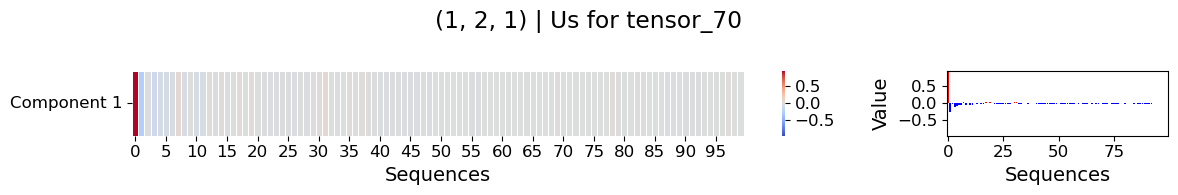

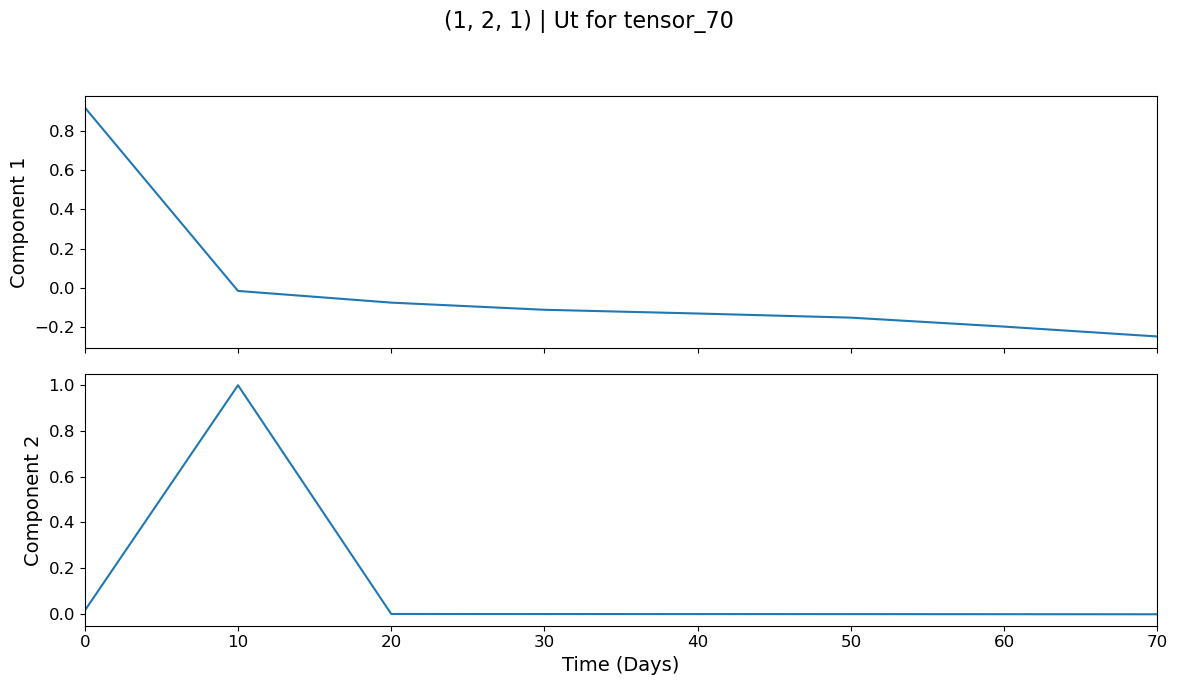

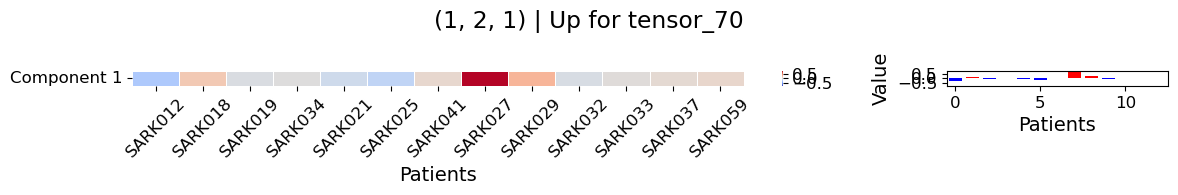

C:\Users\viola\AppData\Local\Temp\ipykernel_5844\603861461.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(core_tensor.iloc[:10, :], x="Index", y="Weight", hue="Sign", palette=["#2369BD", "#A9393C"], legend=False)


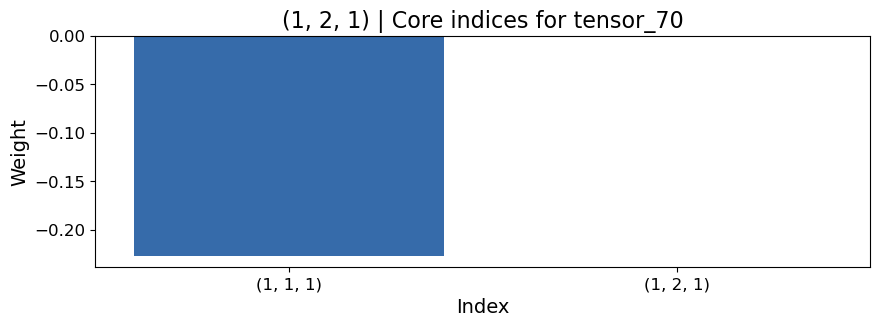


 Plotting cent_tensor_70 with ranks (4, 4, 7)


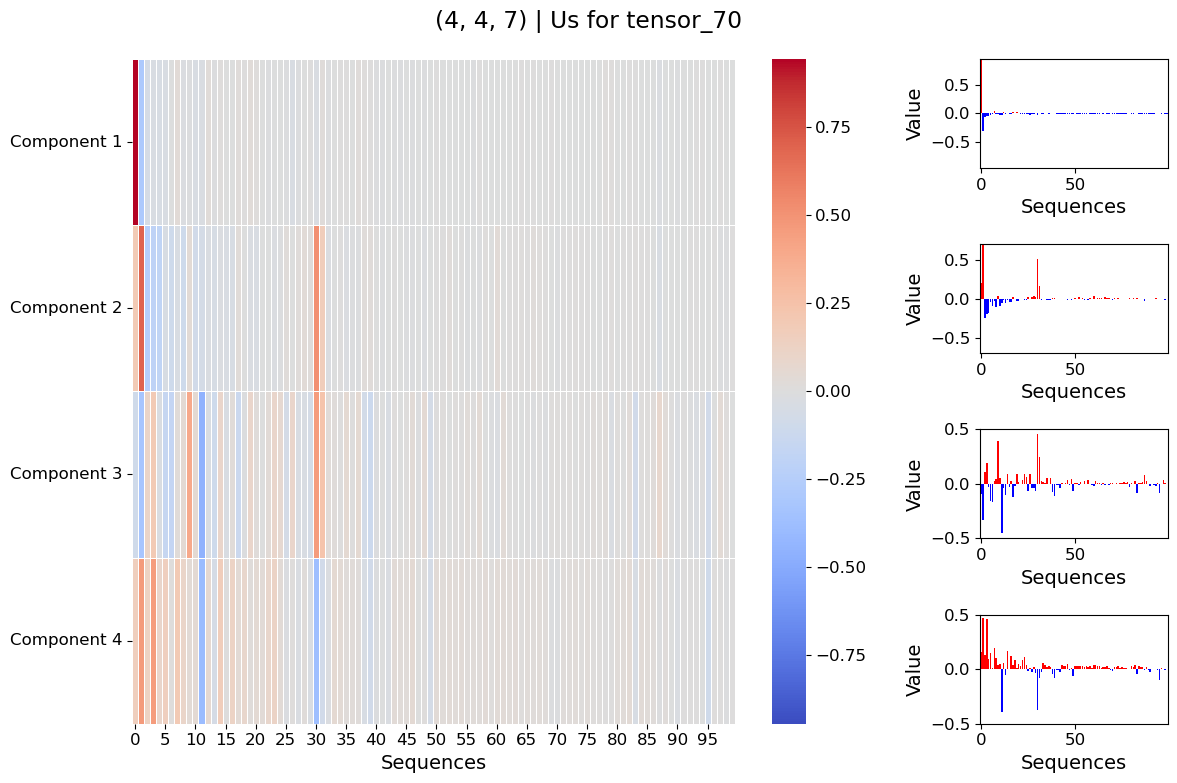

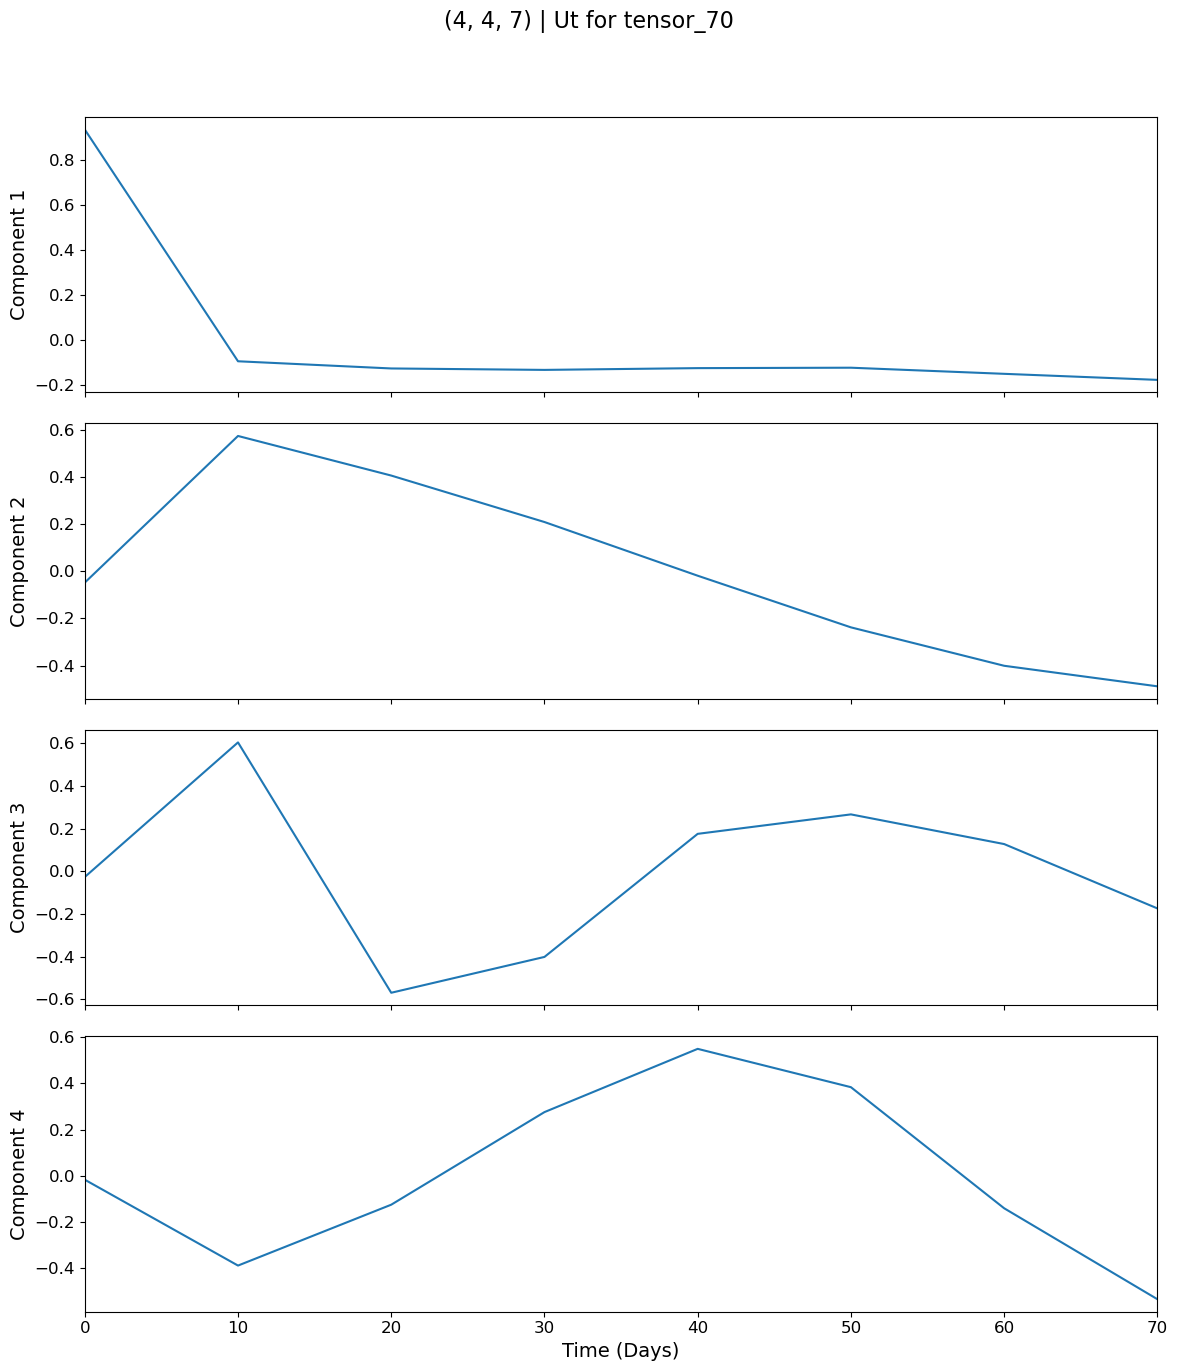

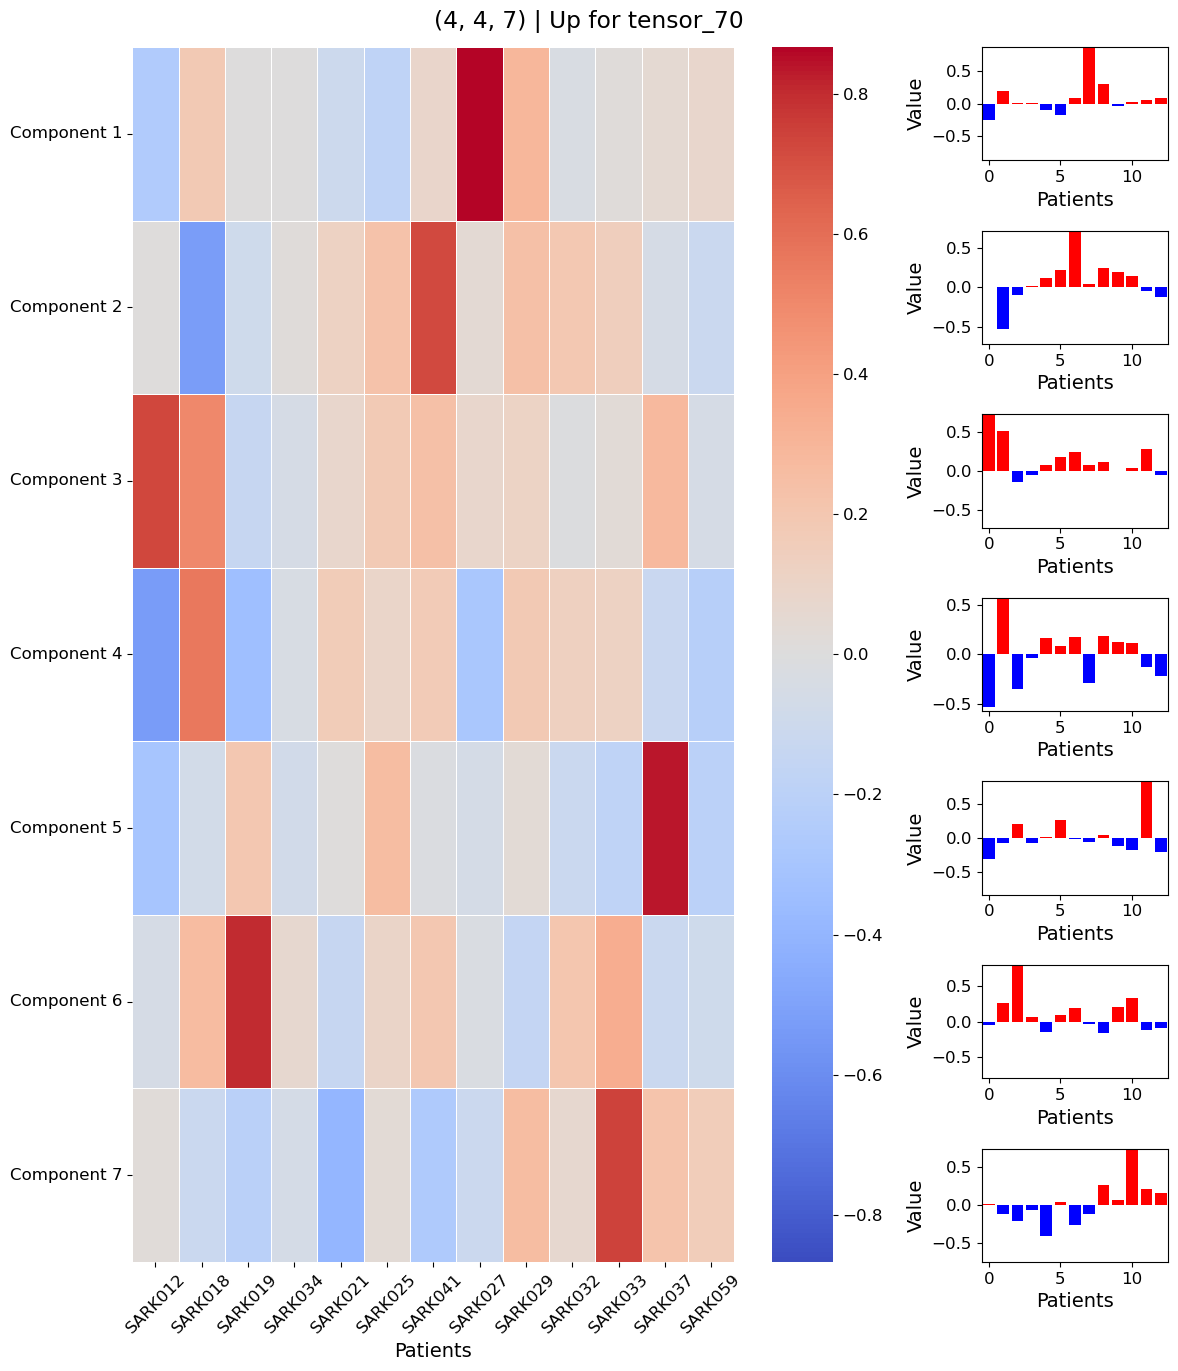

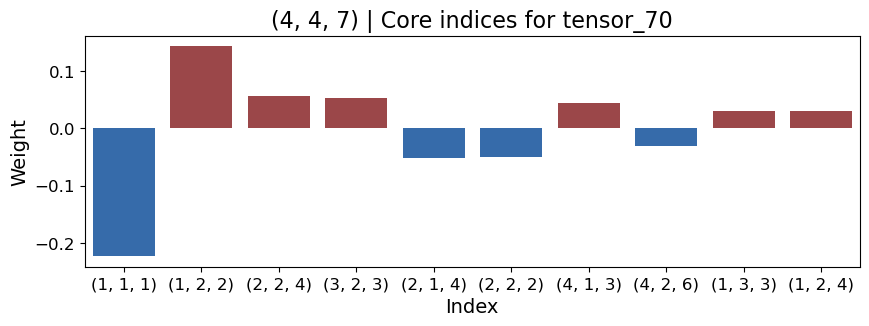


 Plotting cent_tensor_70 with ranks (5, 2, 5)


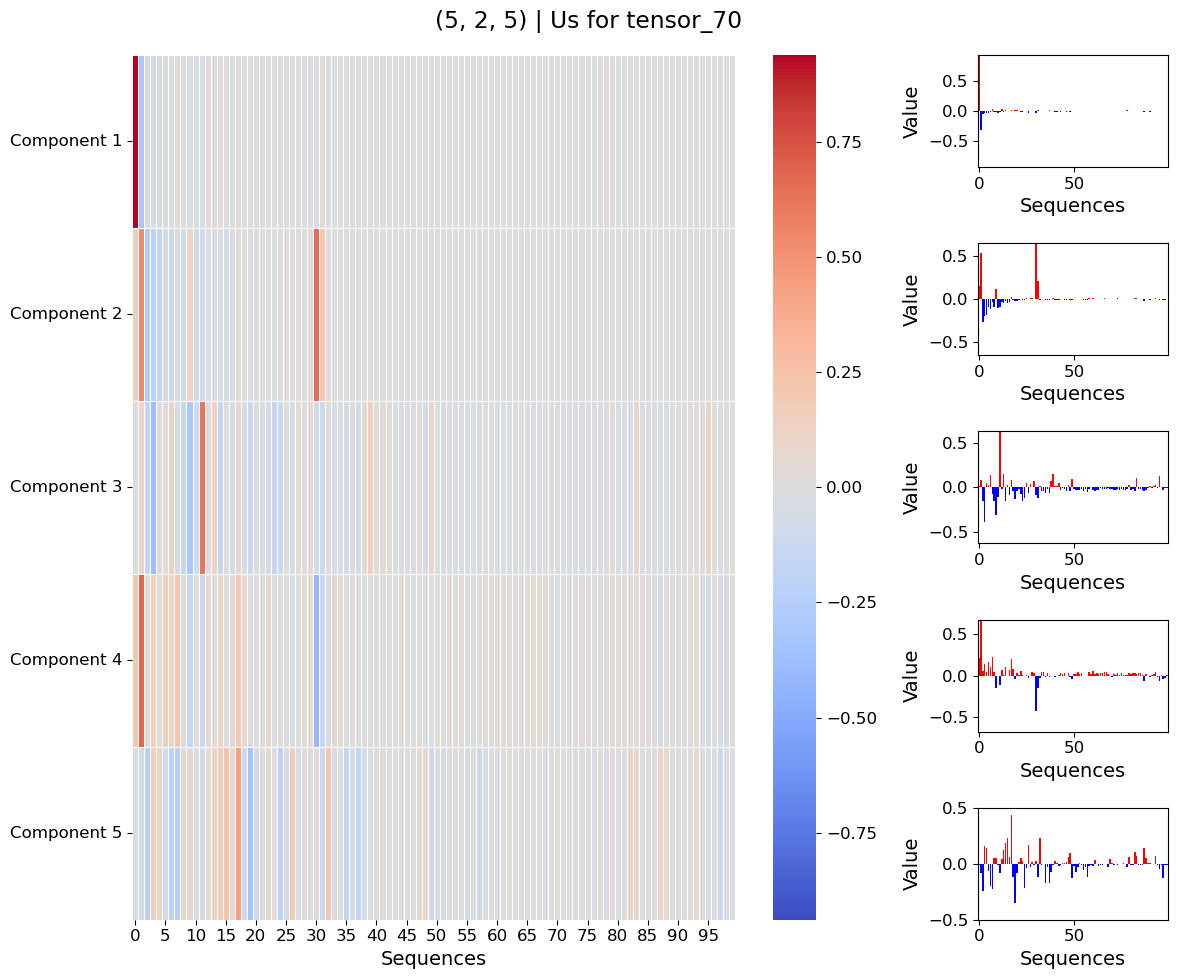

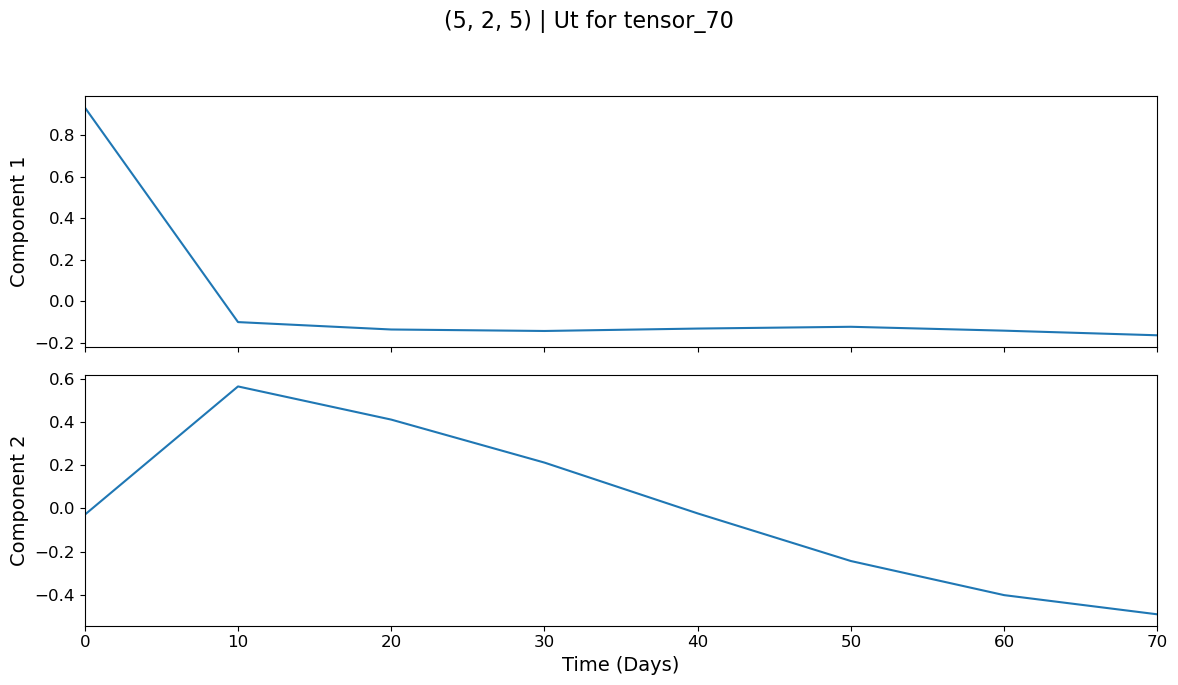

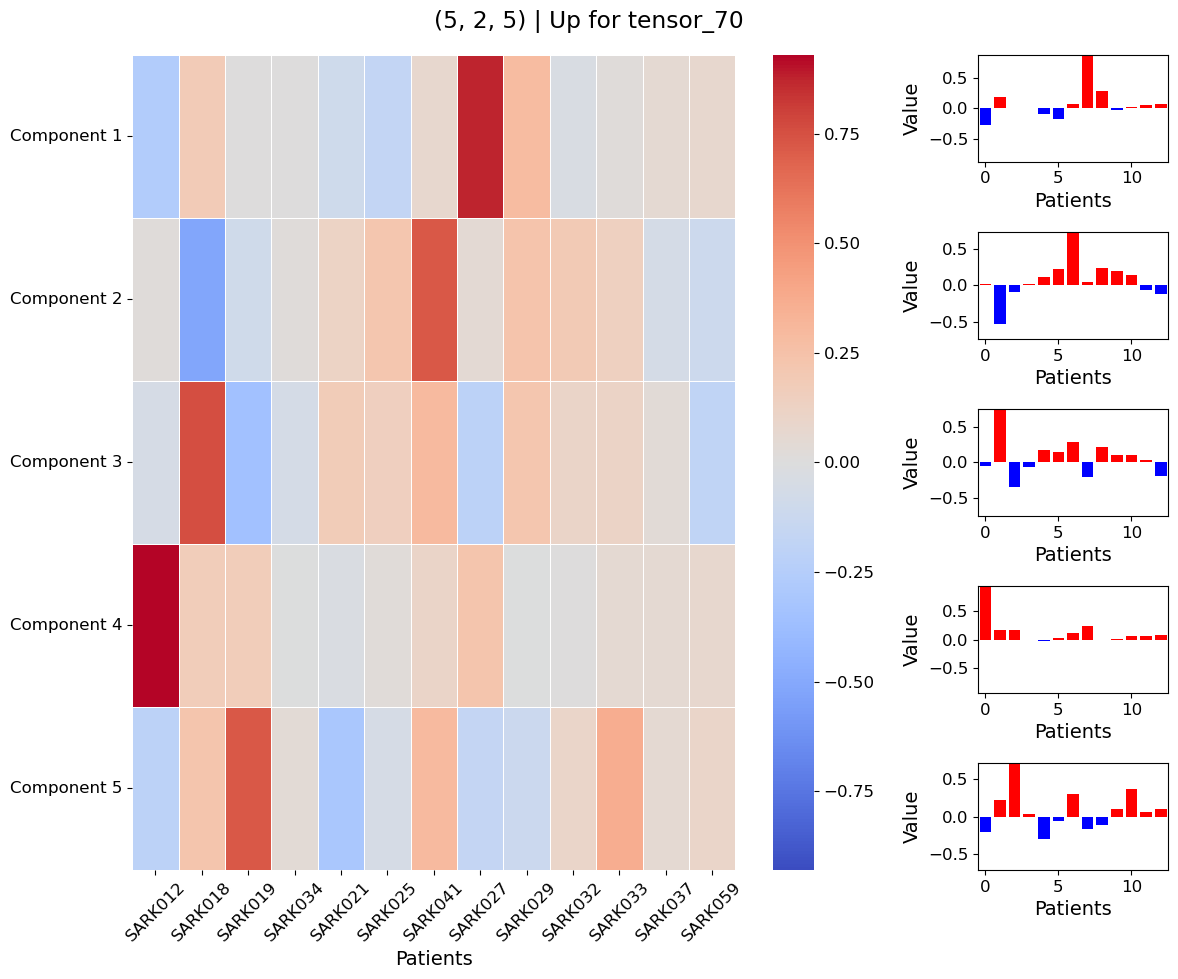

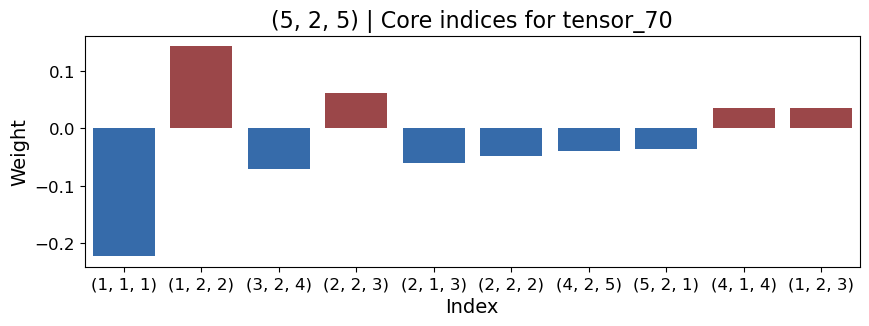


 Plotting cent_tensor_70 with ranks (15, 2, 5)


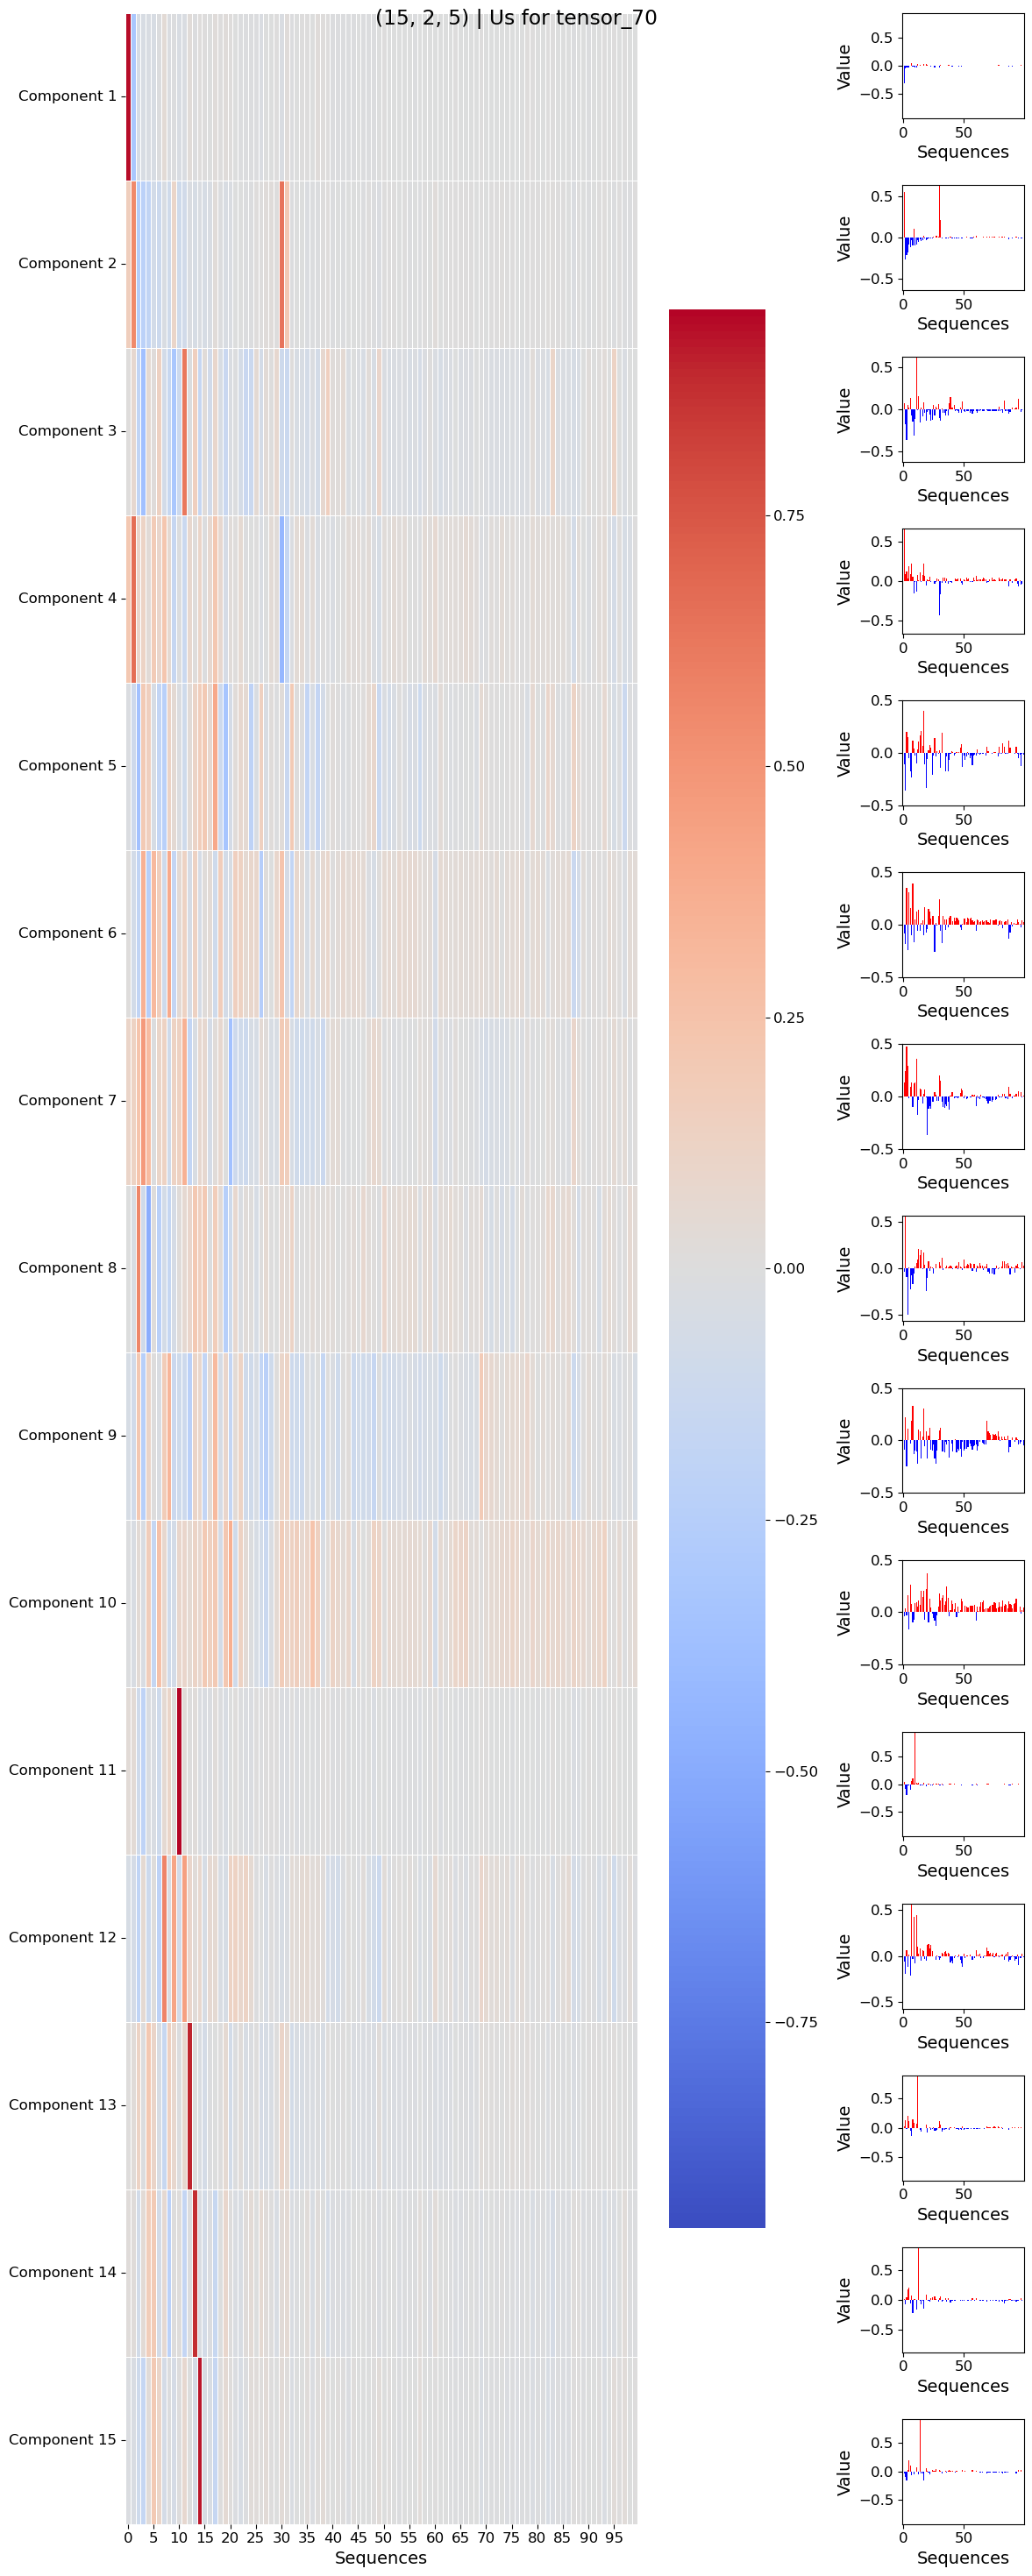

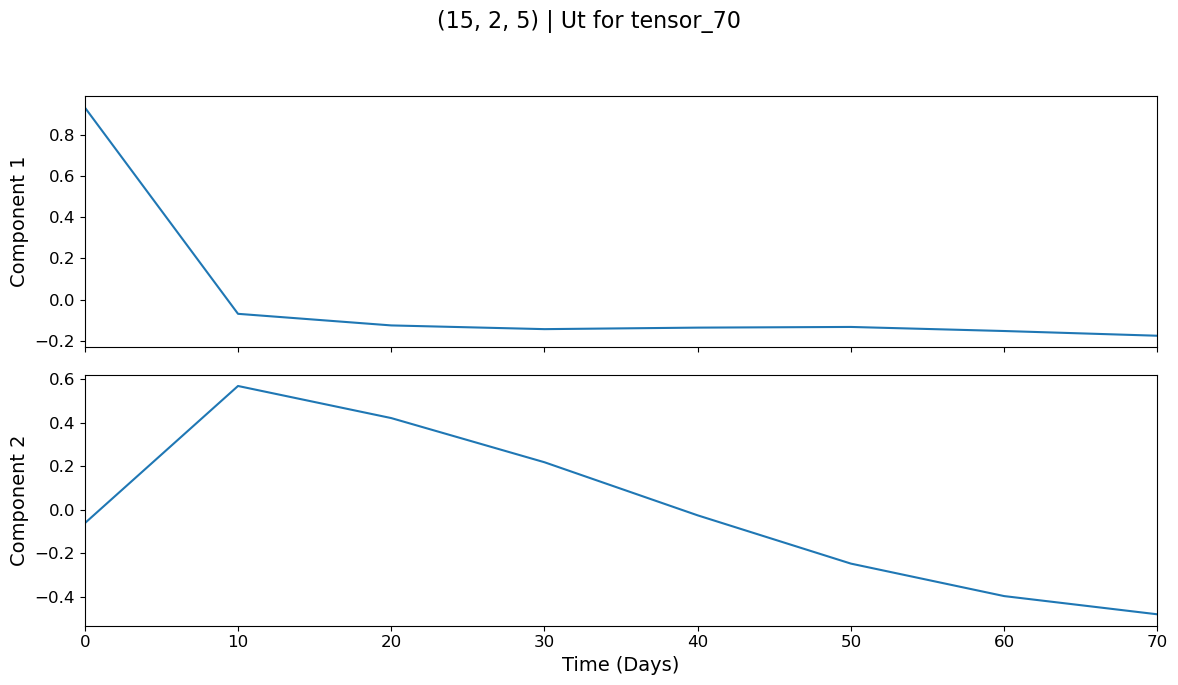

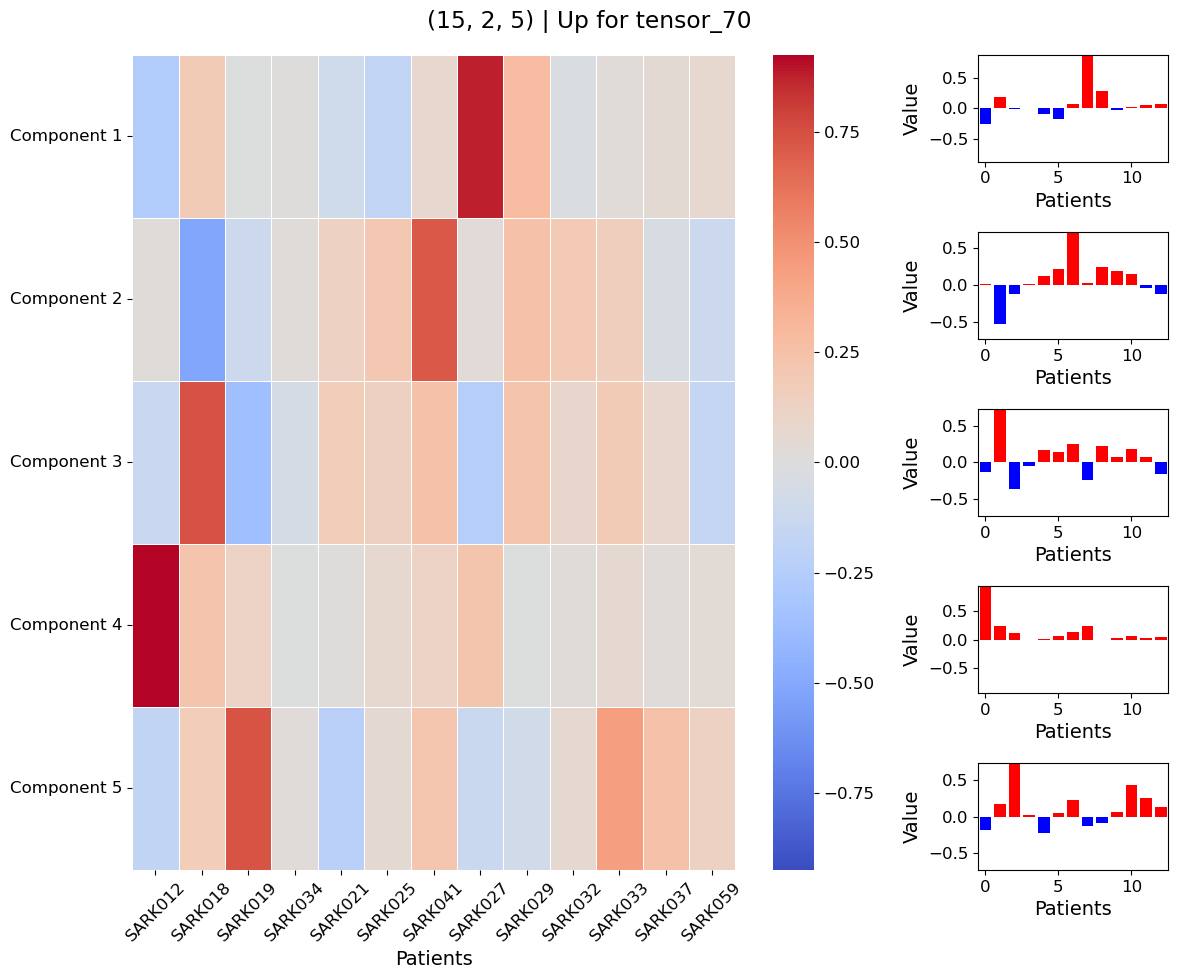

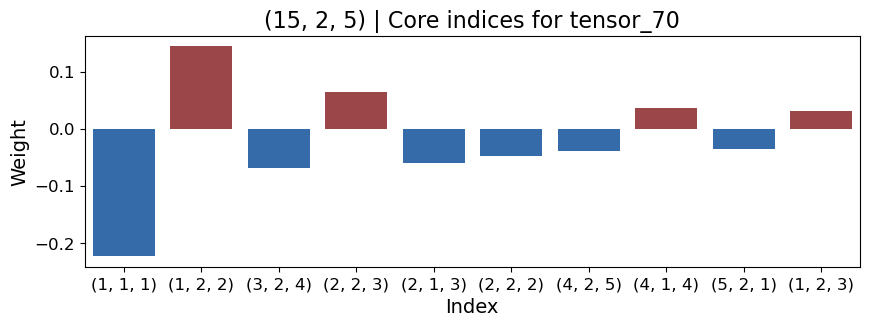


 Plotting cent_tensor_70 with ranks (8, 3, 7)


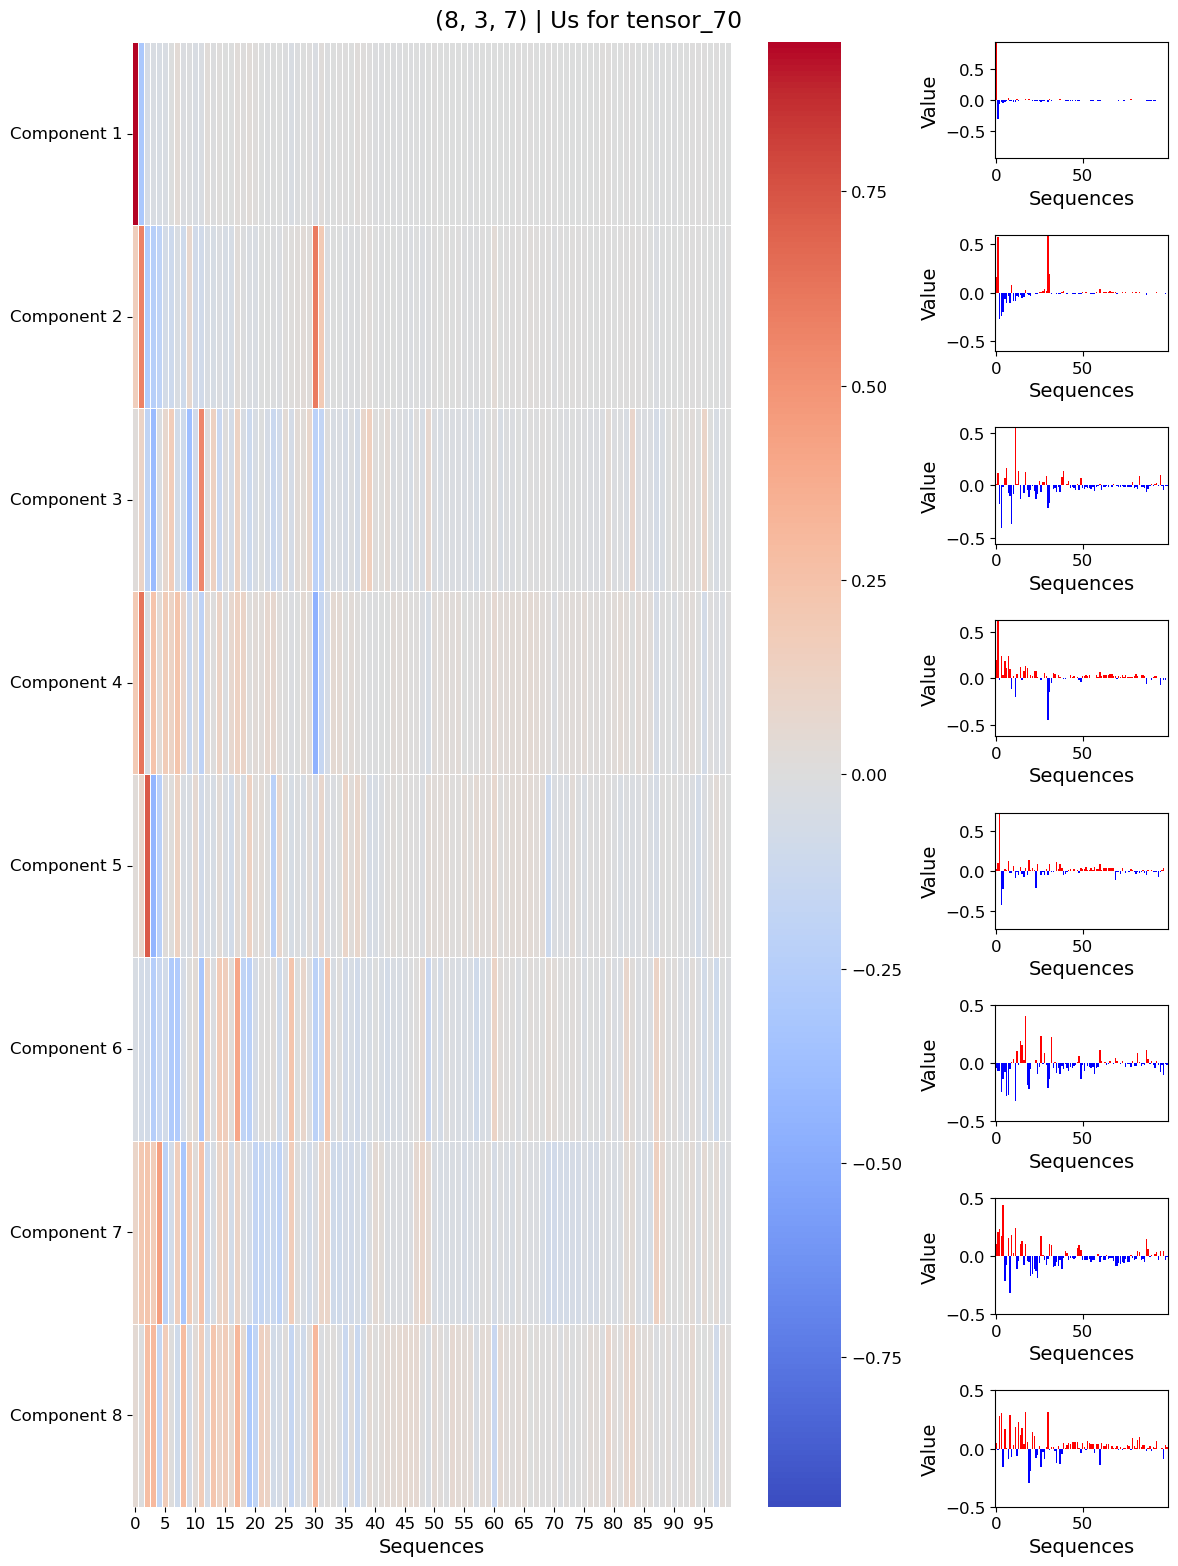

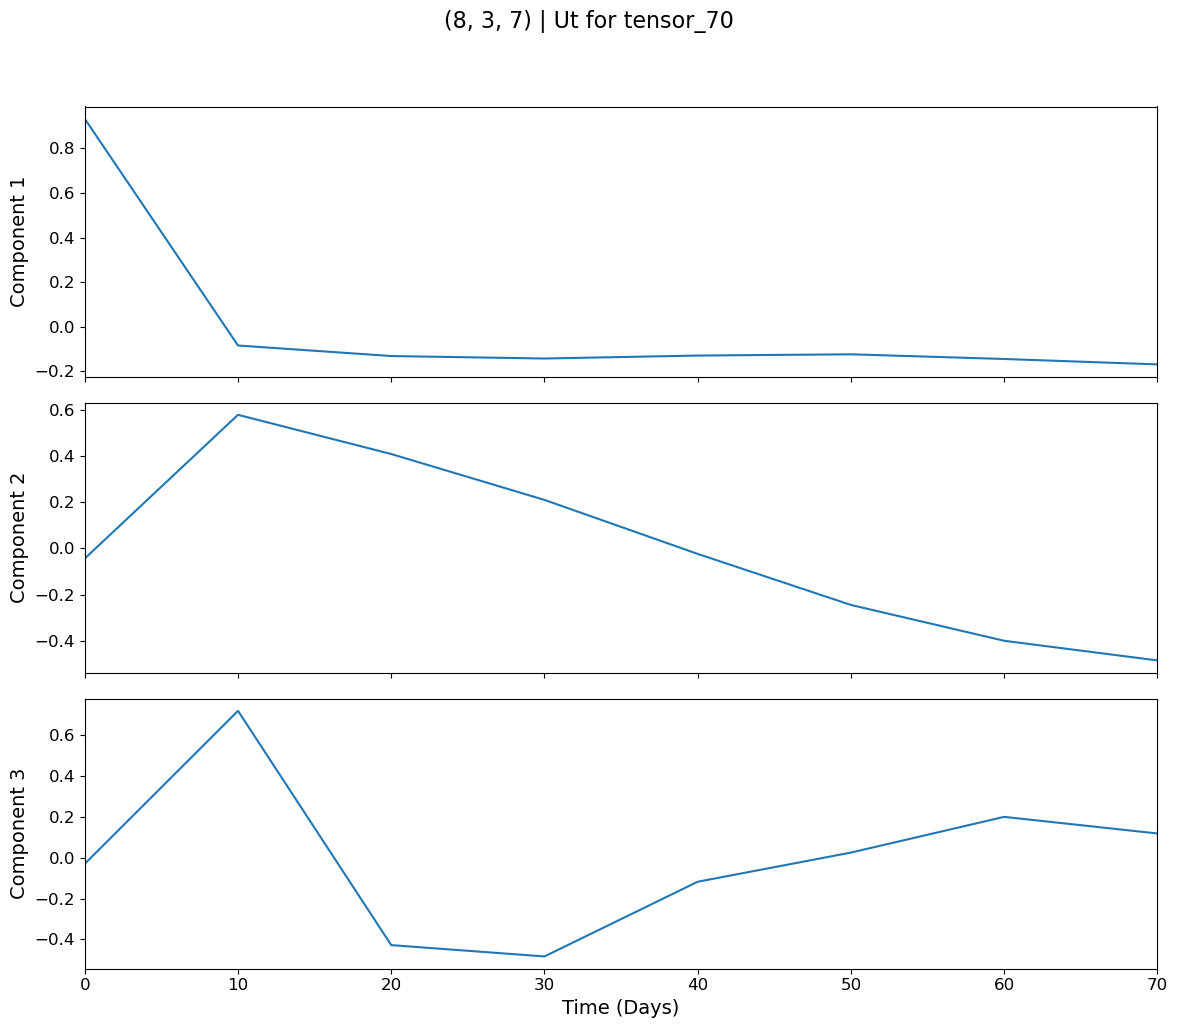

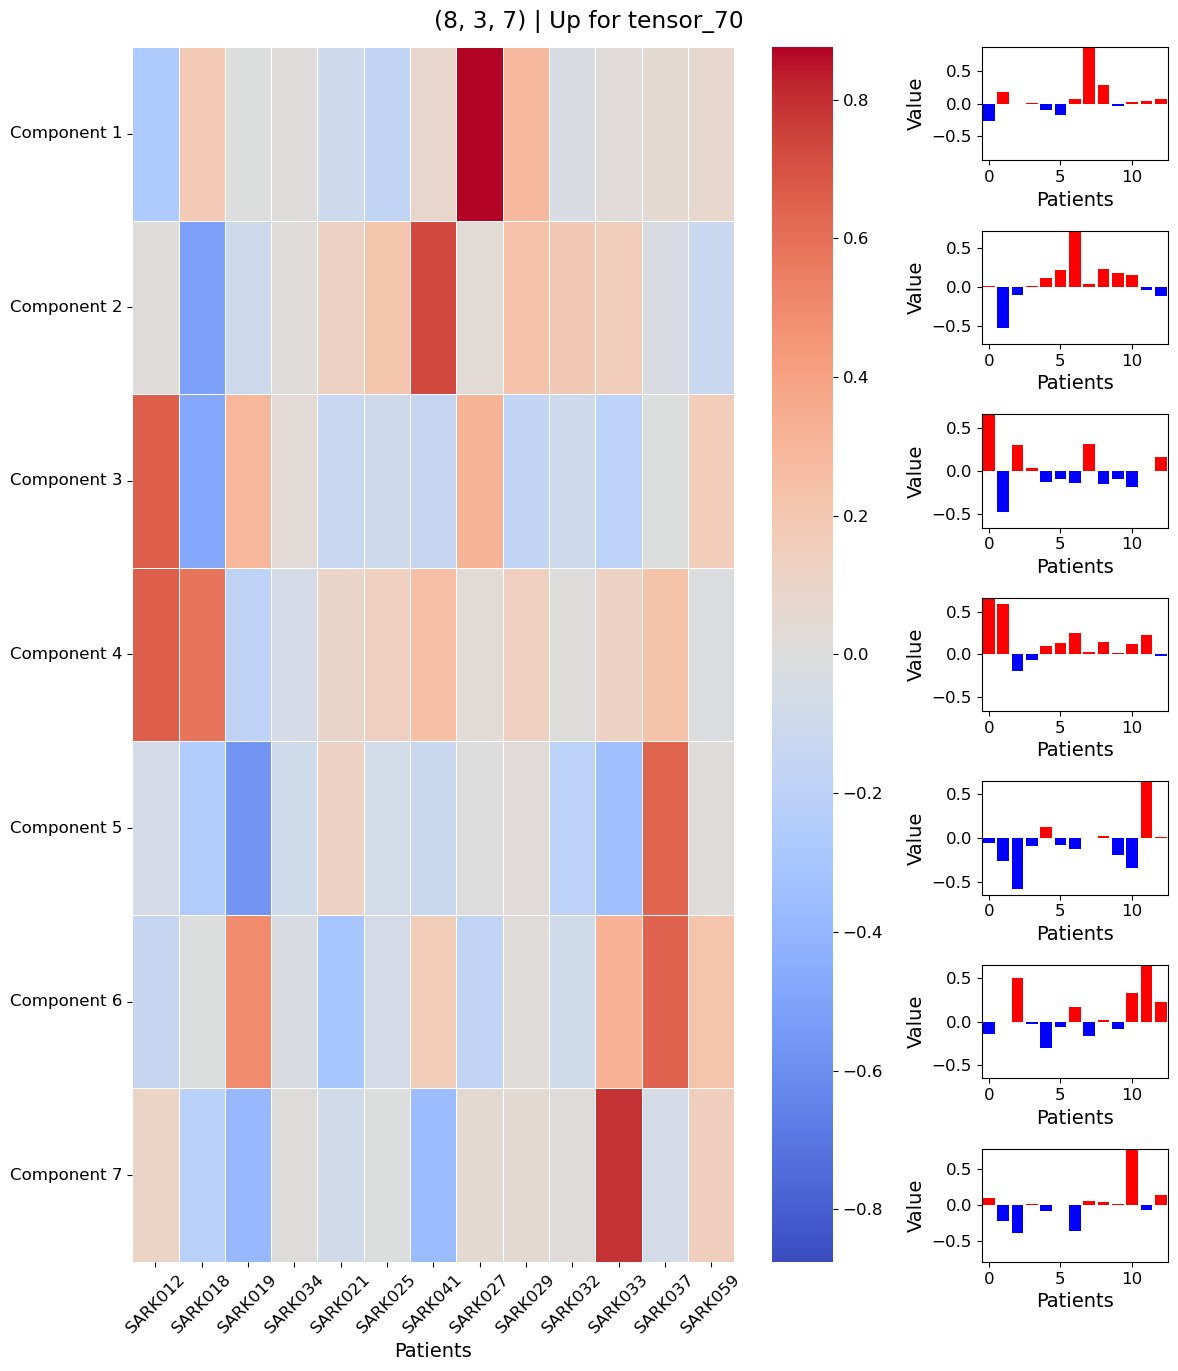

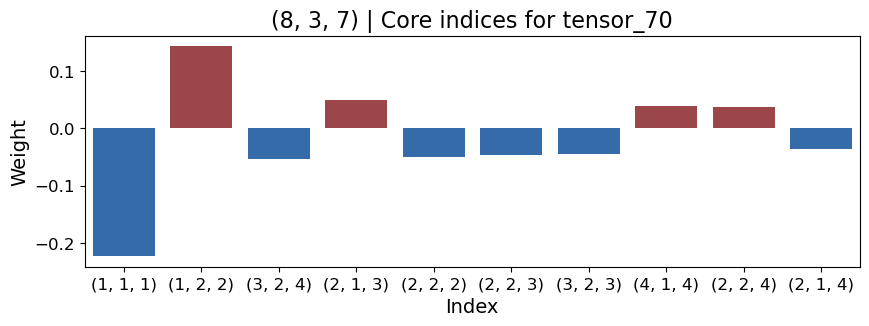

In [21]:
tensor_name = "tensor_70"
type_name = "cent" 

# Patient list for tensor_70
pat_list = [
    'SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
    'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']

plot_all_rank_decompositions(tensor_name, type_name, tucker_results, pat_list)

## tensor_100


 Checking decompositions for: cent_tensor_100
   Found rank (2, 2, 3)
   Found rank (5, 4, 6)
   Found rank (5, 3, 5)
   Found rank (15, 3, 5)
   Found rank (8, 4, 6)

 Plotting cent_tensor_100 with ranks (2, 2, 3)


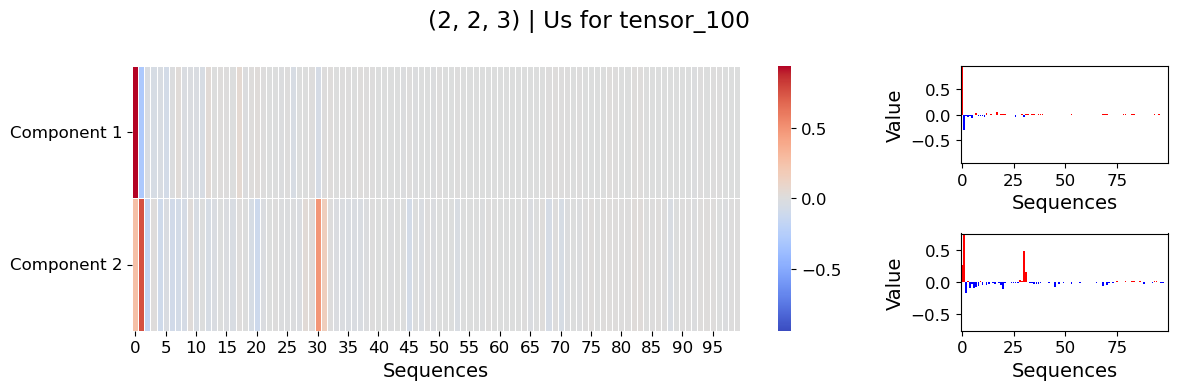

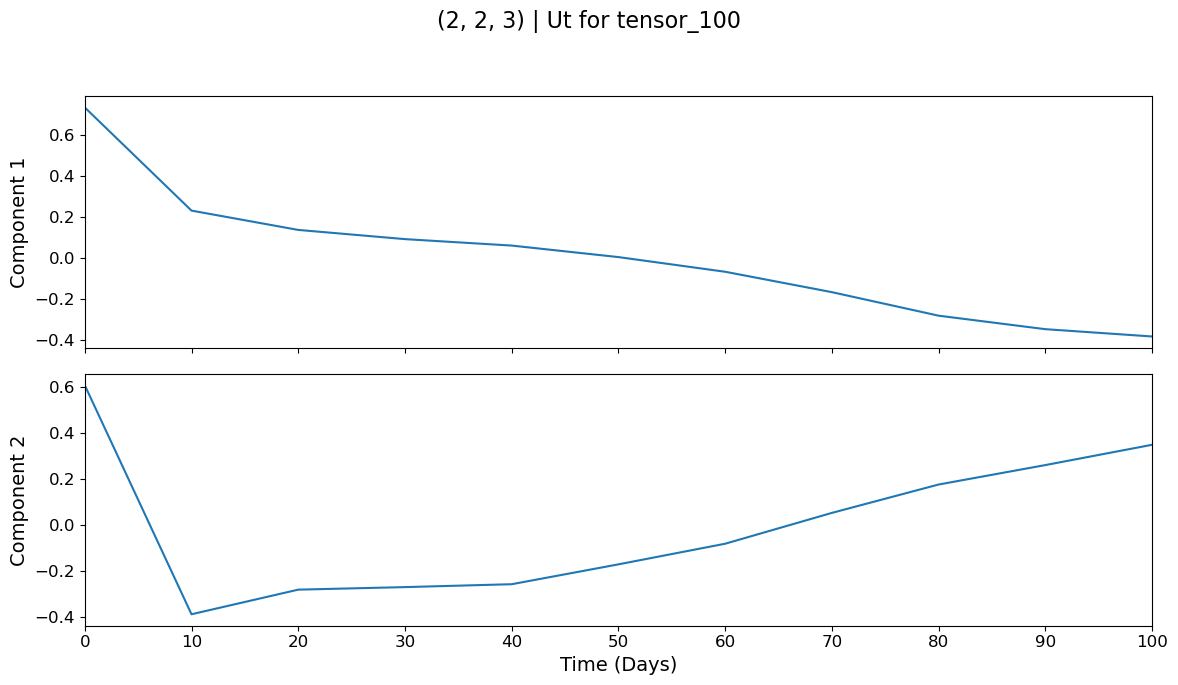

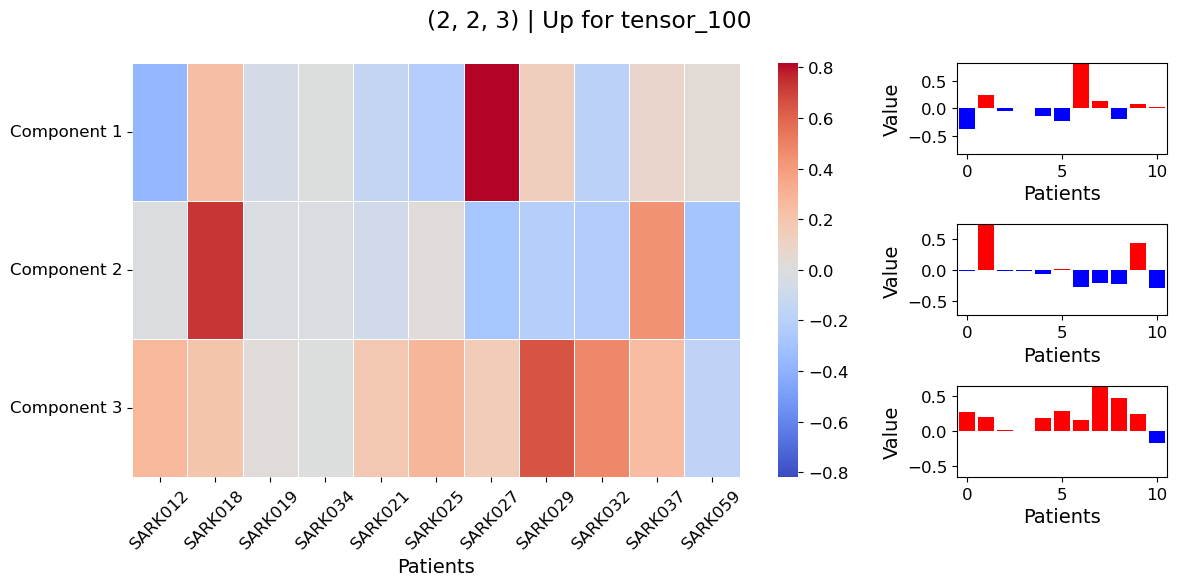

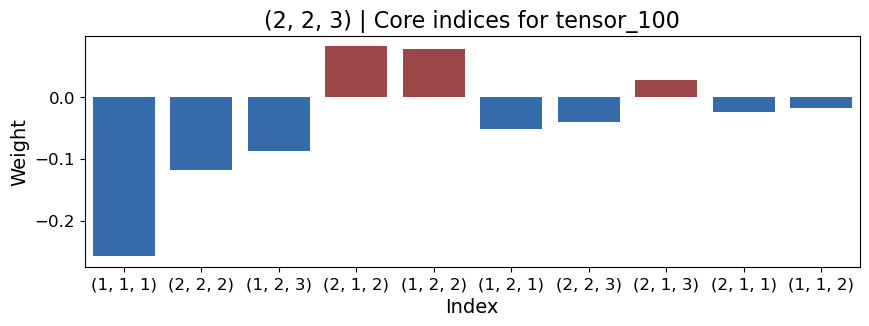


 Plotting cent_tensor_100 with ranks (5, 4, 6)


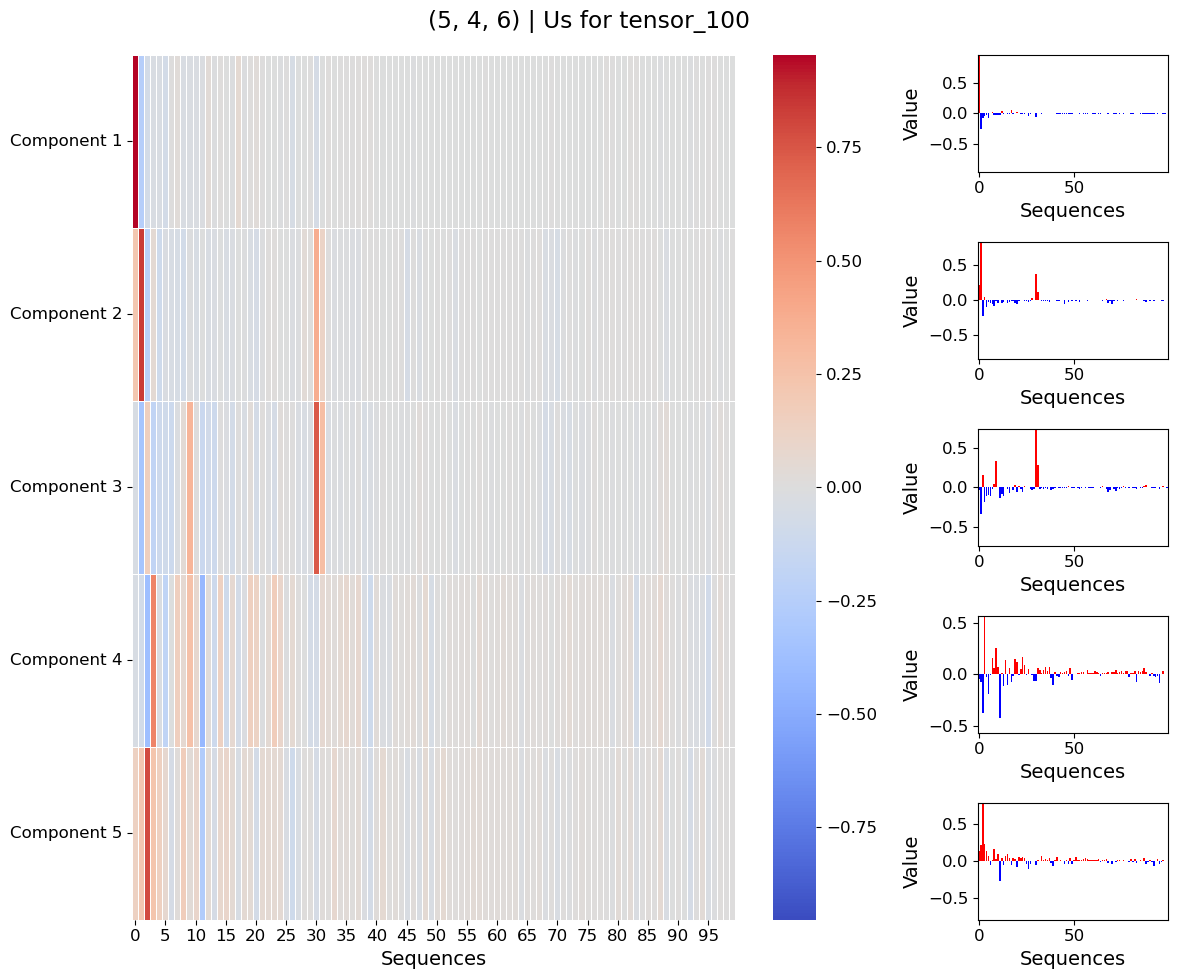

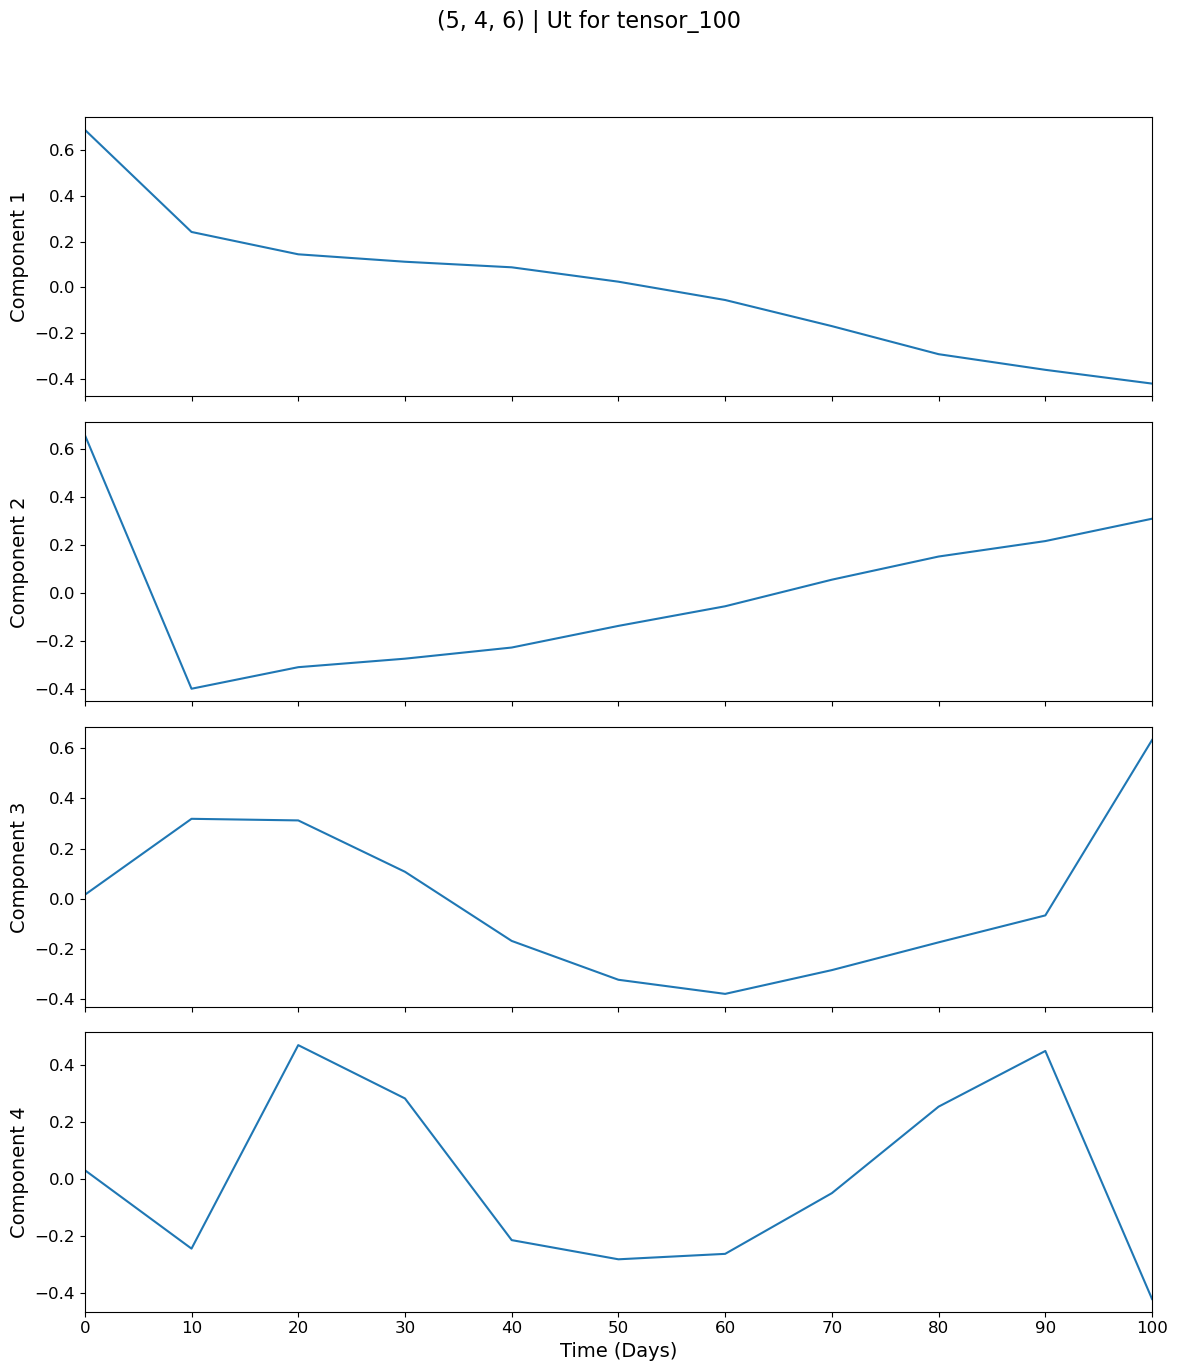

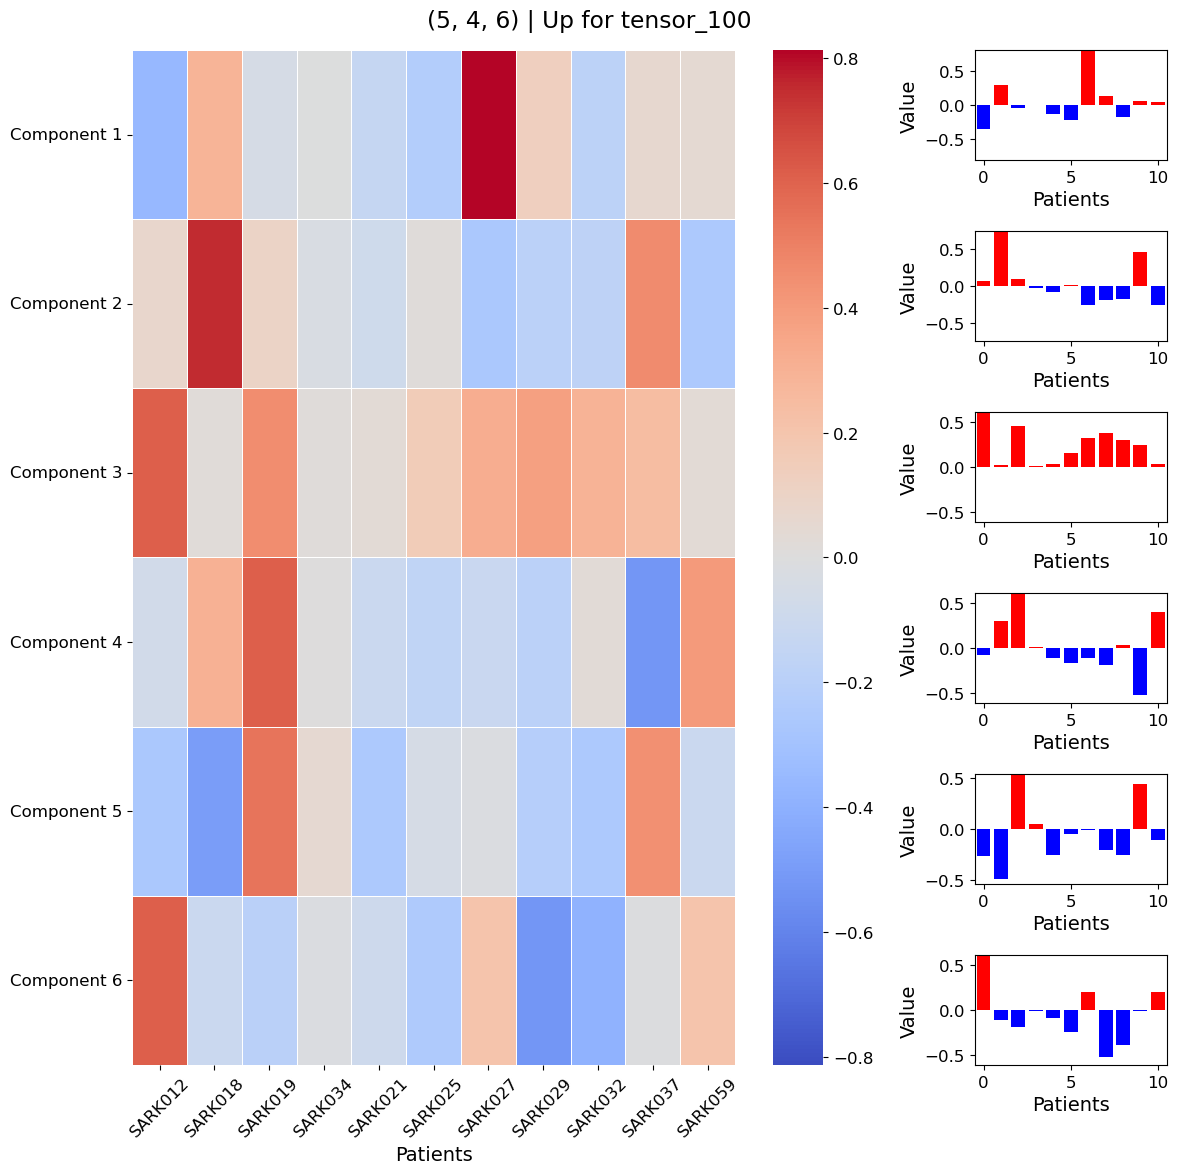

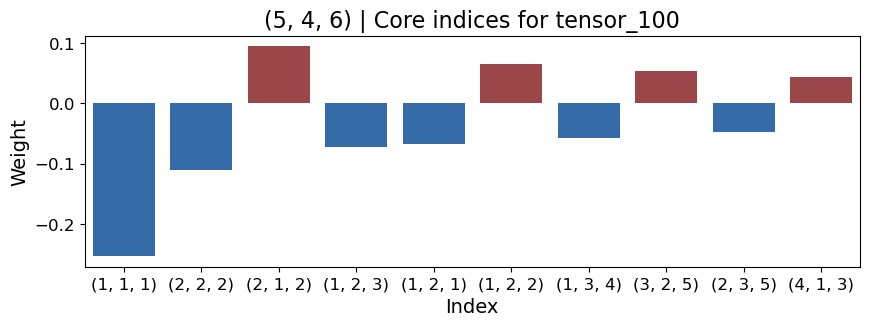


 Plotting cent_tensor_100 with ranks (5, 3, 5)


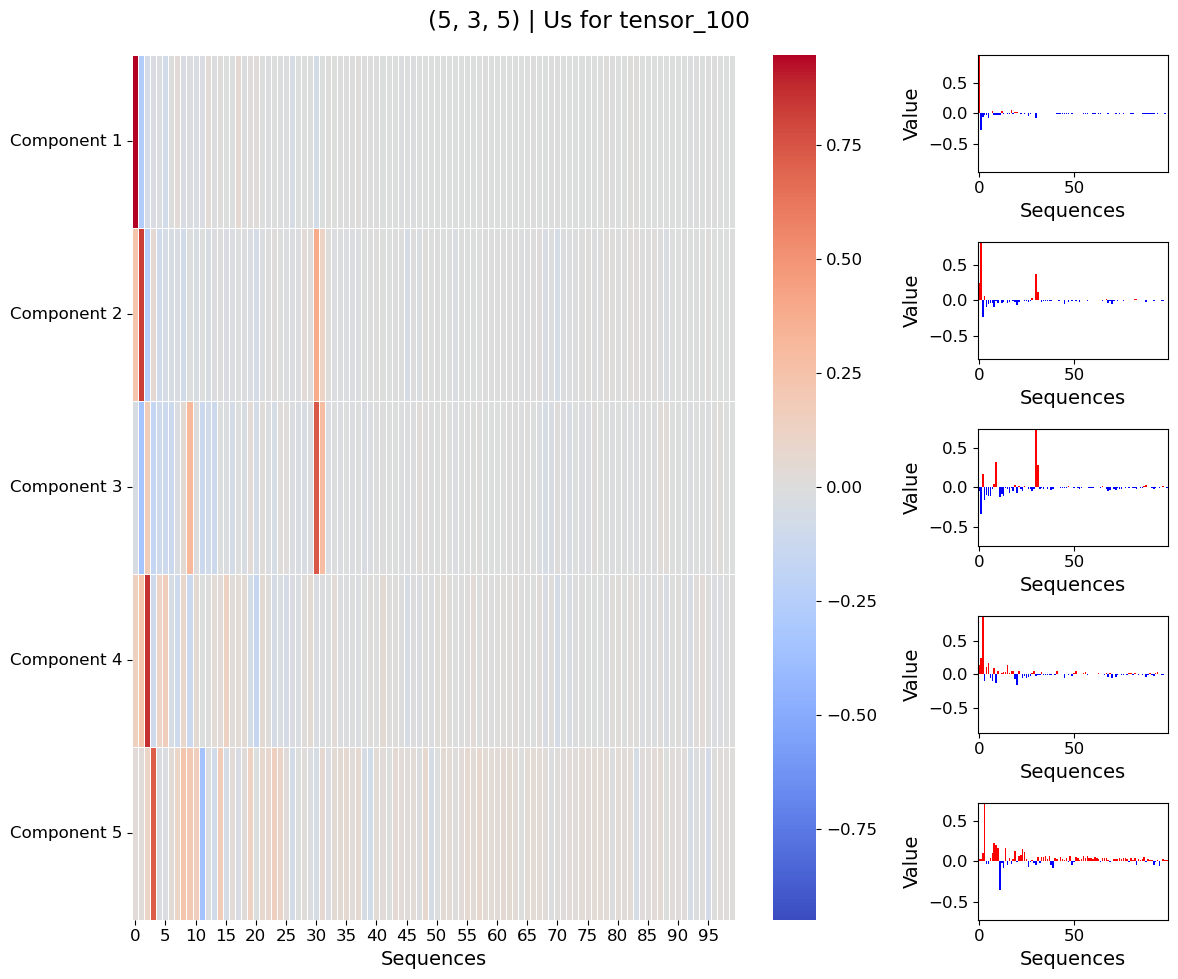

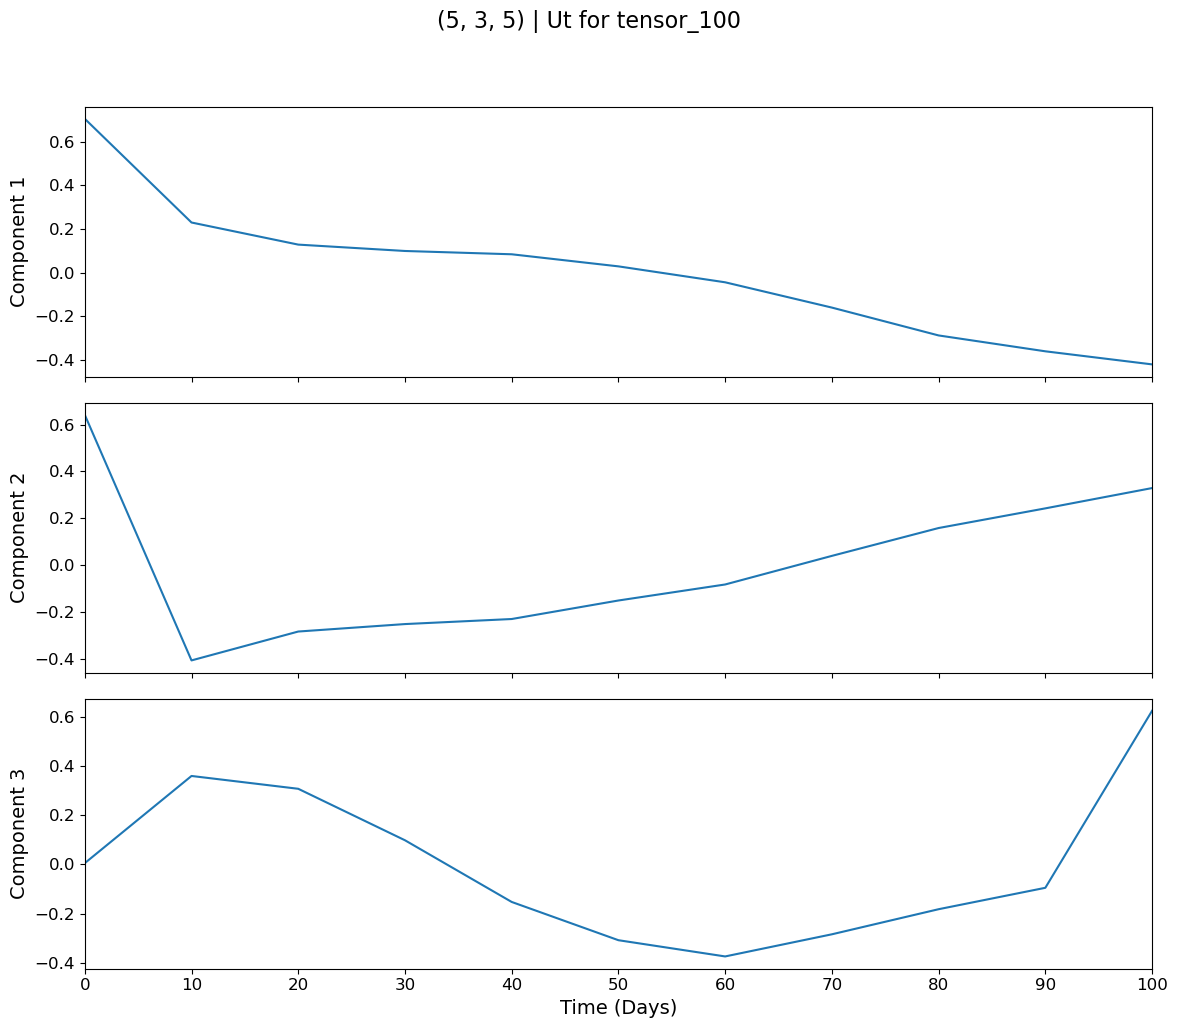

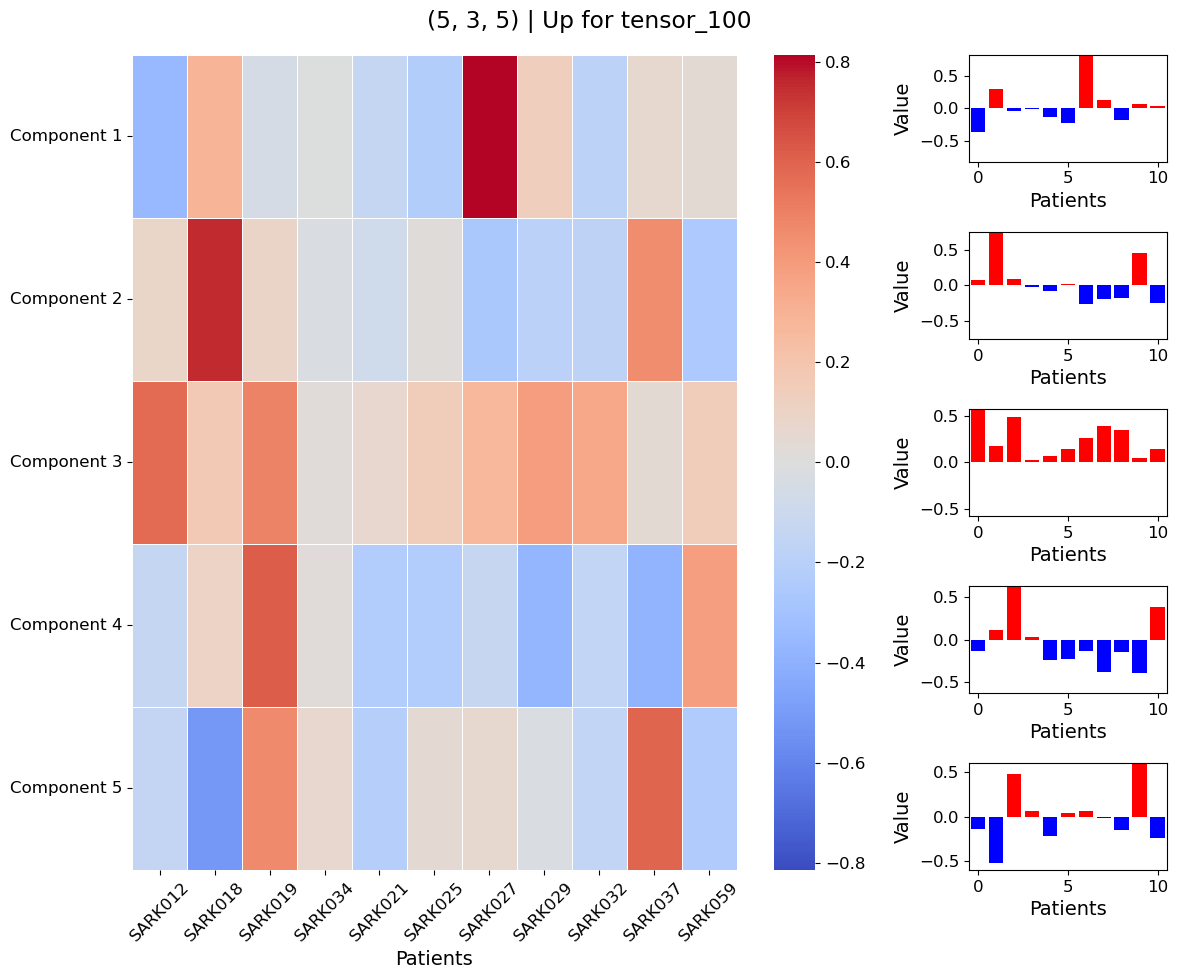

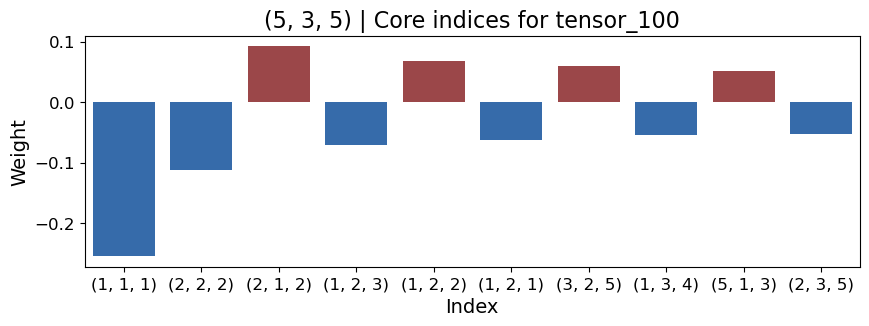


 Plotting cent_tensor_100 with ranks (15, 3, 5)


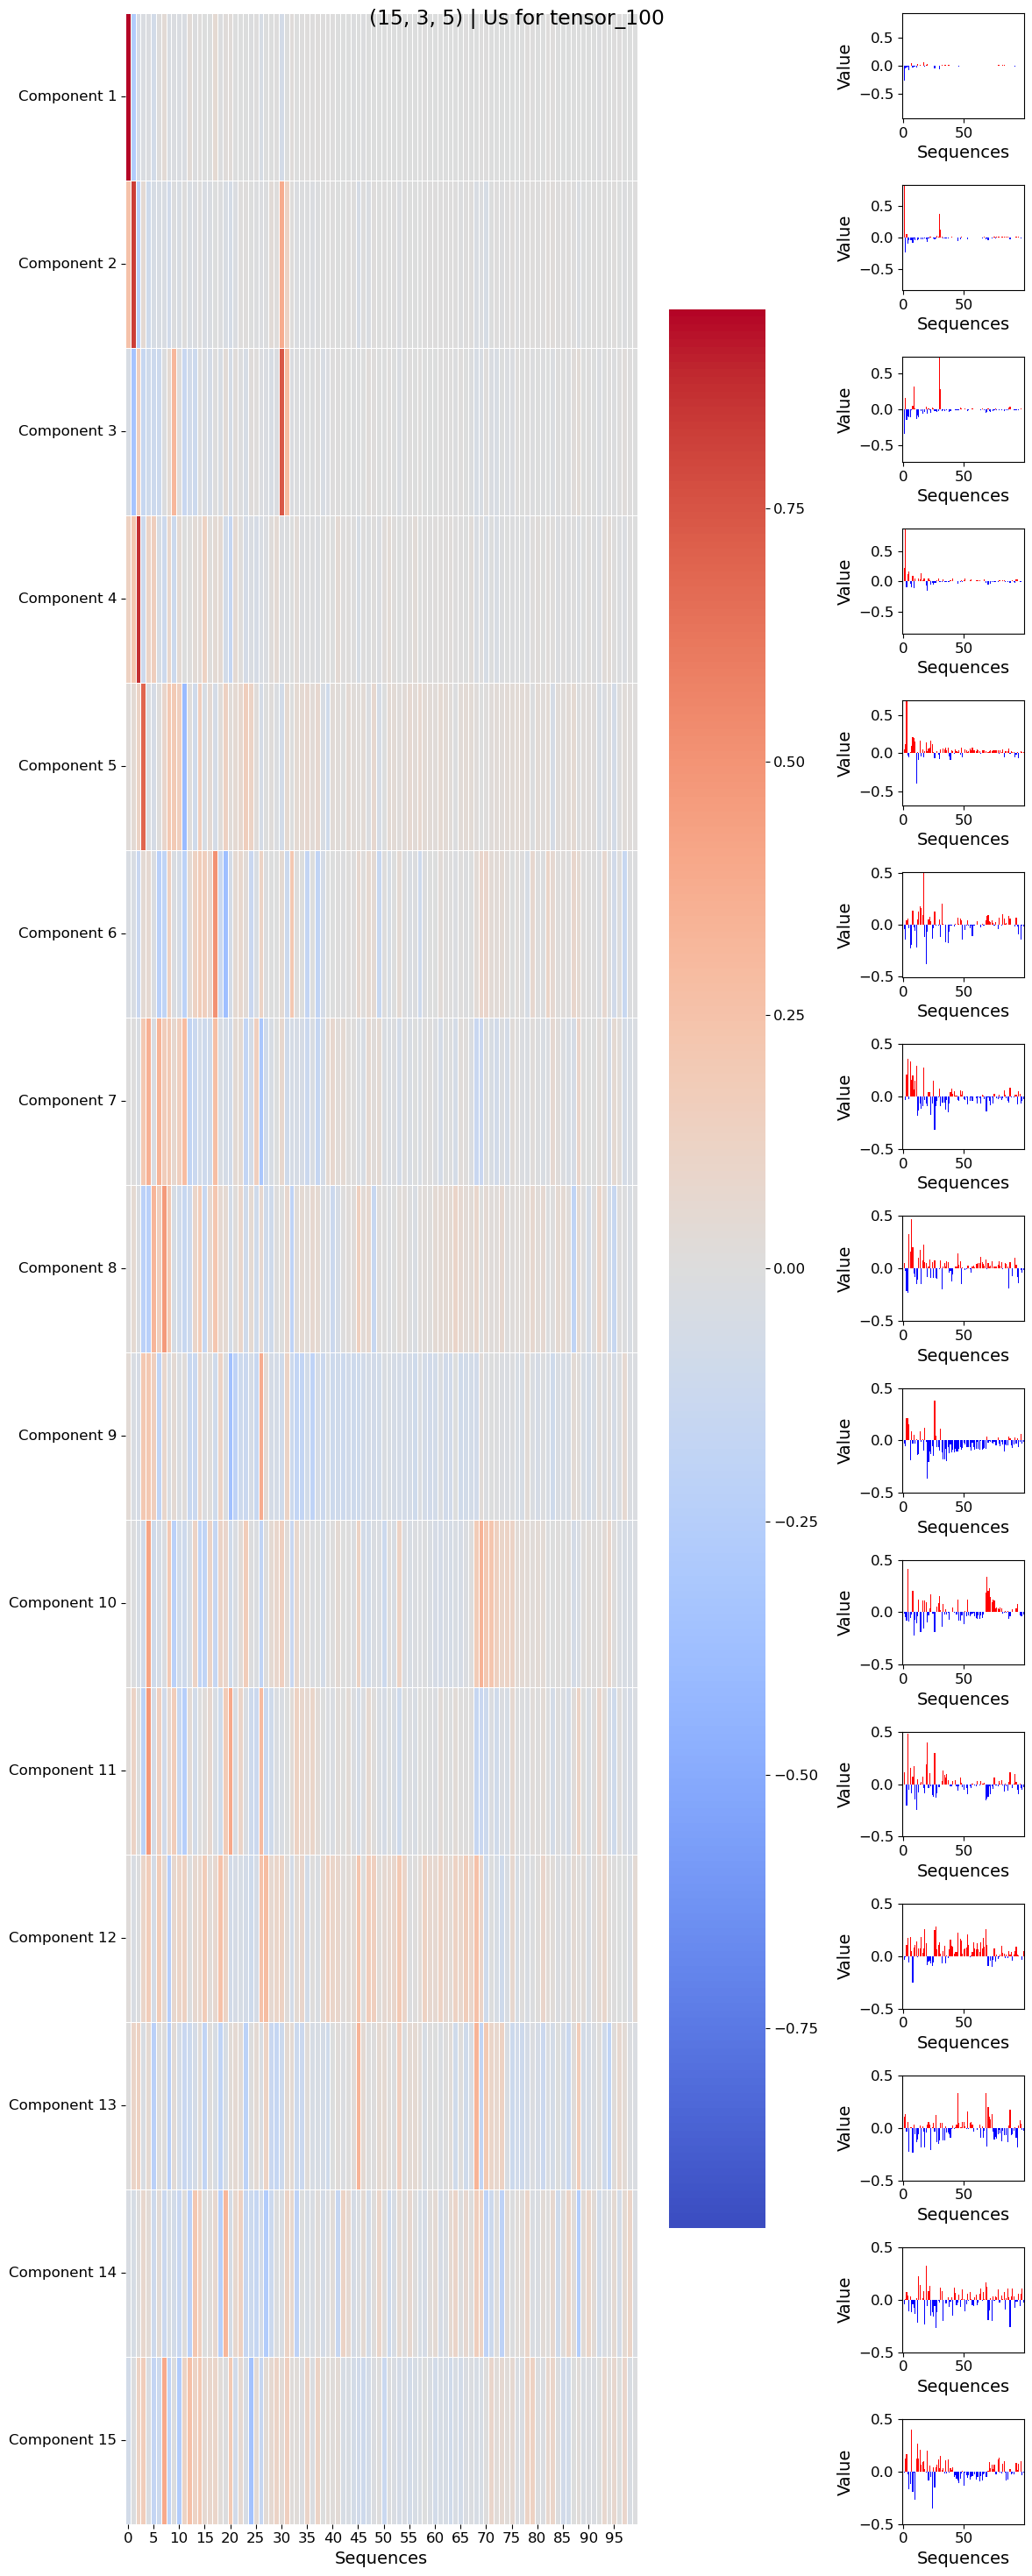

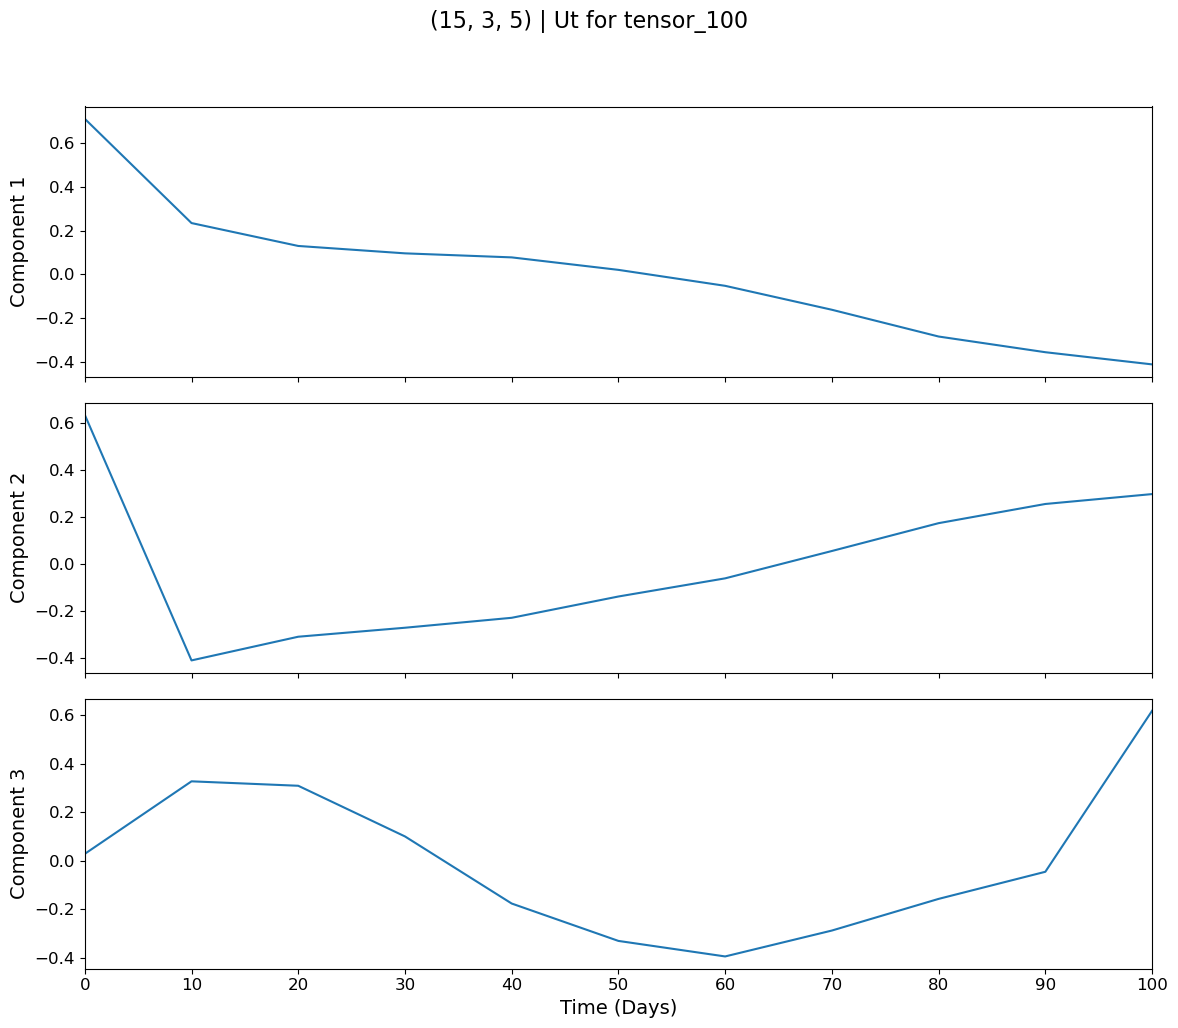

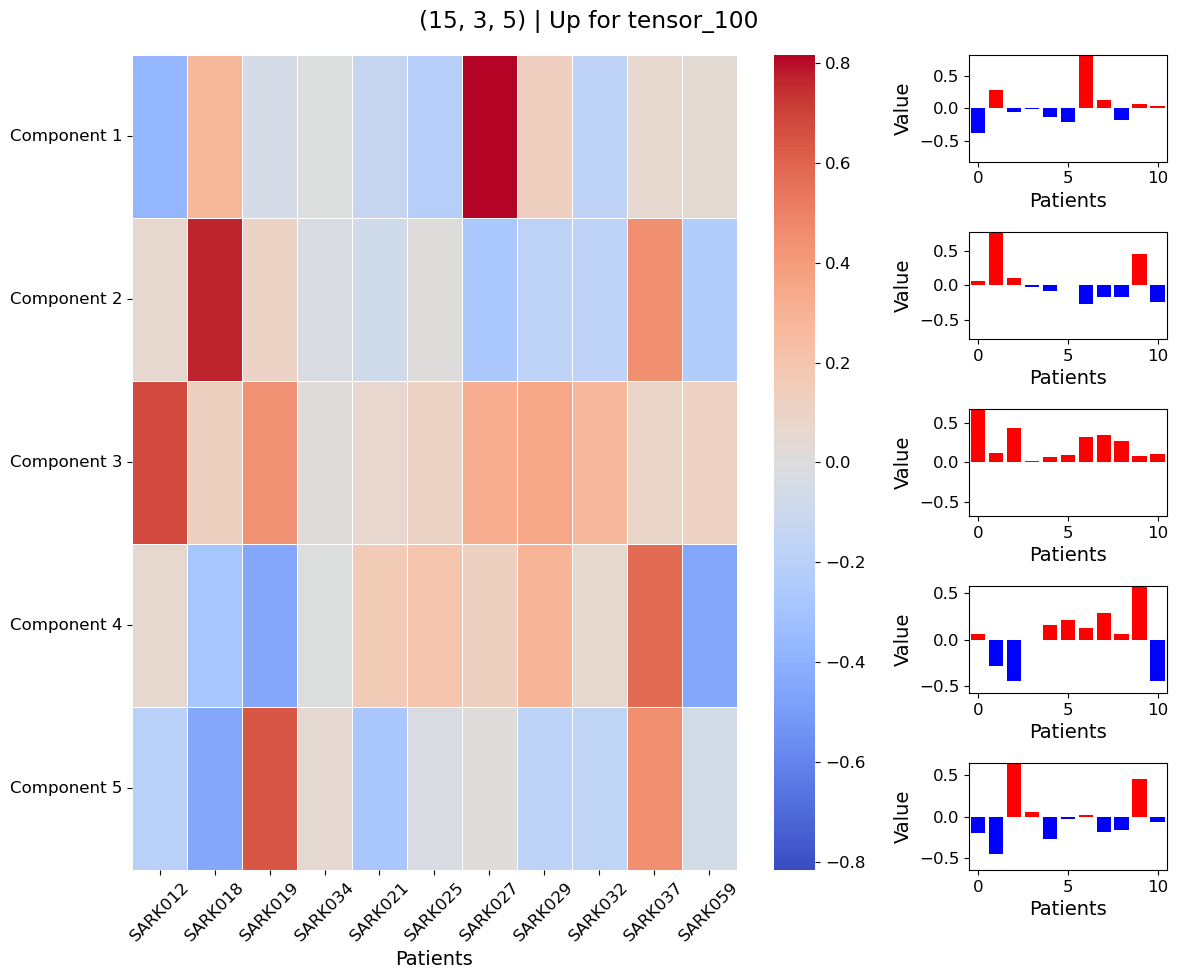

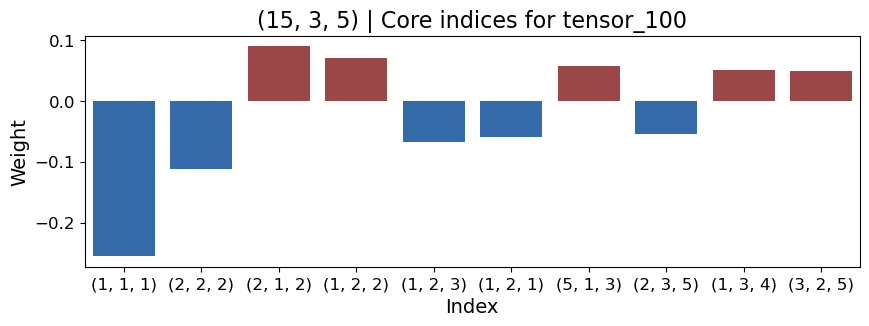


 Plotting cent_tensor_100 with ranks (8, 4, 6)


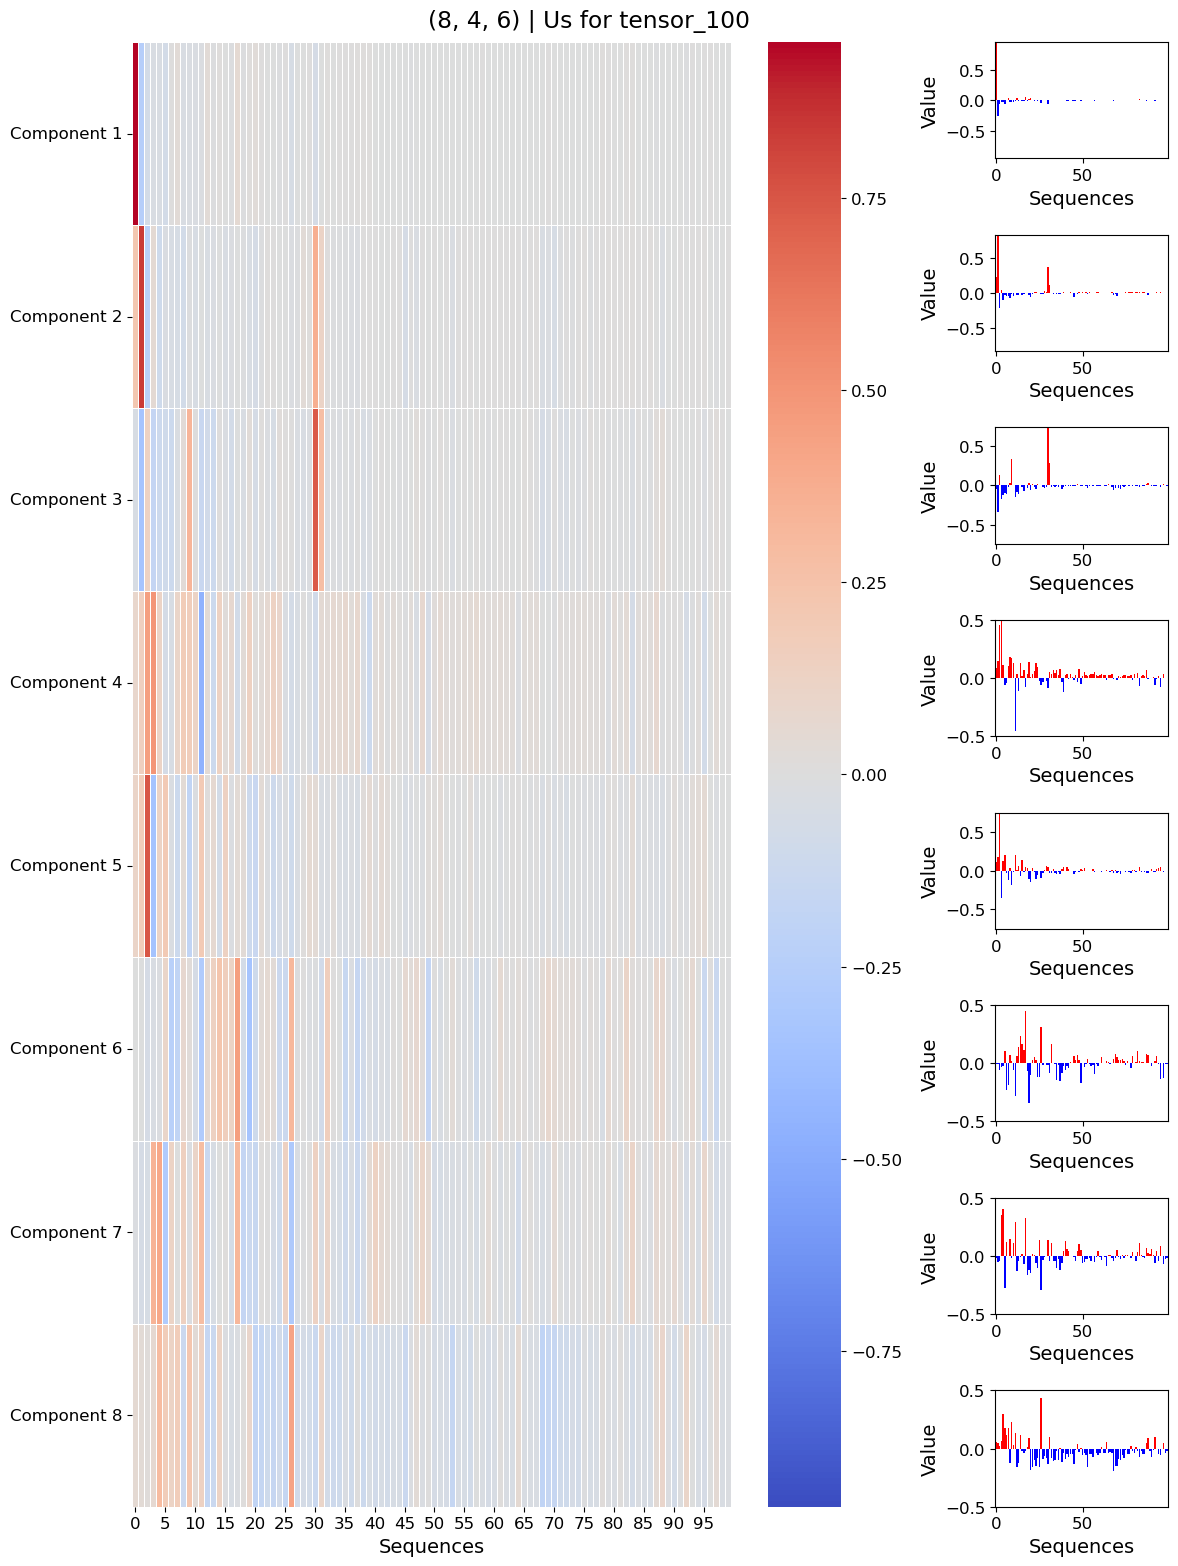

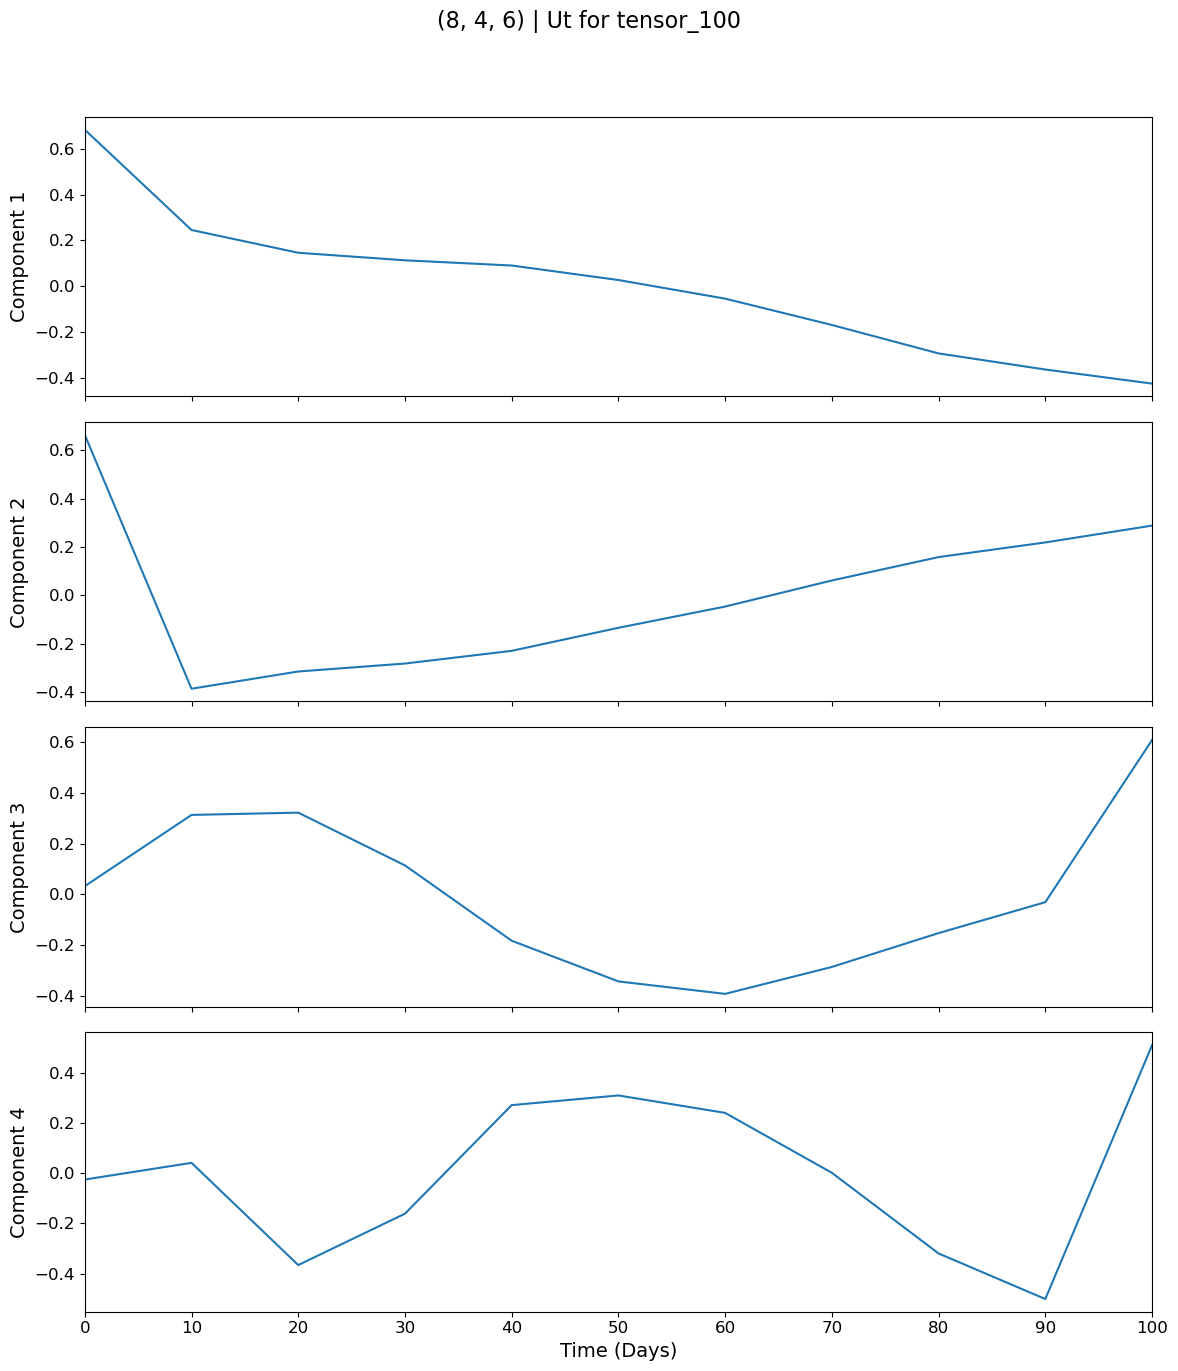

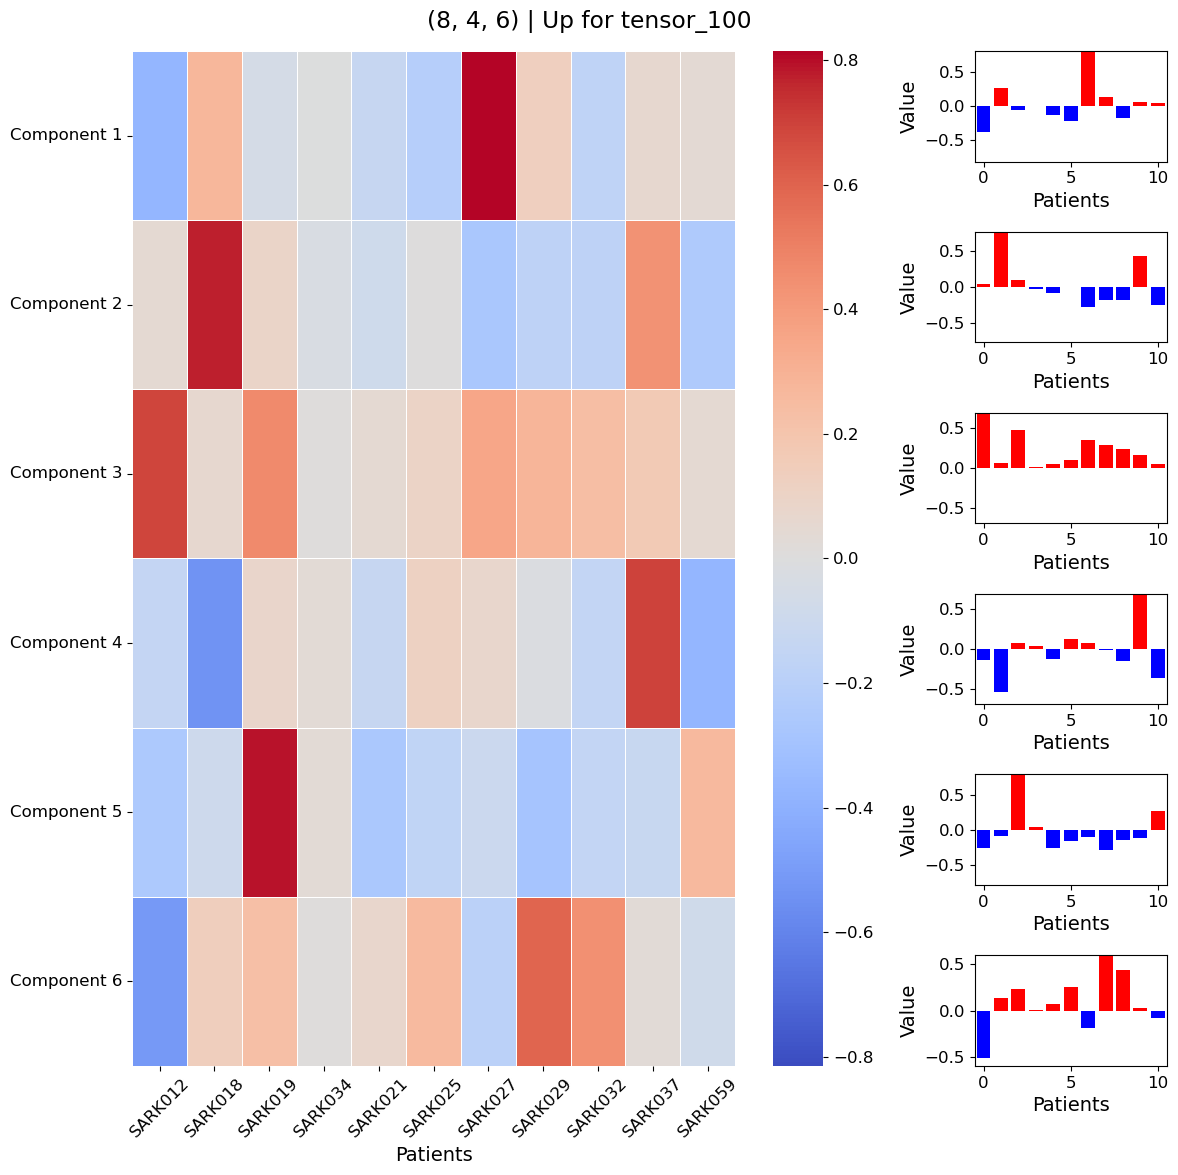

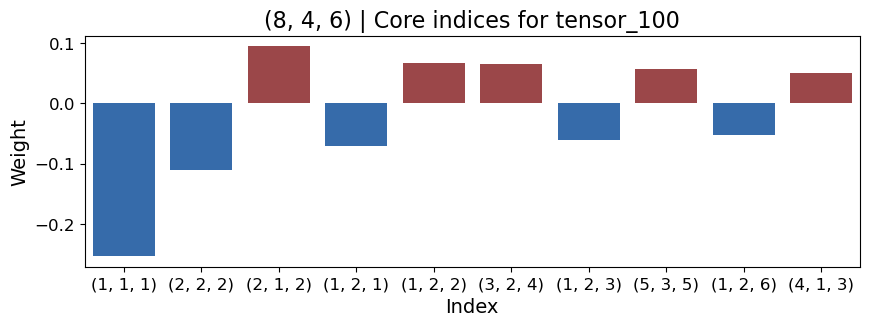

In [22]:
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']
tensor_name = "tensor_100"
type_name = "cent" 
plot_all_rank_decompositions(tensor_name, type_name, tucker_results, pat_list)


## tensor_200


 Checking decompositions for: cent_tensor_200
   Found rank (2, 2, 2)
   Found rank (4, 5, 6)
   Found rank (3, 3, 3)
   Found rank (12, 5, 3)
   Found rank (5, 4, 4)

 Plotting cent_tensor_200 with ranks (2, 2, 2)


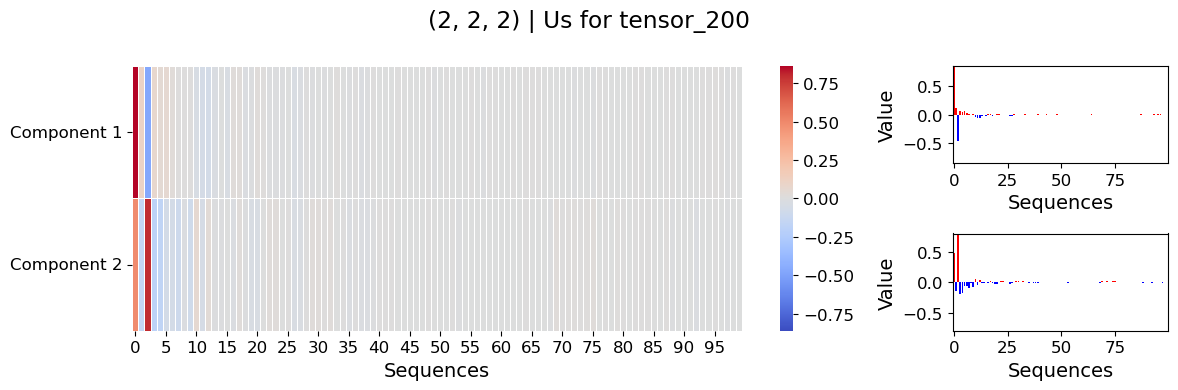

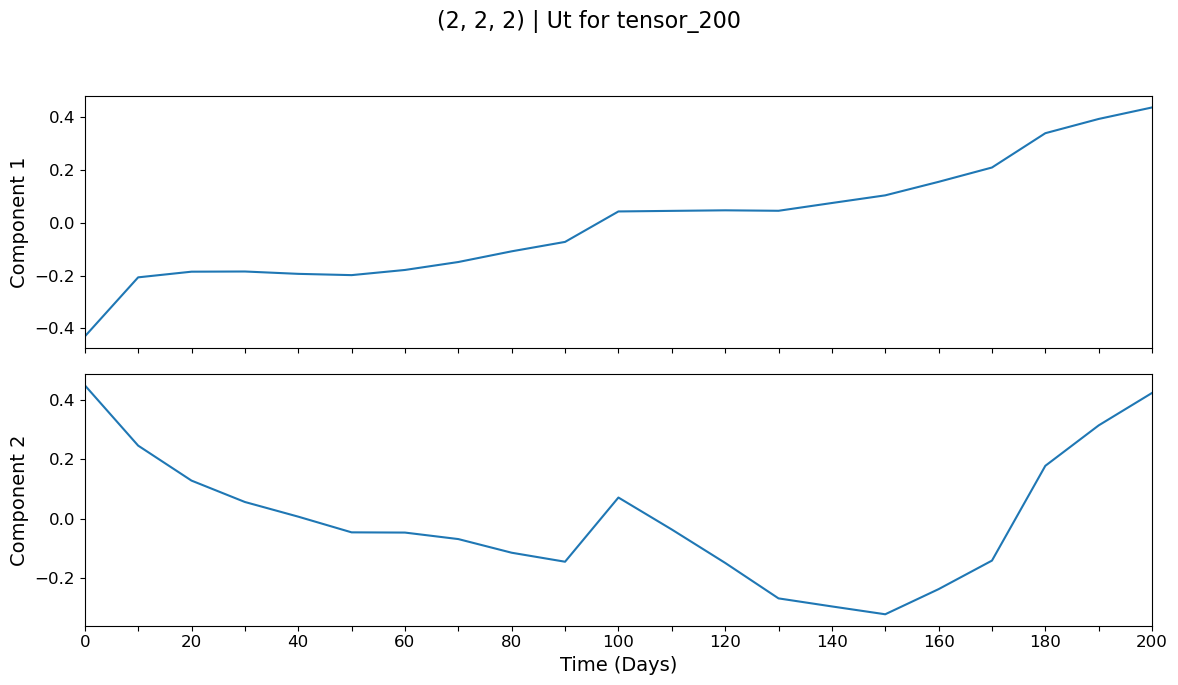

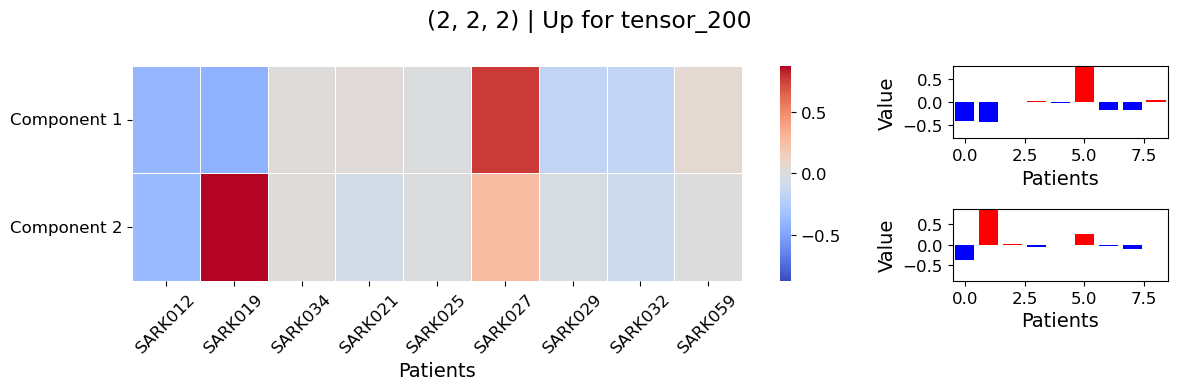

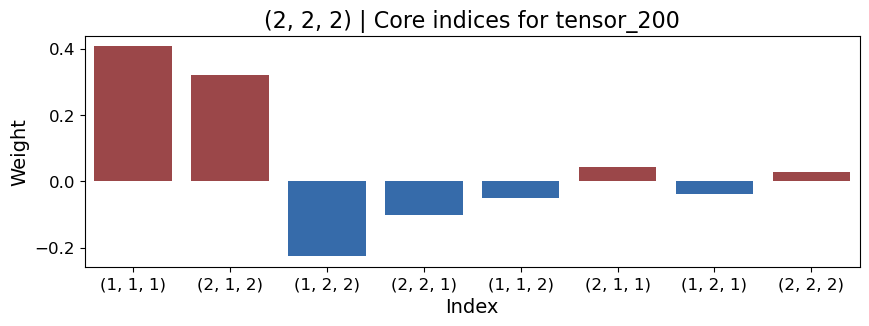


 Plotting cent_tensor_200 with ranks (4, 5, 6)


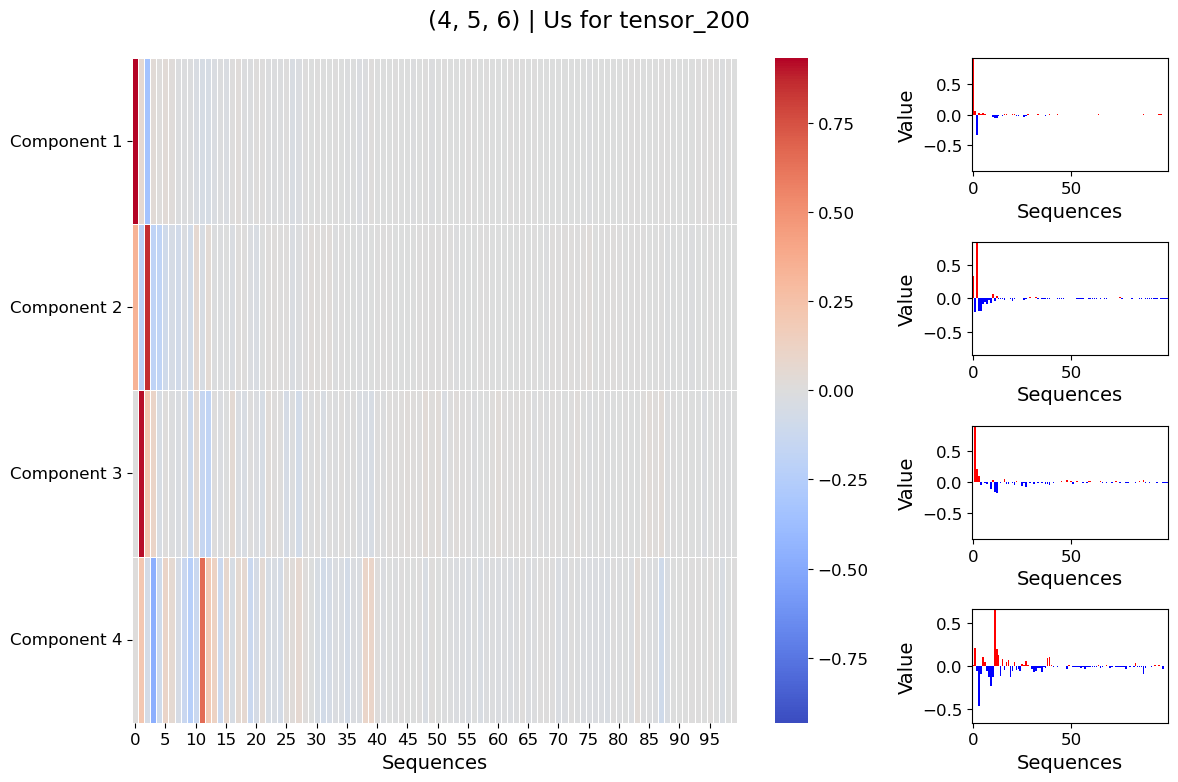

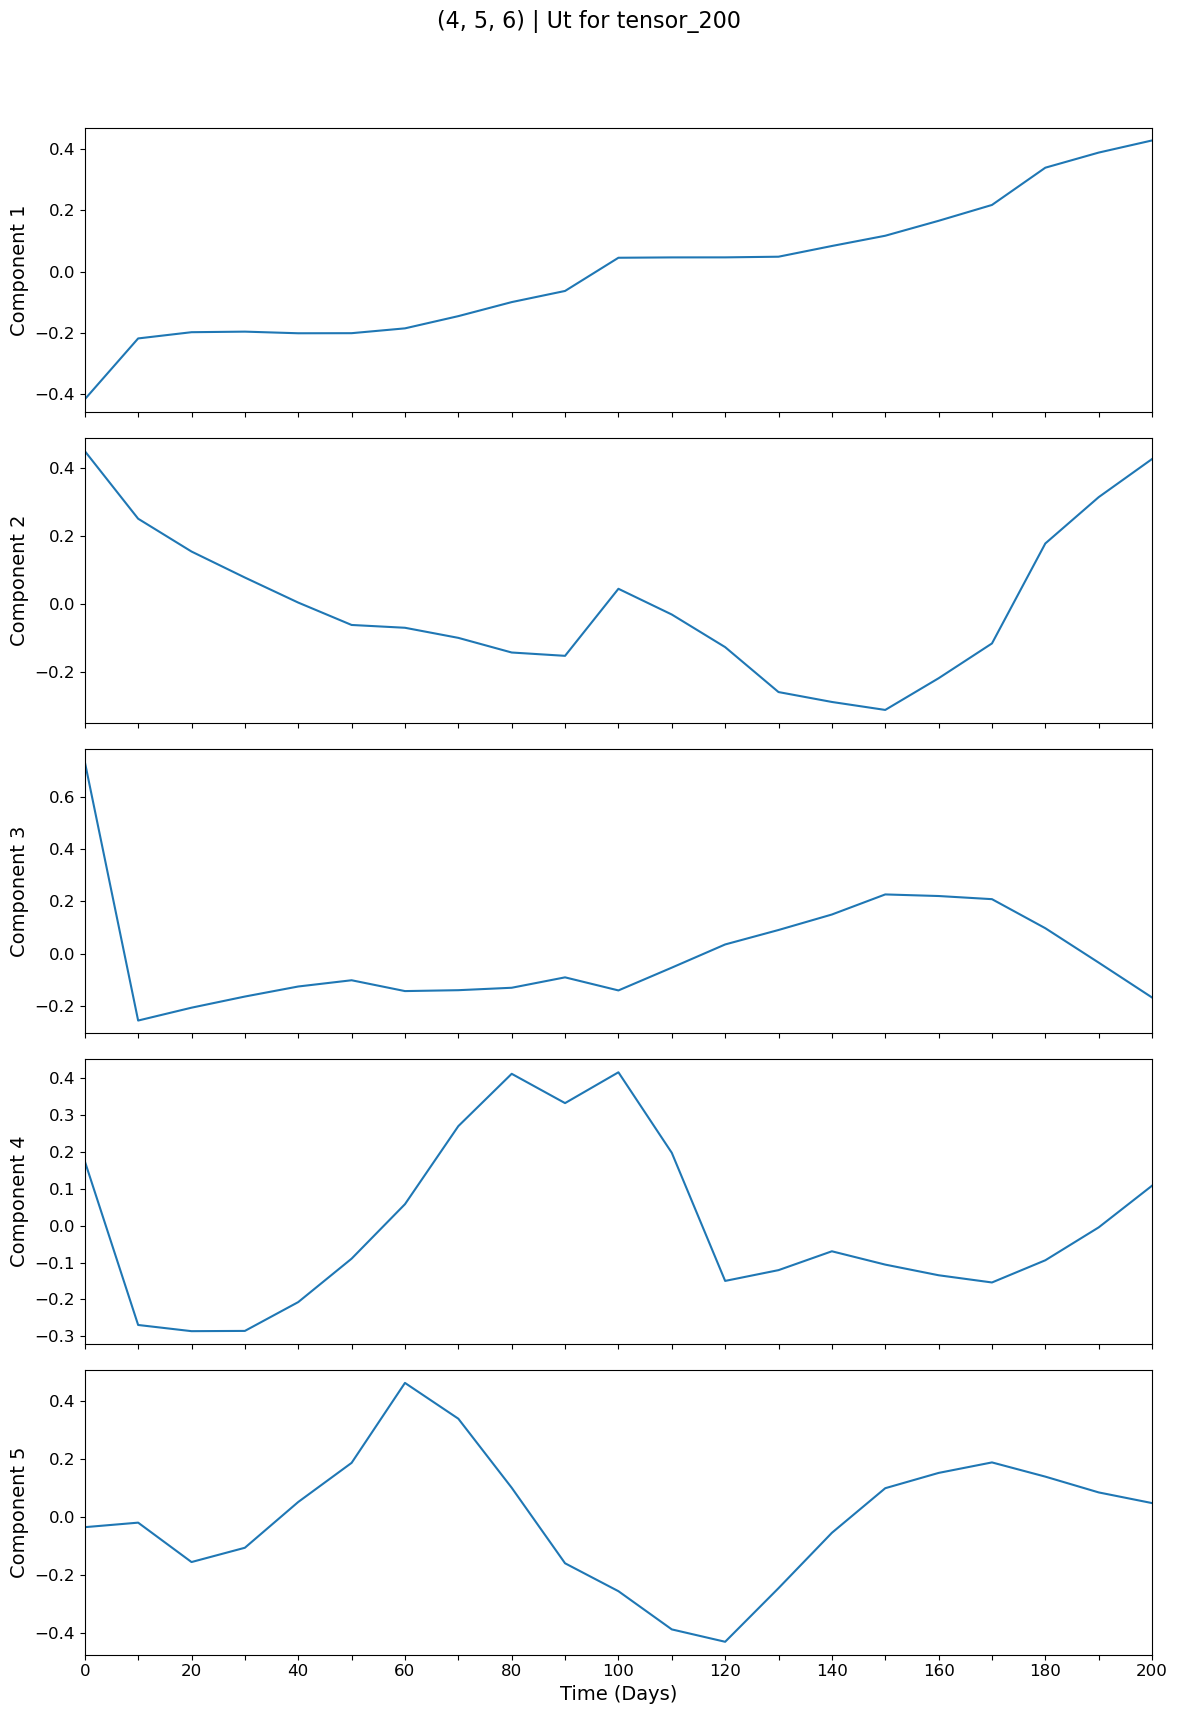

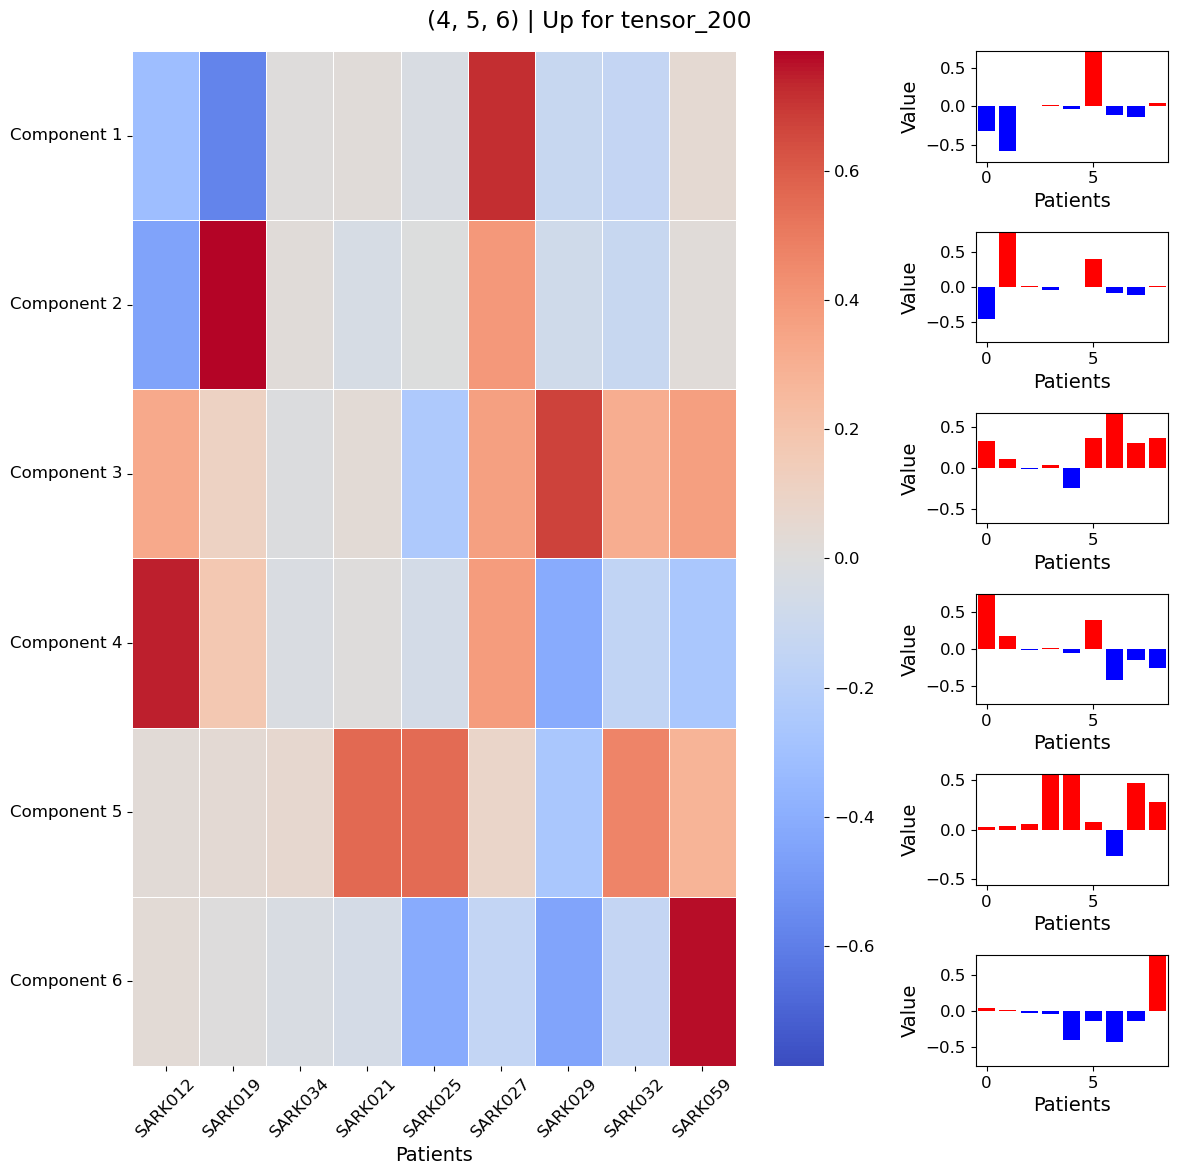

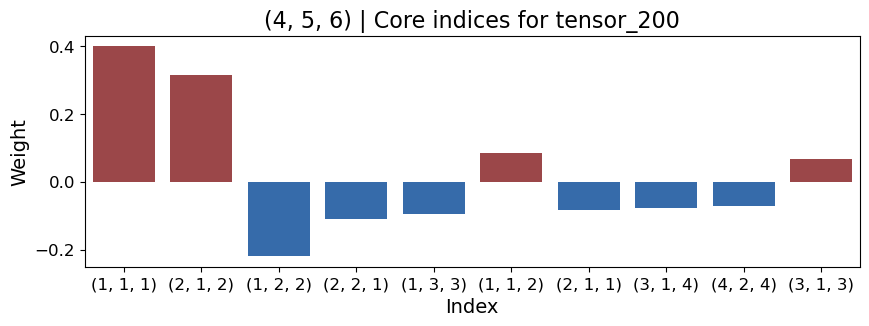


 Plotting cent_tensor_200 with ranks (3, 3, 3)


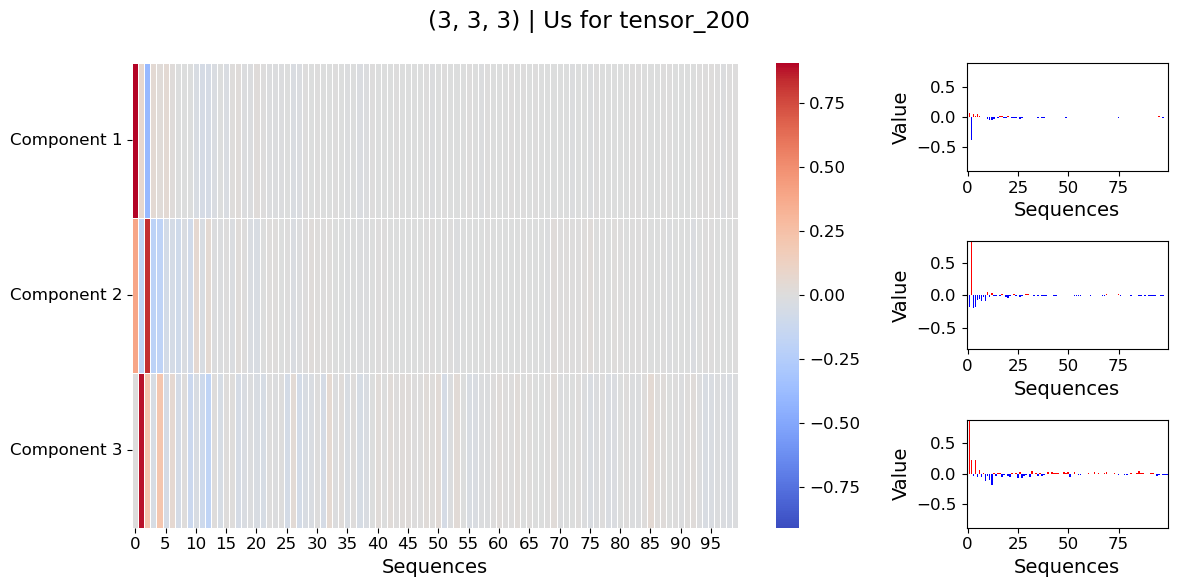

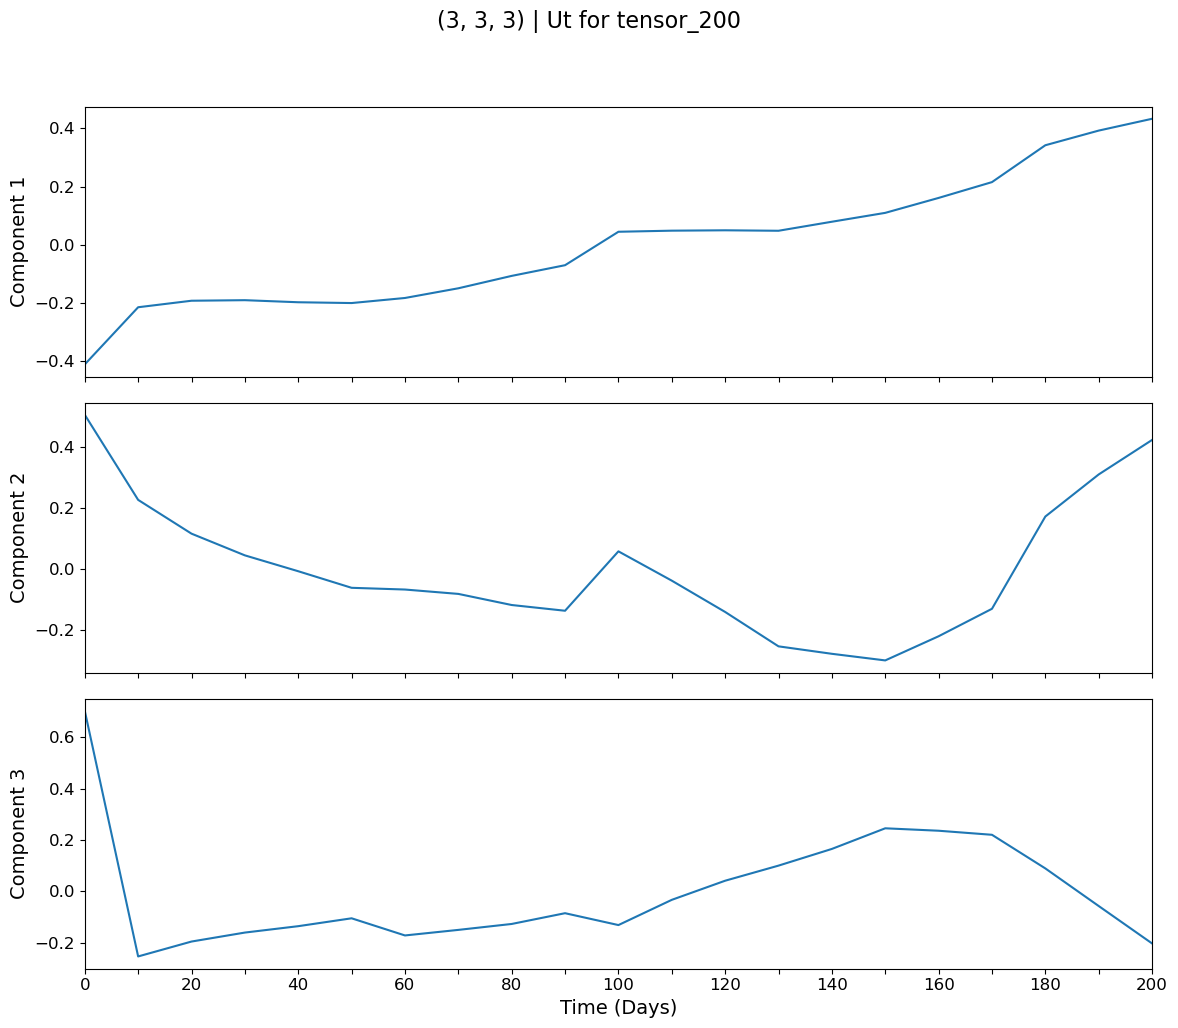

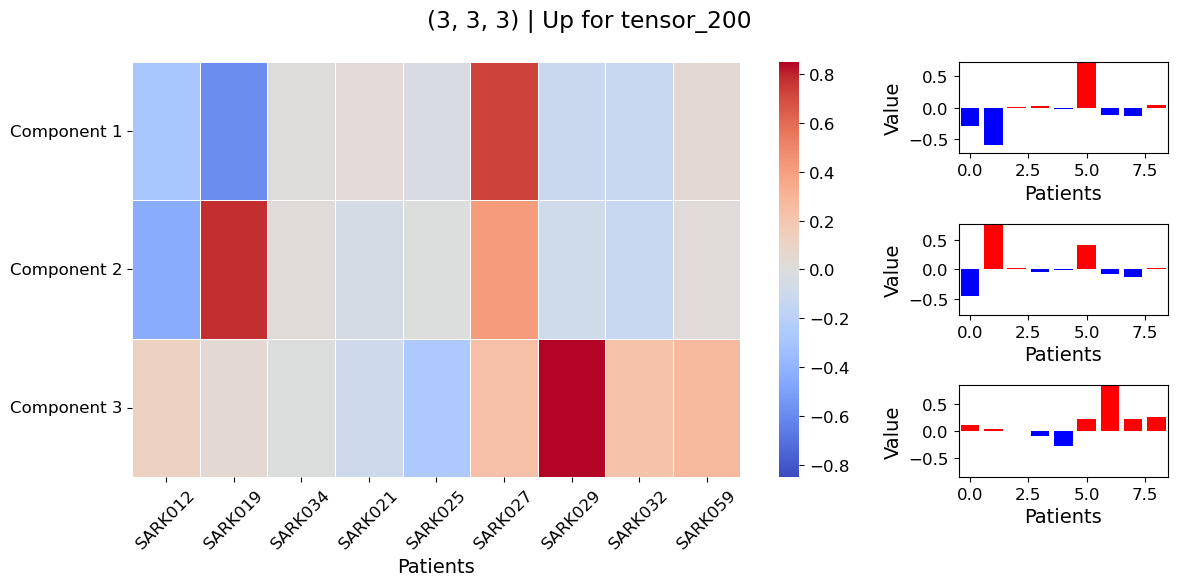

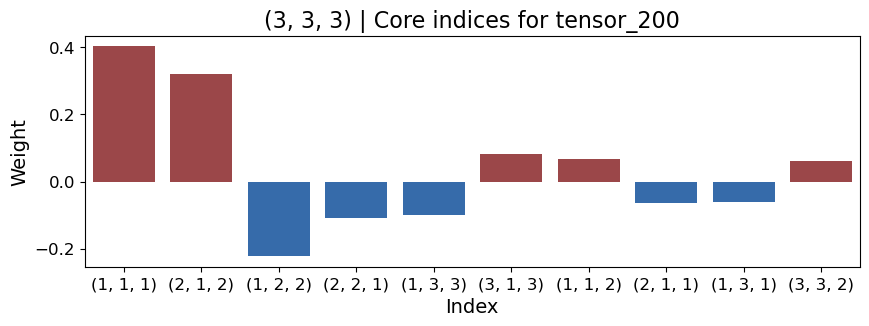


 Plotting cent_tensor_200 with ranks (12, 5, 3)


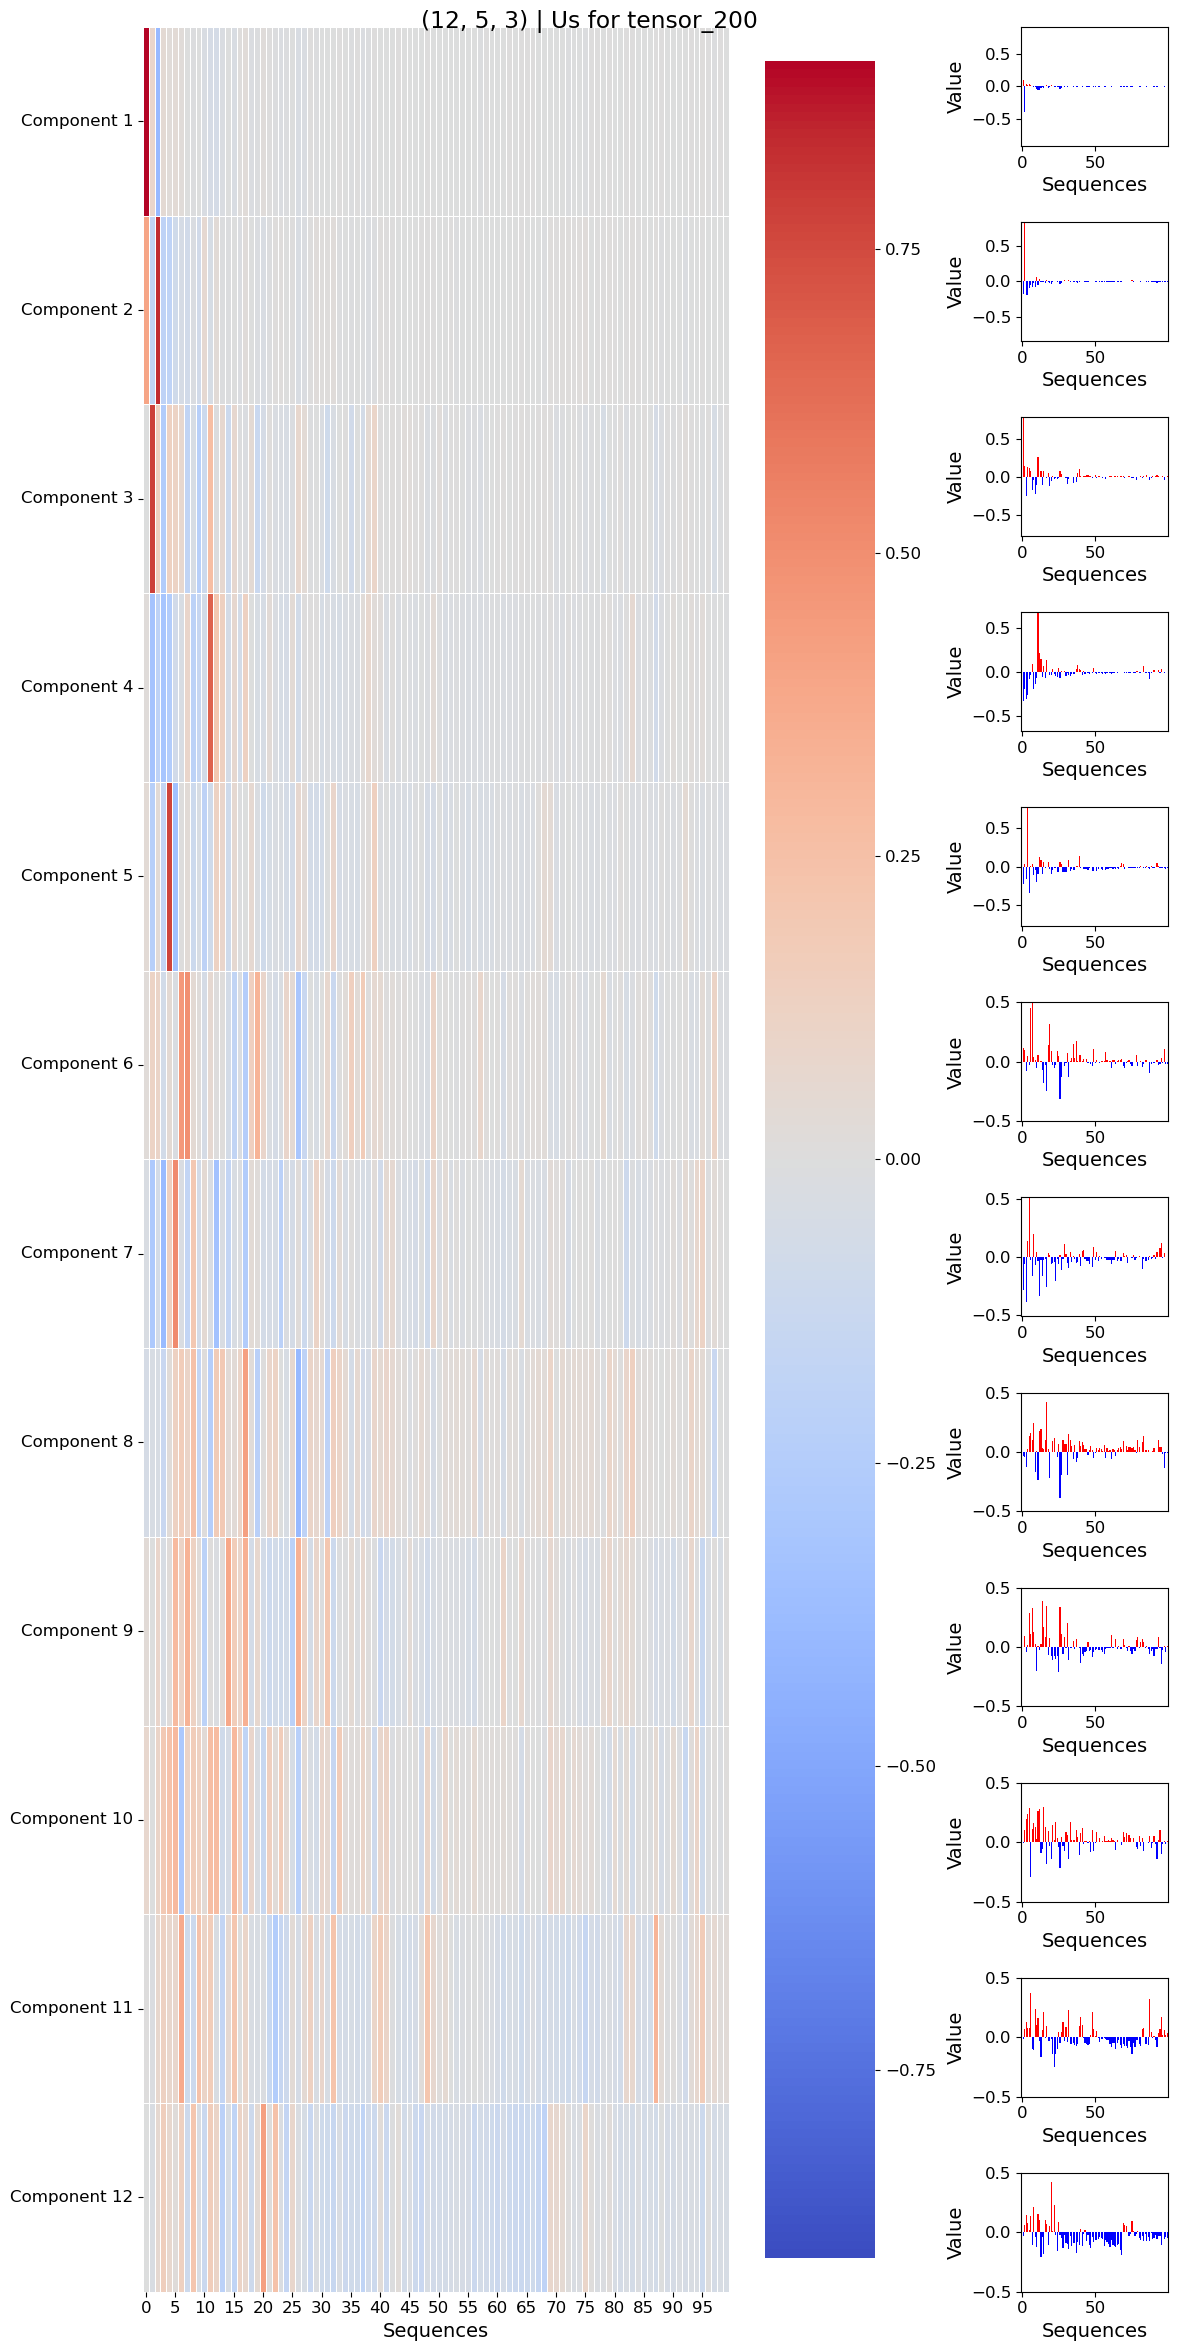

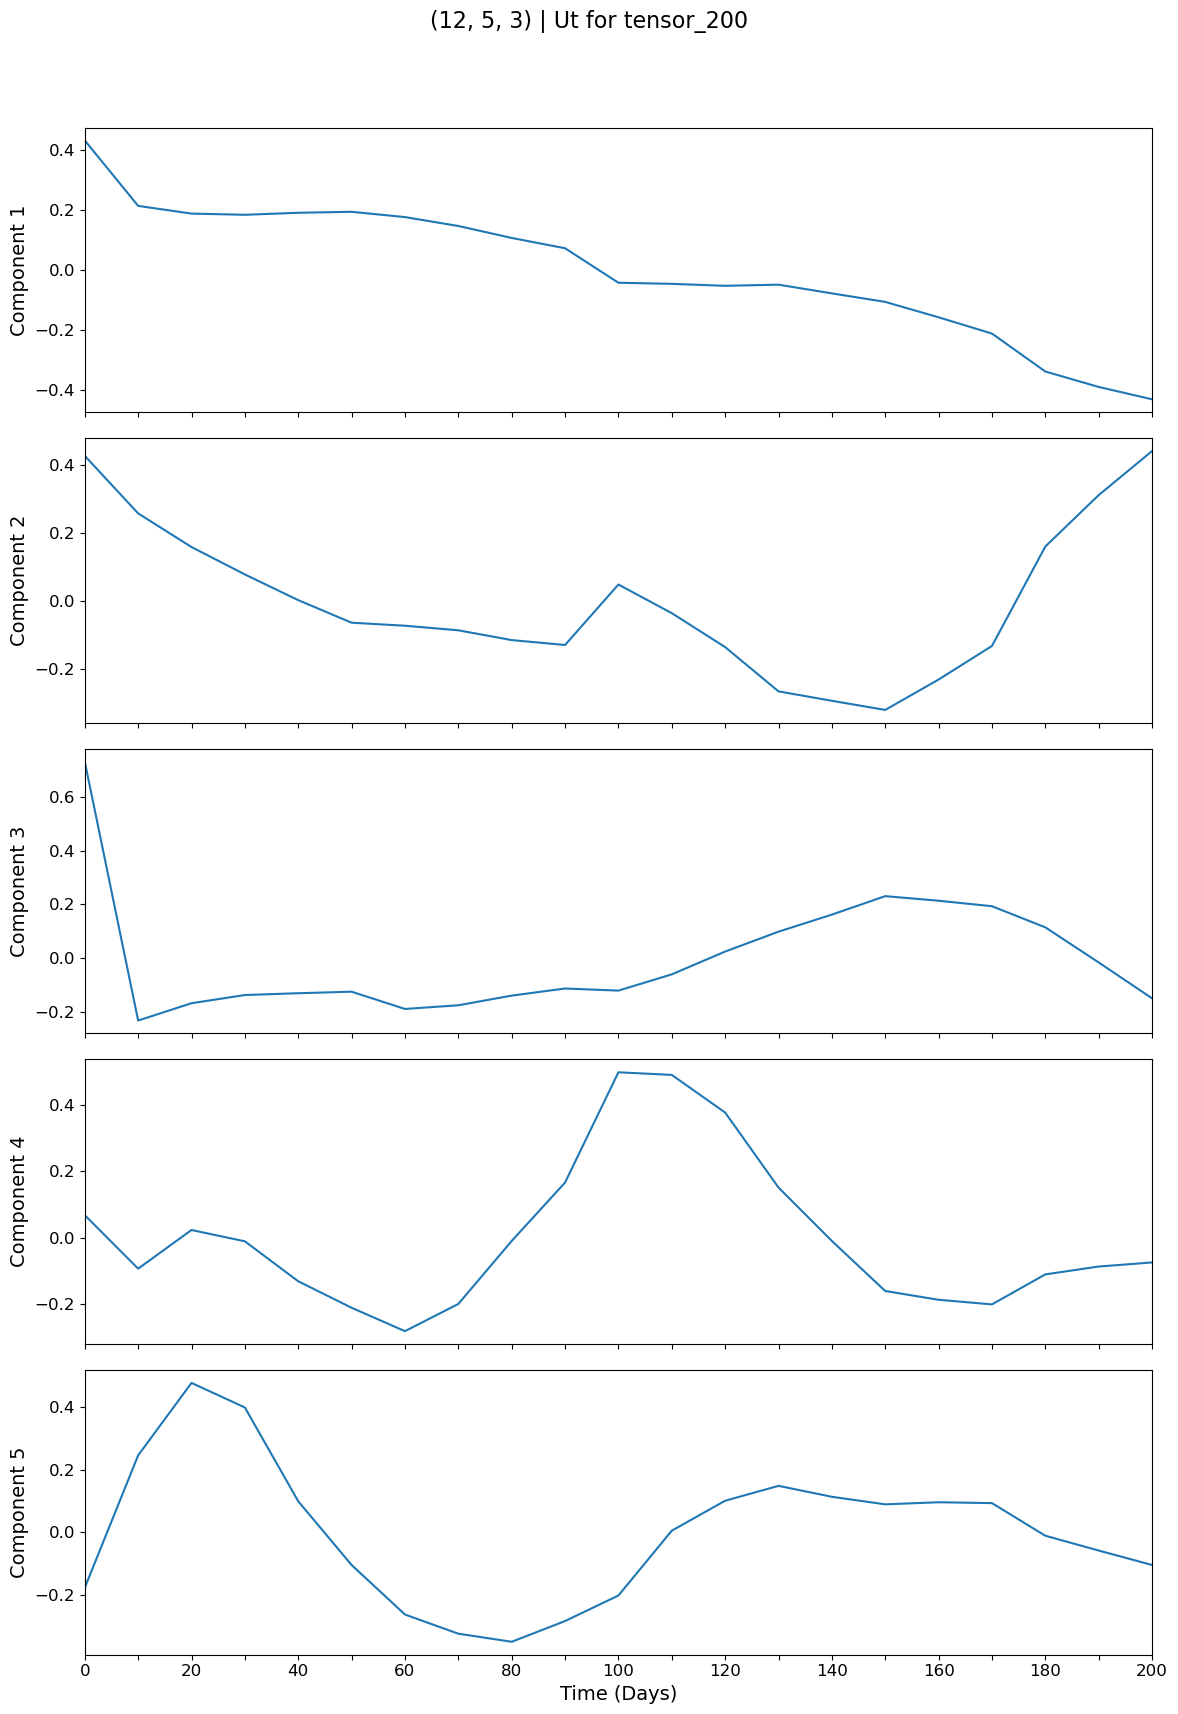

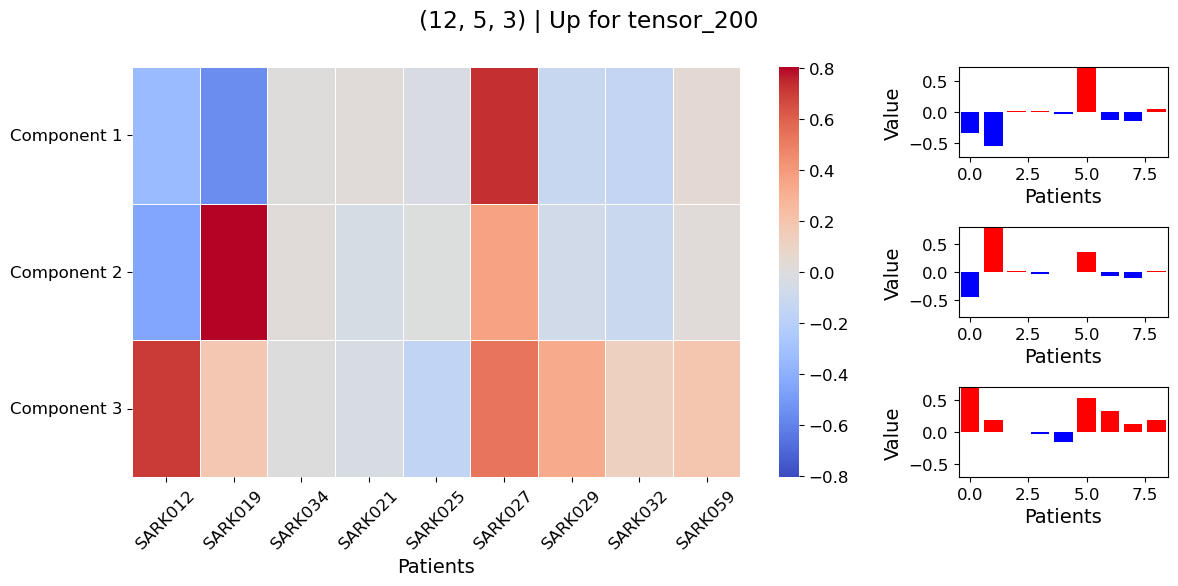

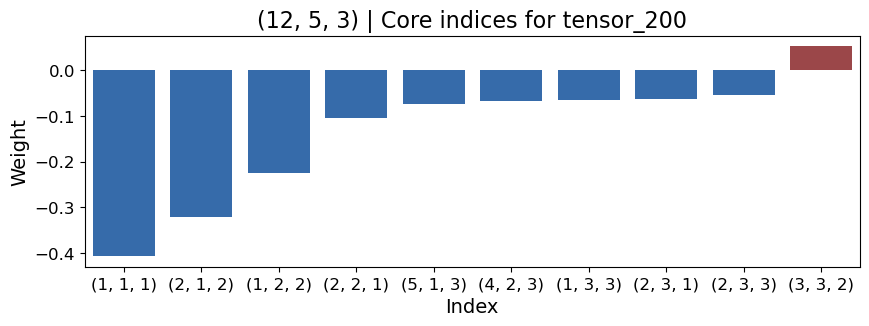


 Plotting cent_tensor_200 with ranks (5, 4, 4)


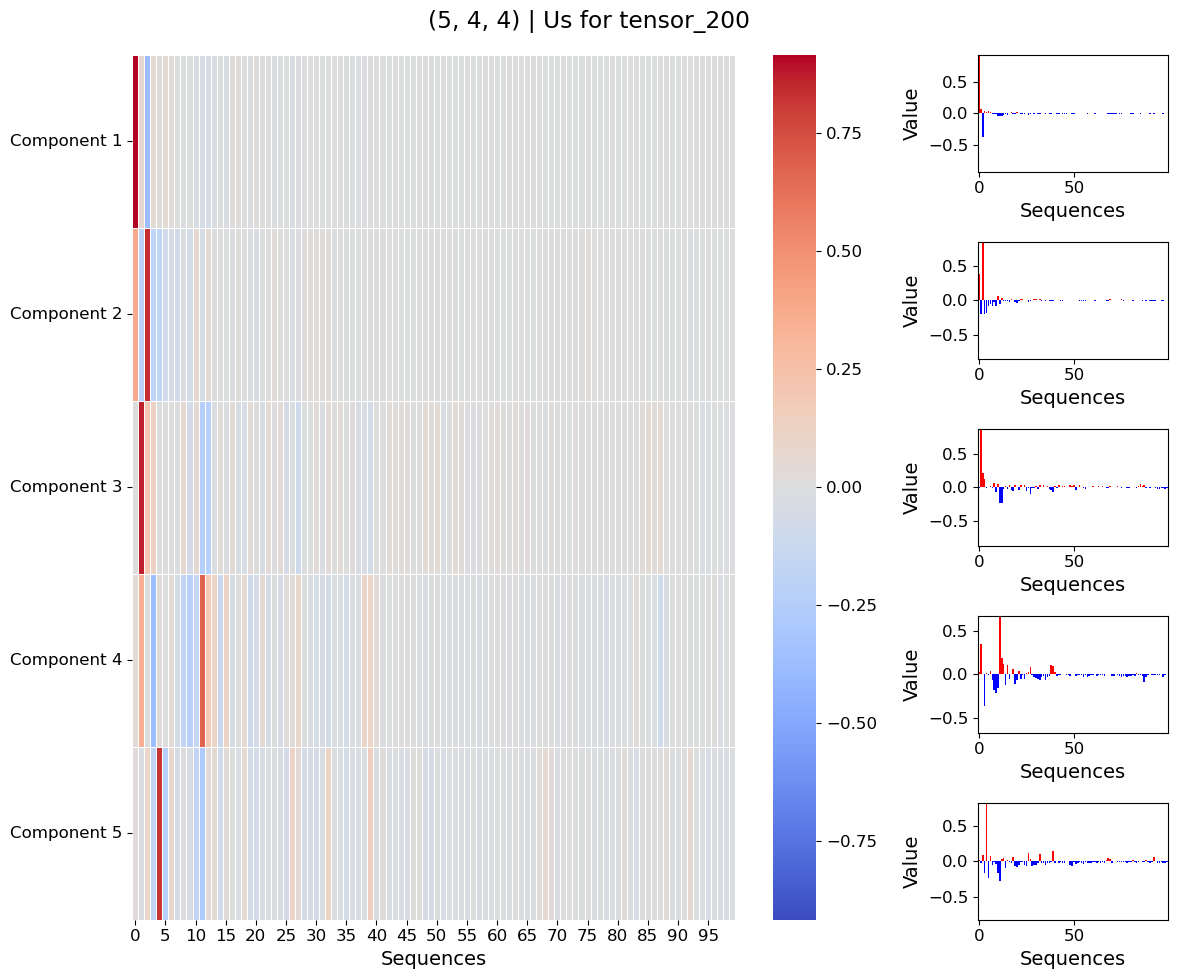

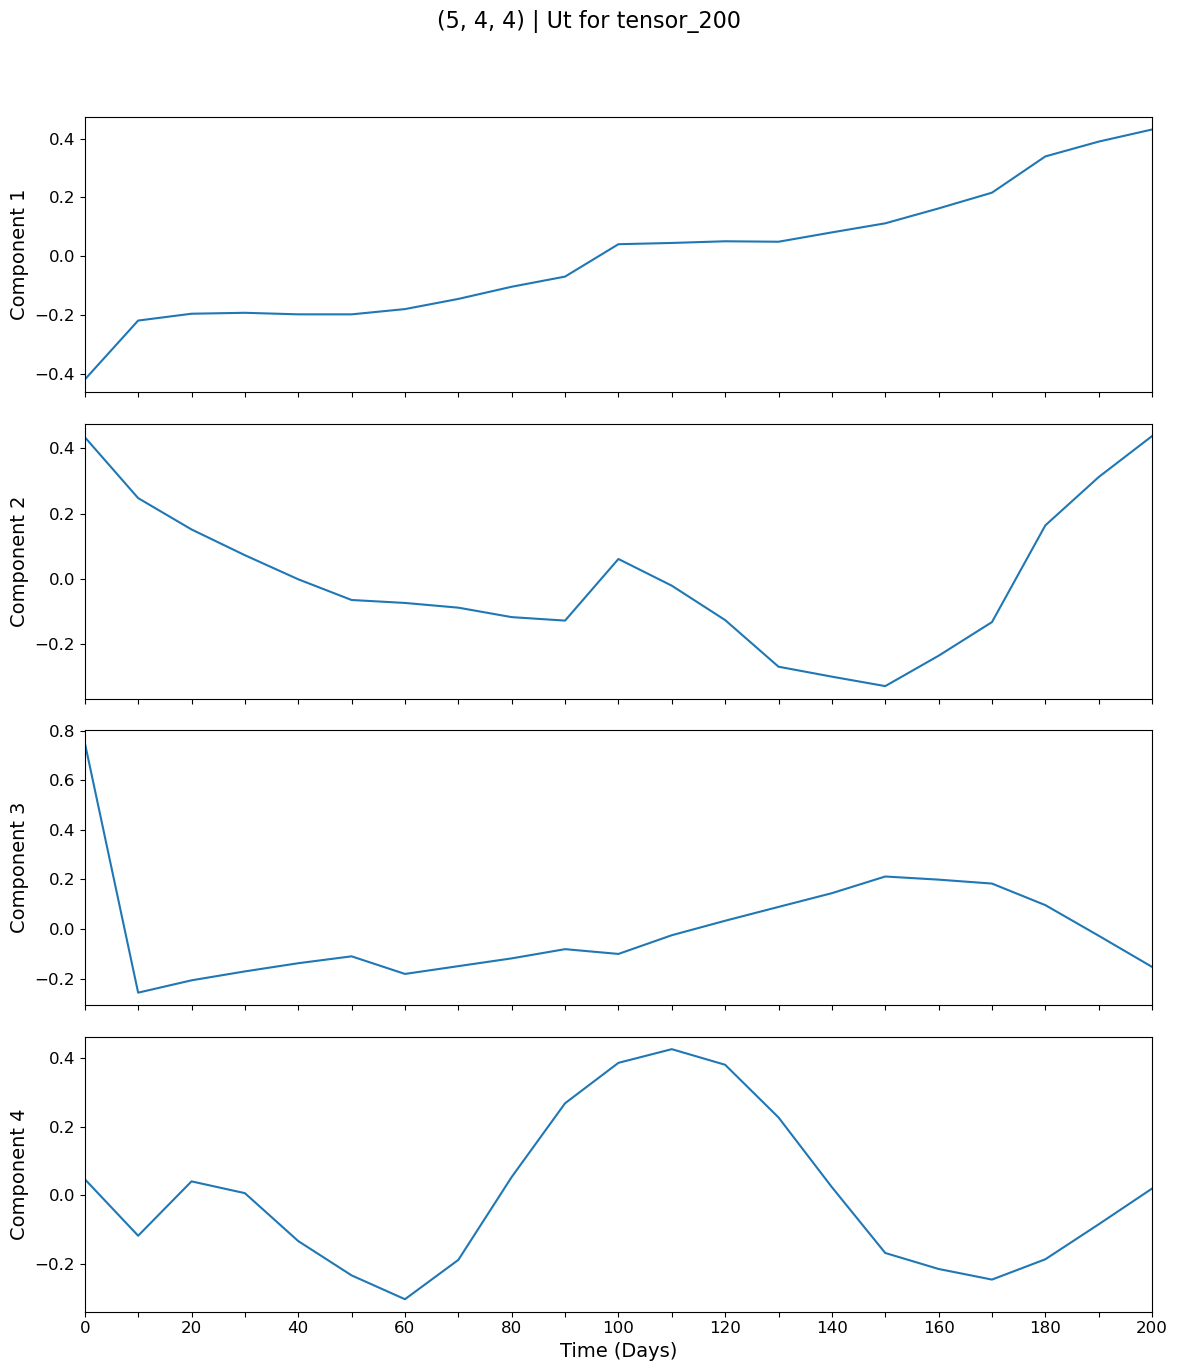

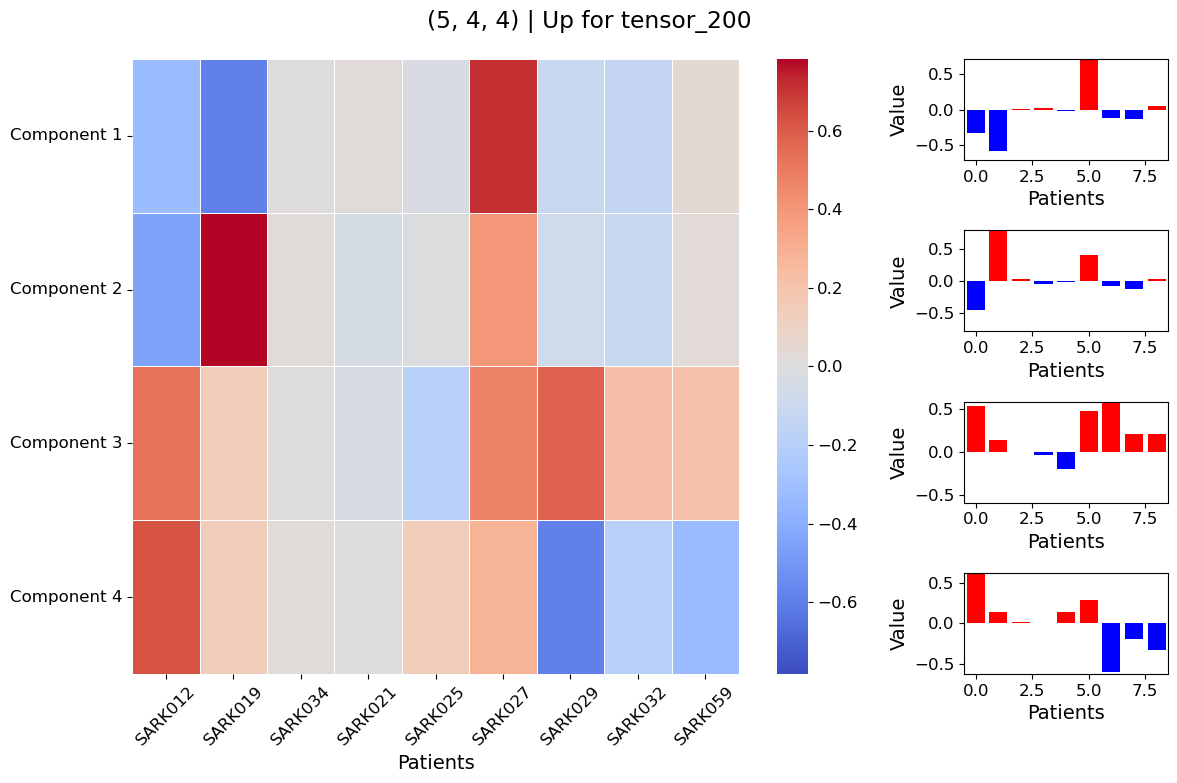

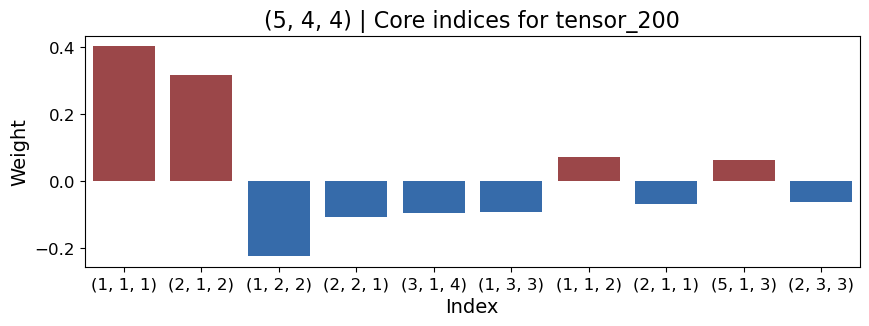

In [23]:
pat_list = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']
tensor_name = "tensor_200"
type_name = "cent" 
plot_all_rank_decompositions(tensor_name, type_name, tucker_results, pat_list)

## tensor_300


 Checking decompositions for: cent_tensor_300
   Found rank (2, 3, 3)
   Found rank (4, 6, 5)
   Found rank (4, 4, 3)
   Found rank (15, 7, 3)
   Found rank (8, 6, 4)

 Plotting cent_tensor_300 with ranks (2, 3, 3)


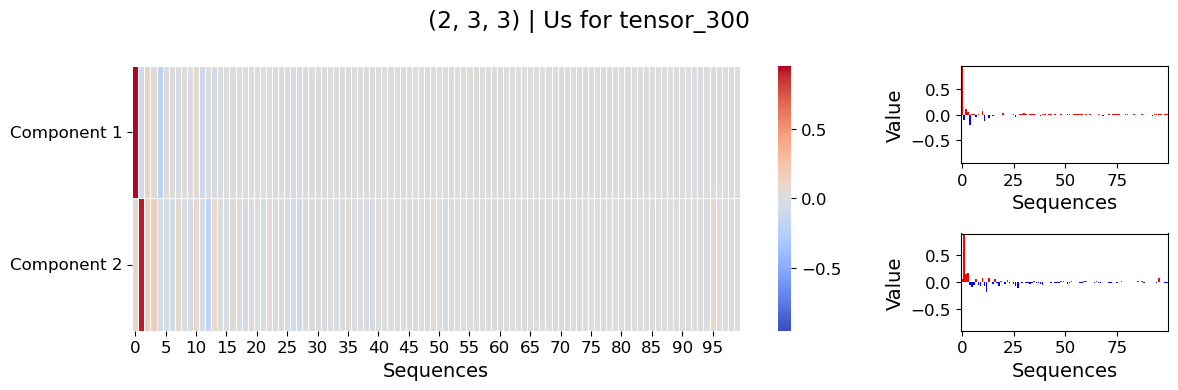

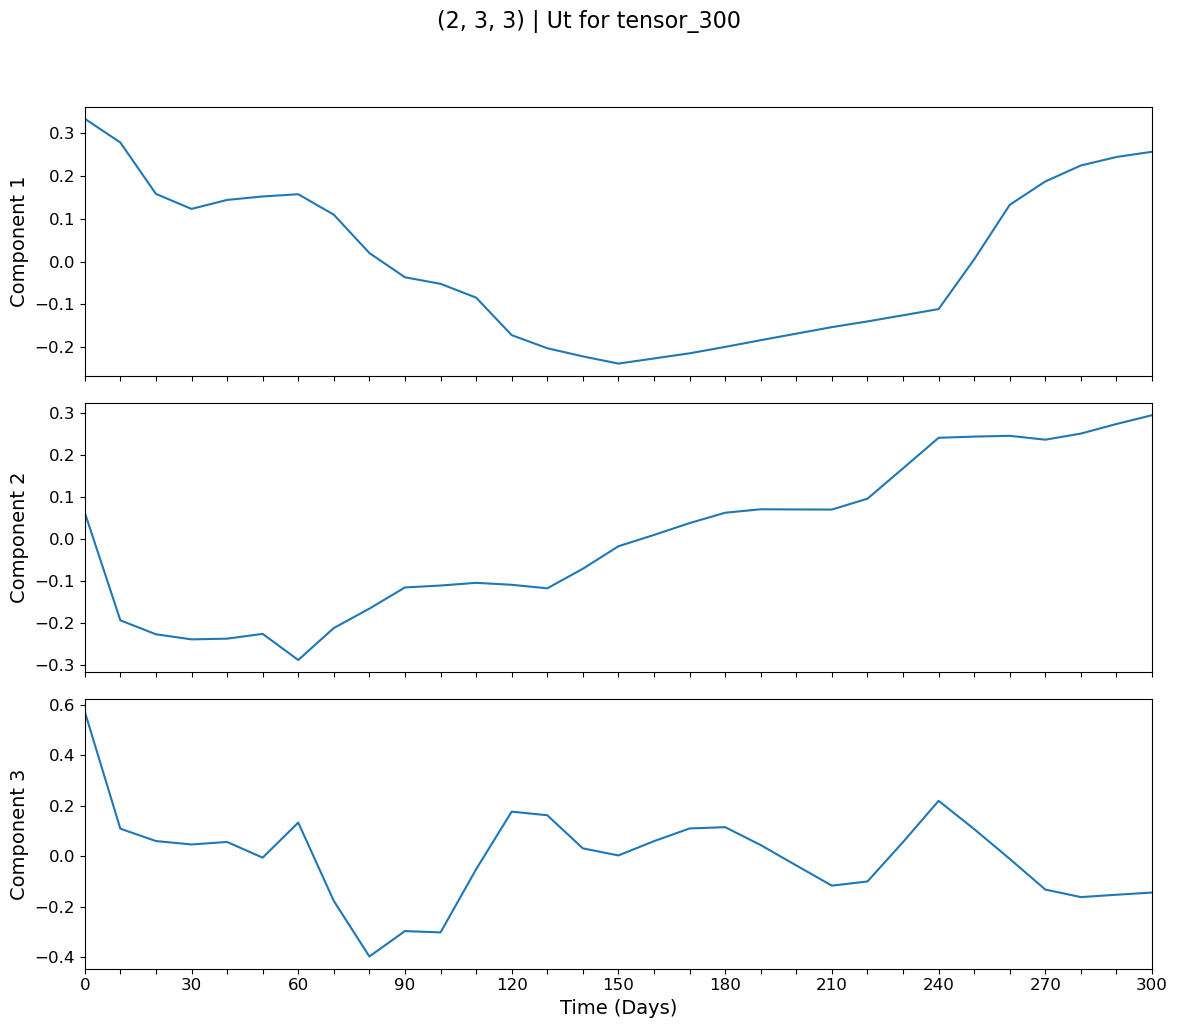

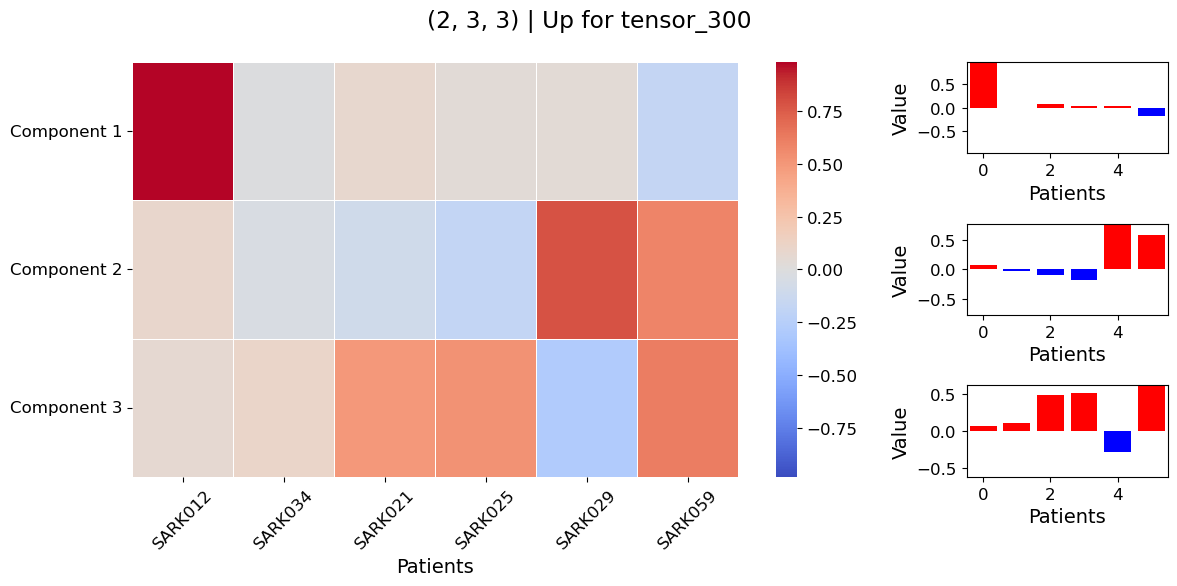

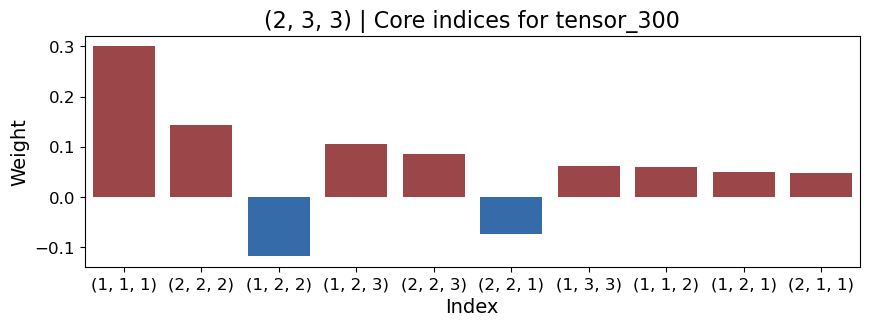


 Plotting cent_tensor_300 with ranks (4, 6, 5)


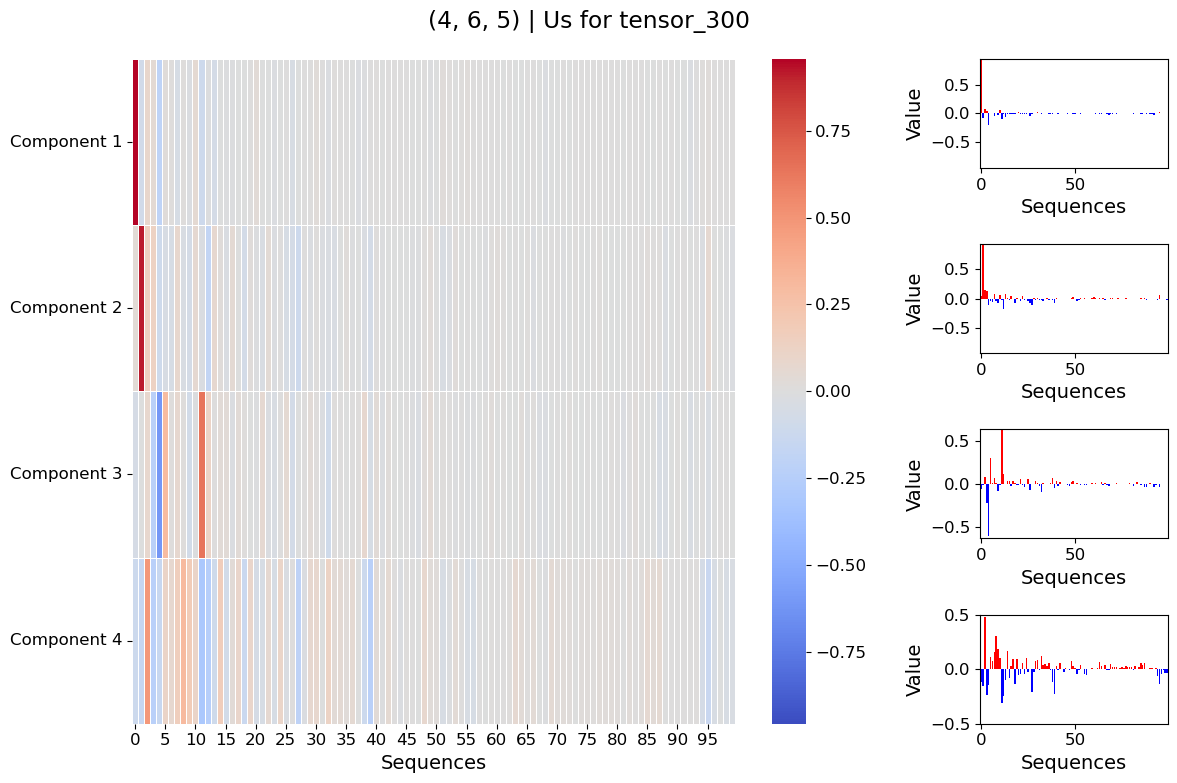

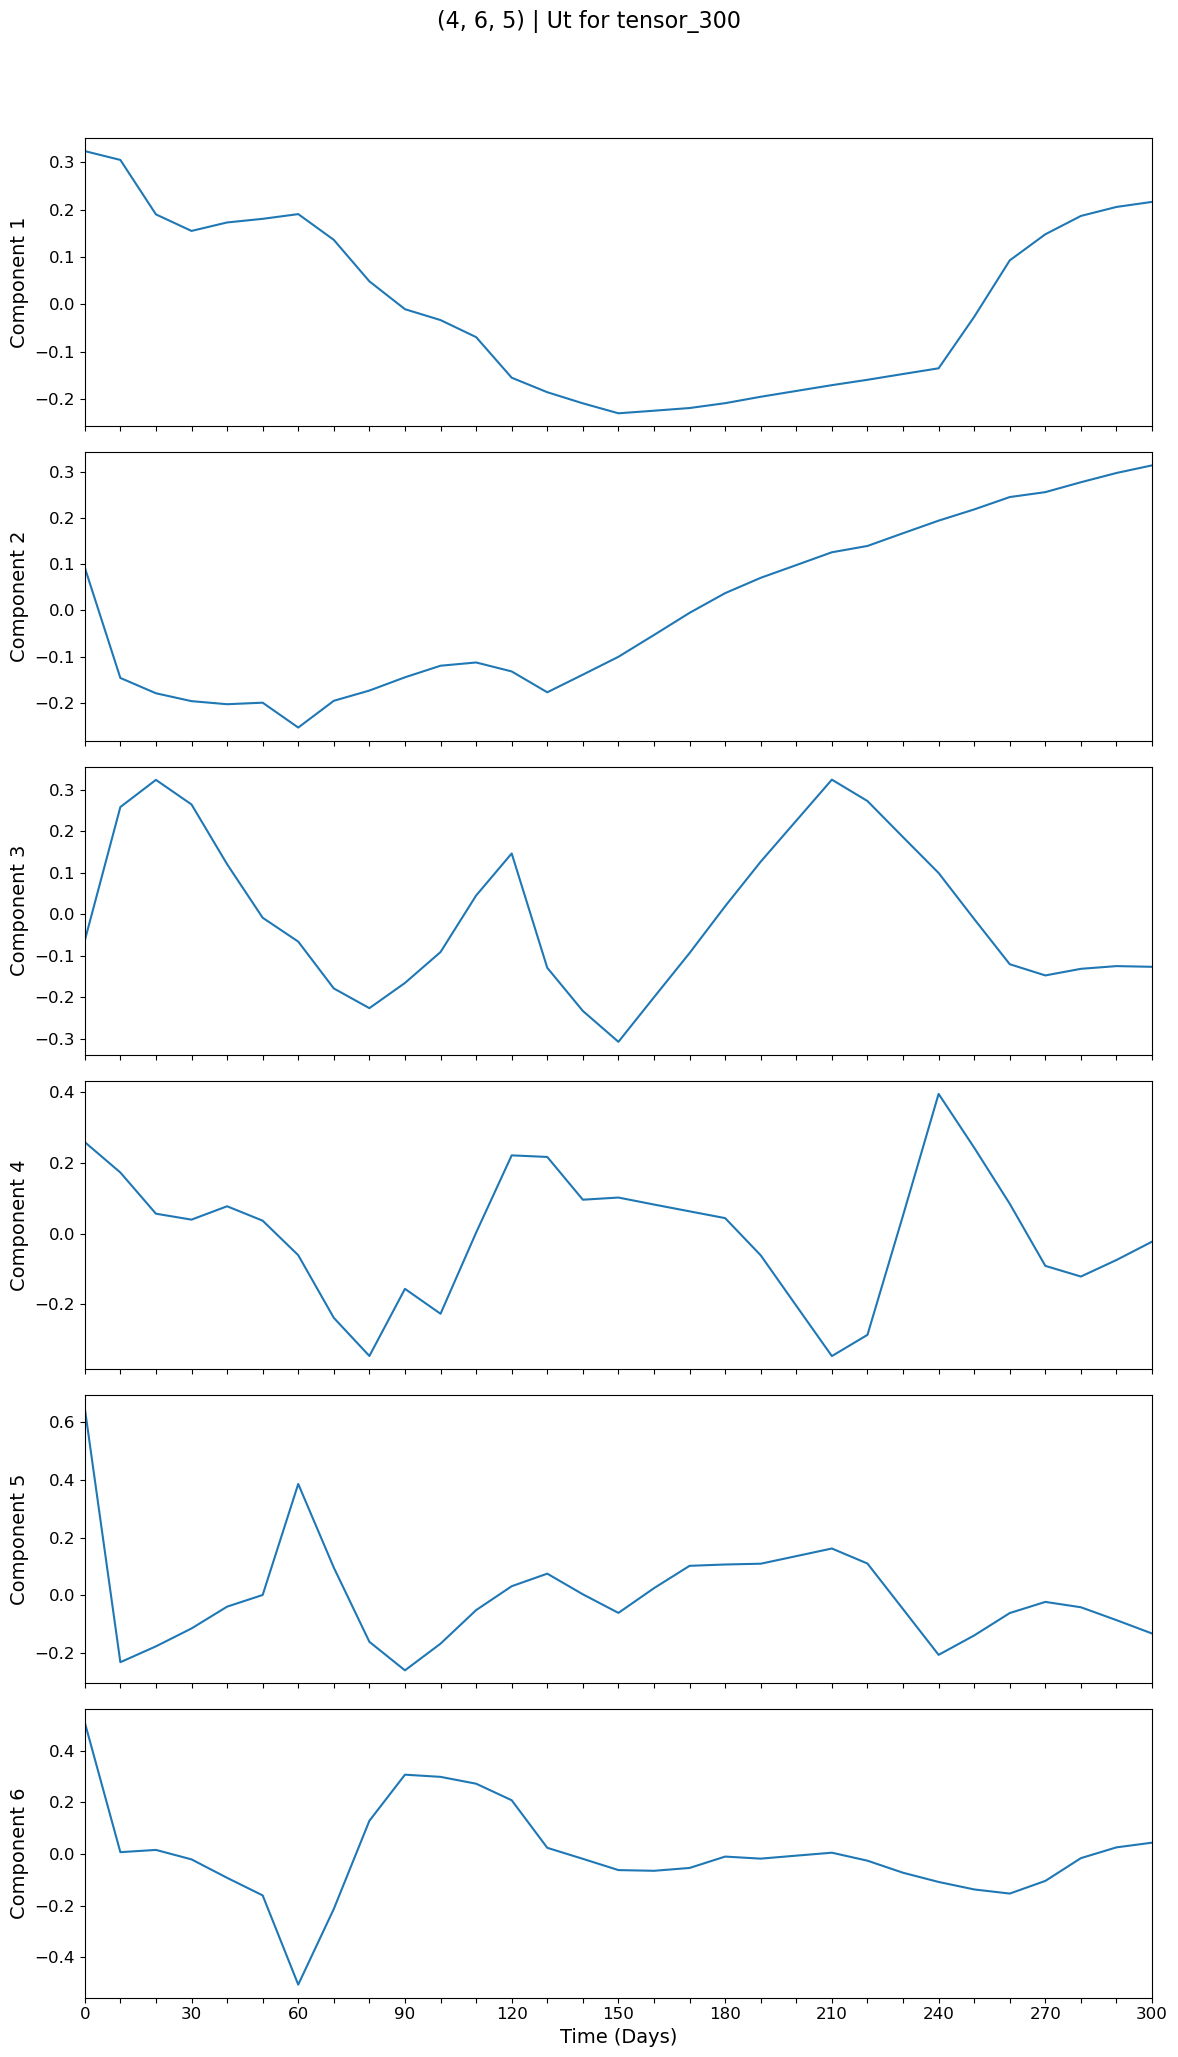

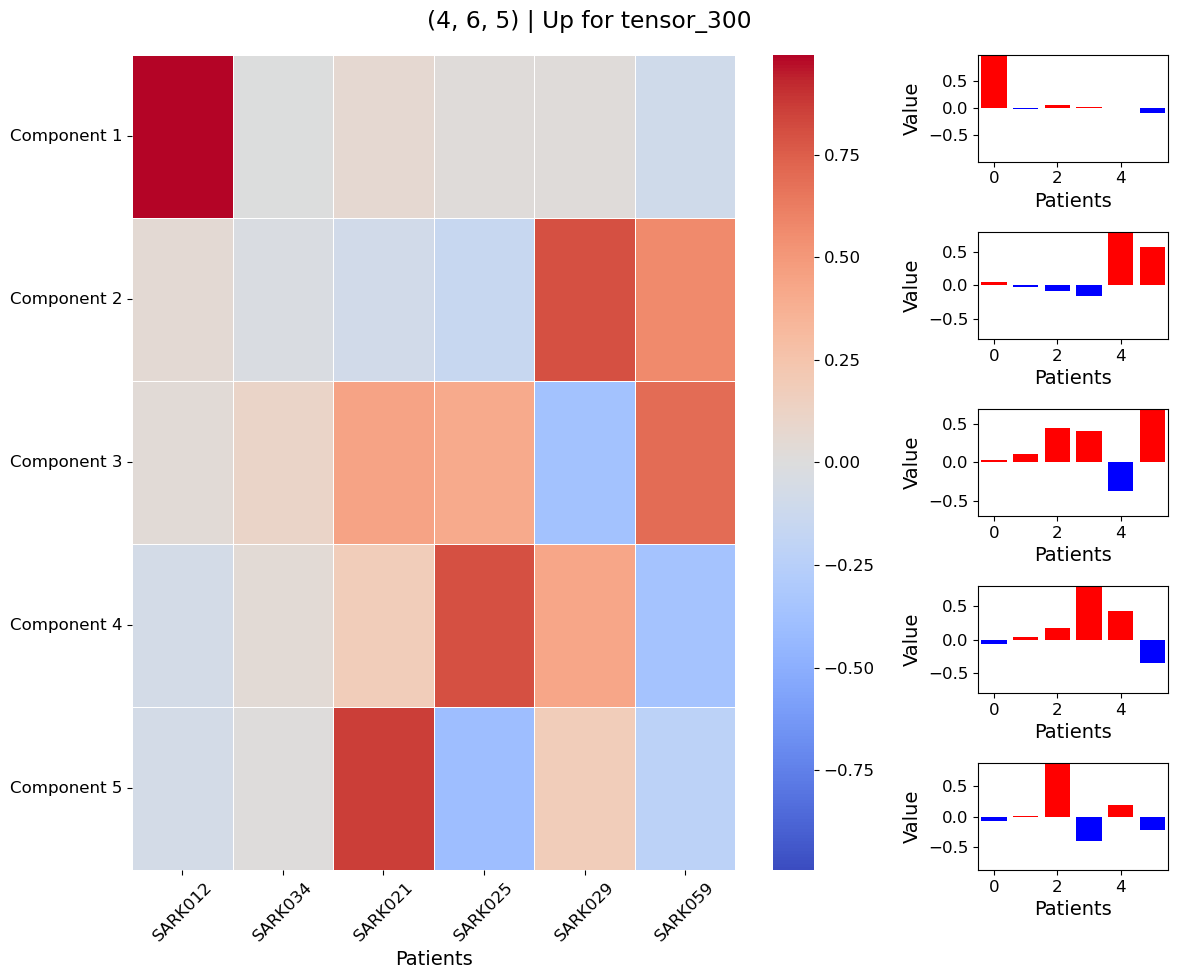

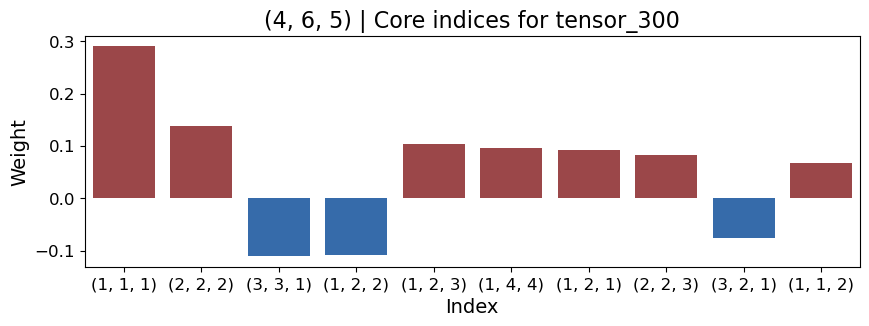


 Plotting cent_tensor_300 with ranks (4, 4, 3)


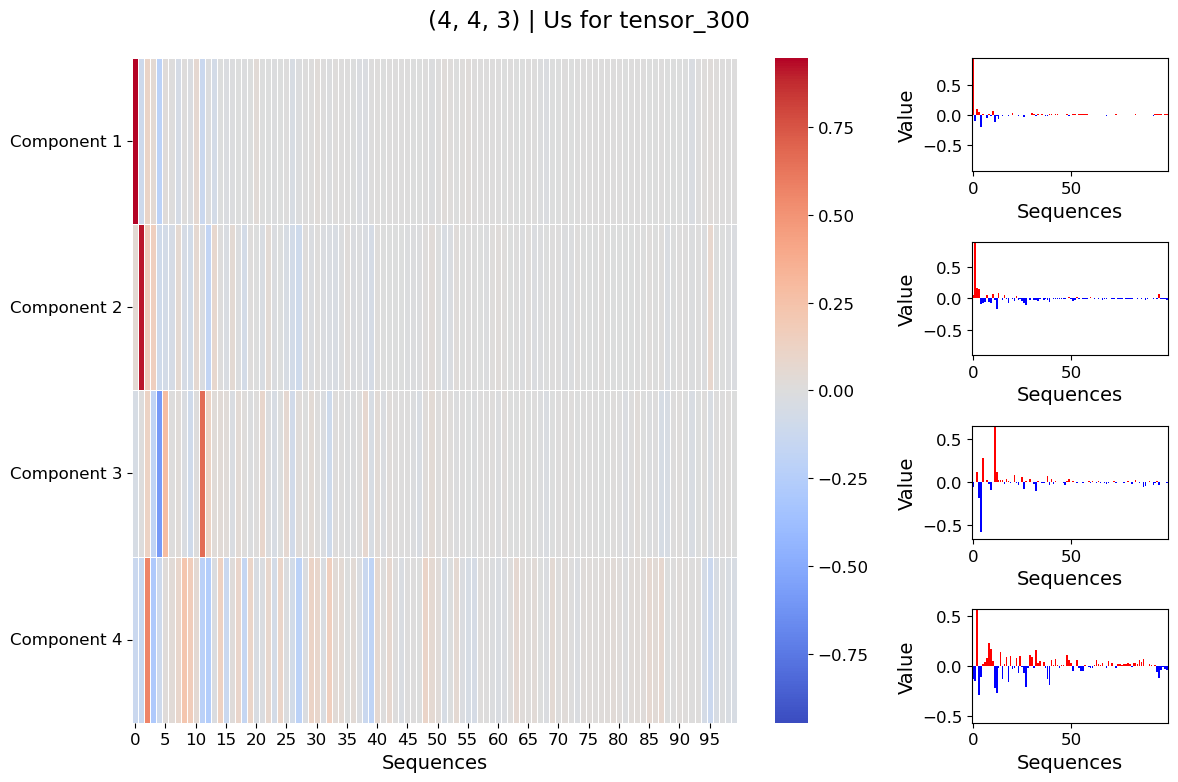

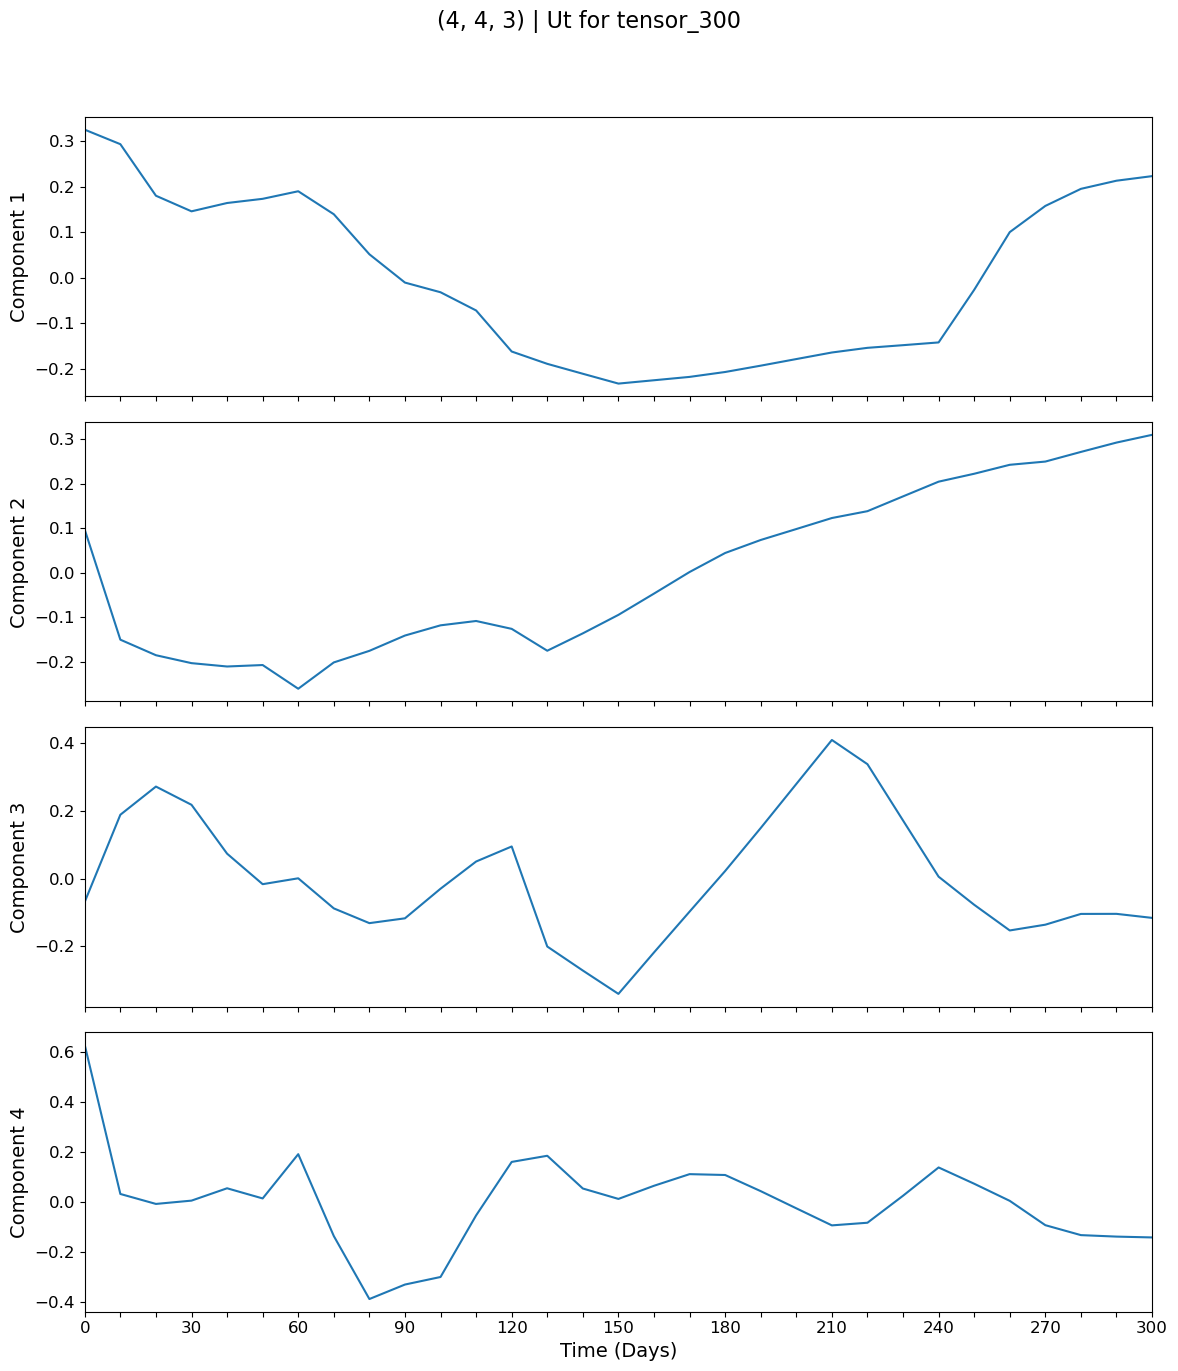

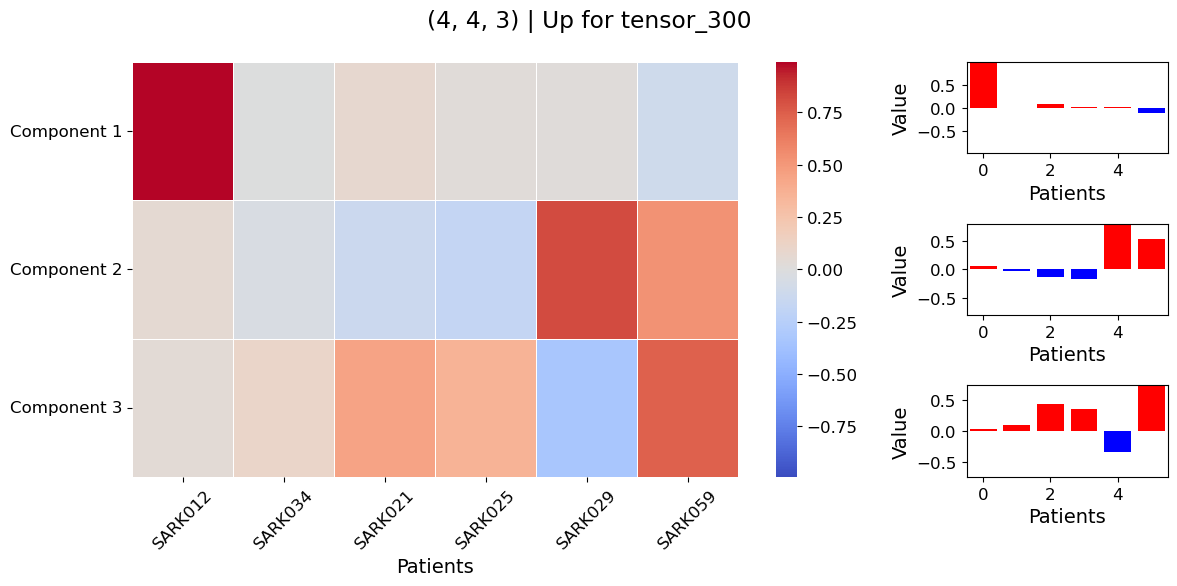

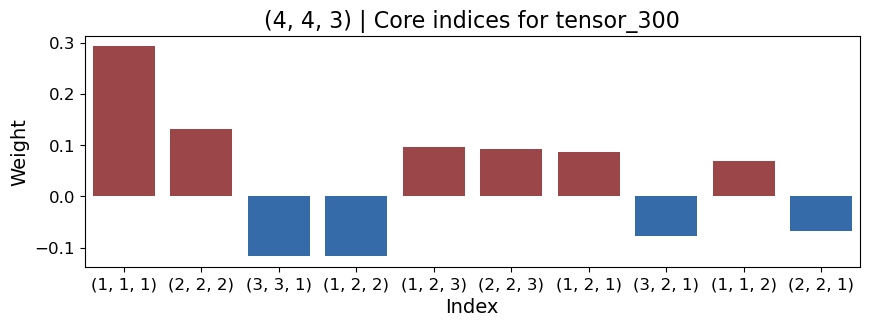


 Plotting cent_tensor_300 with ranks (15, 7, 3)


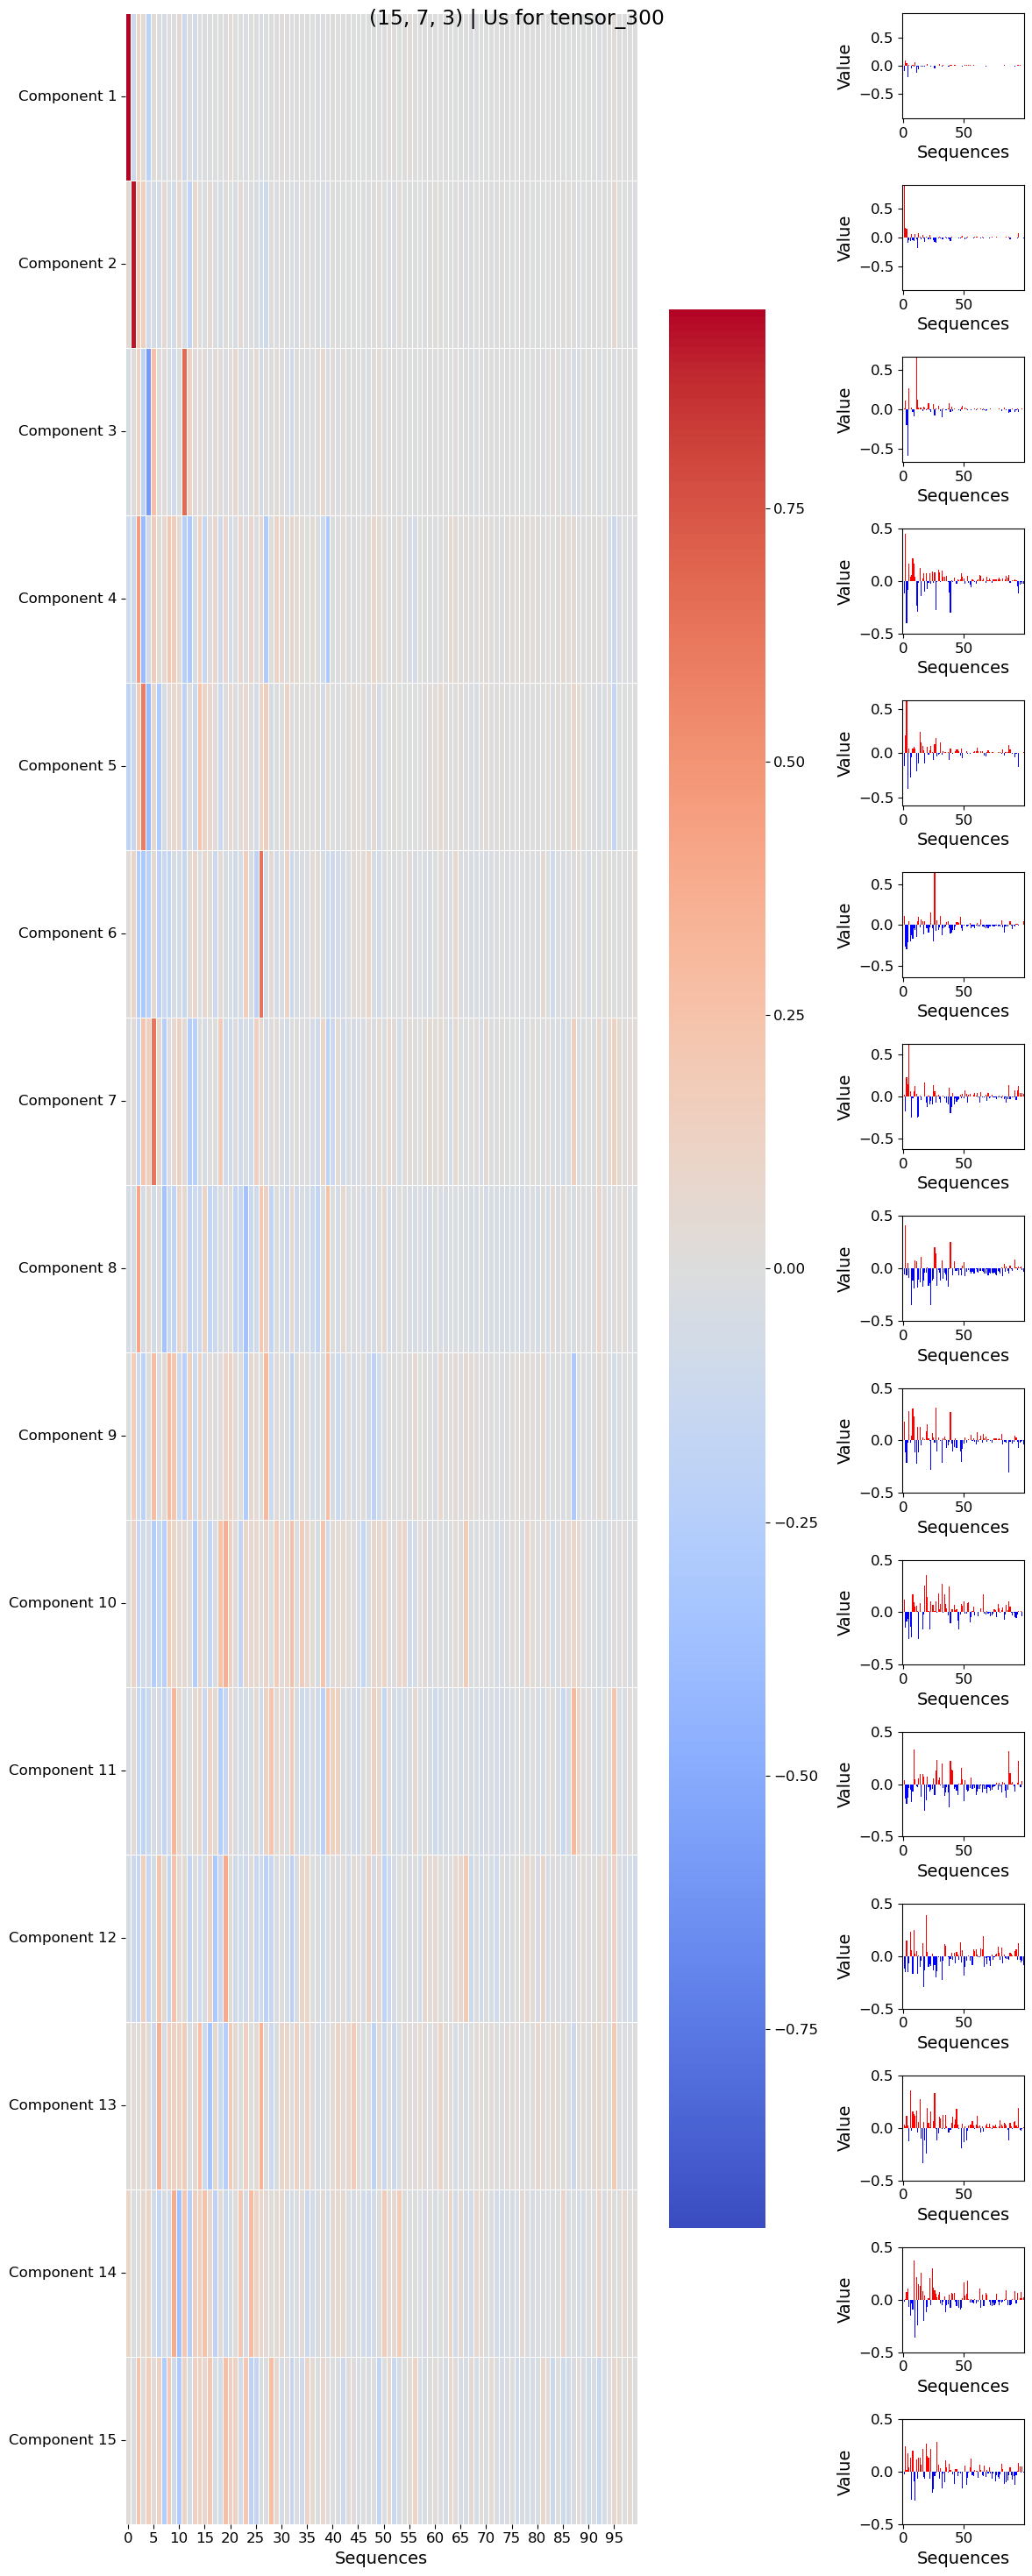

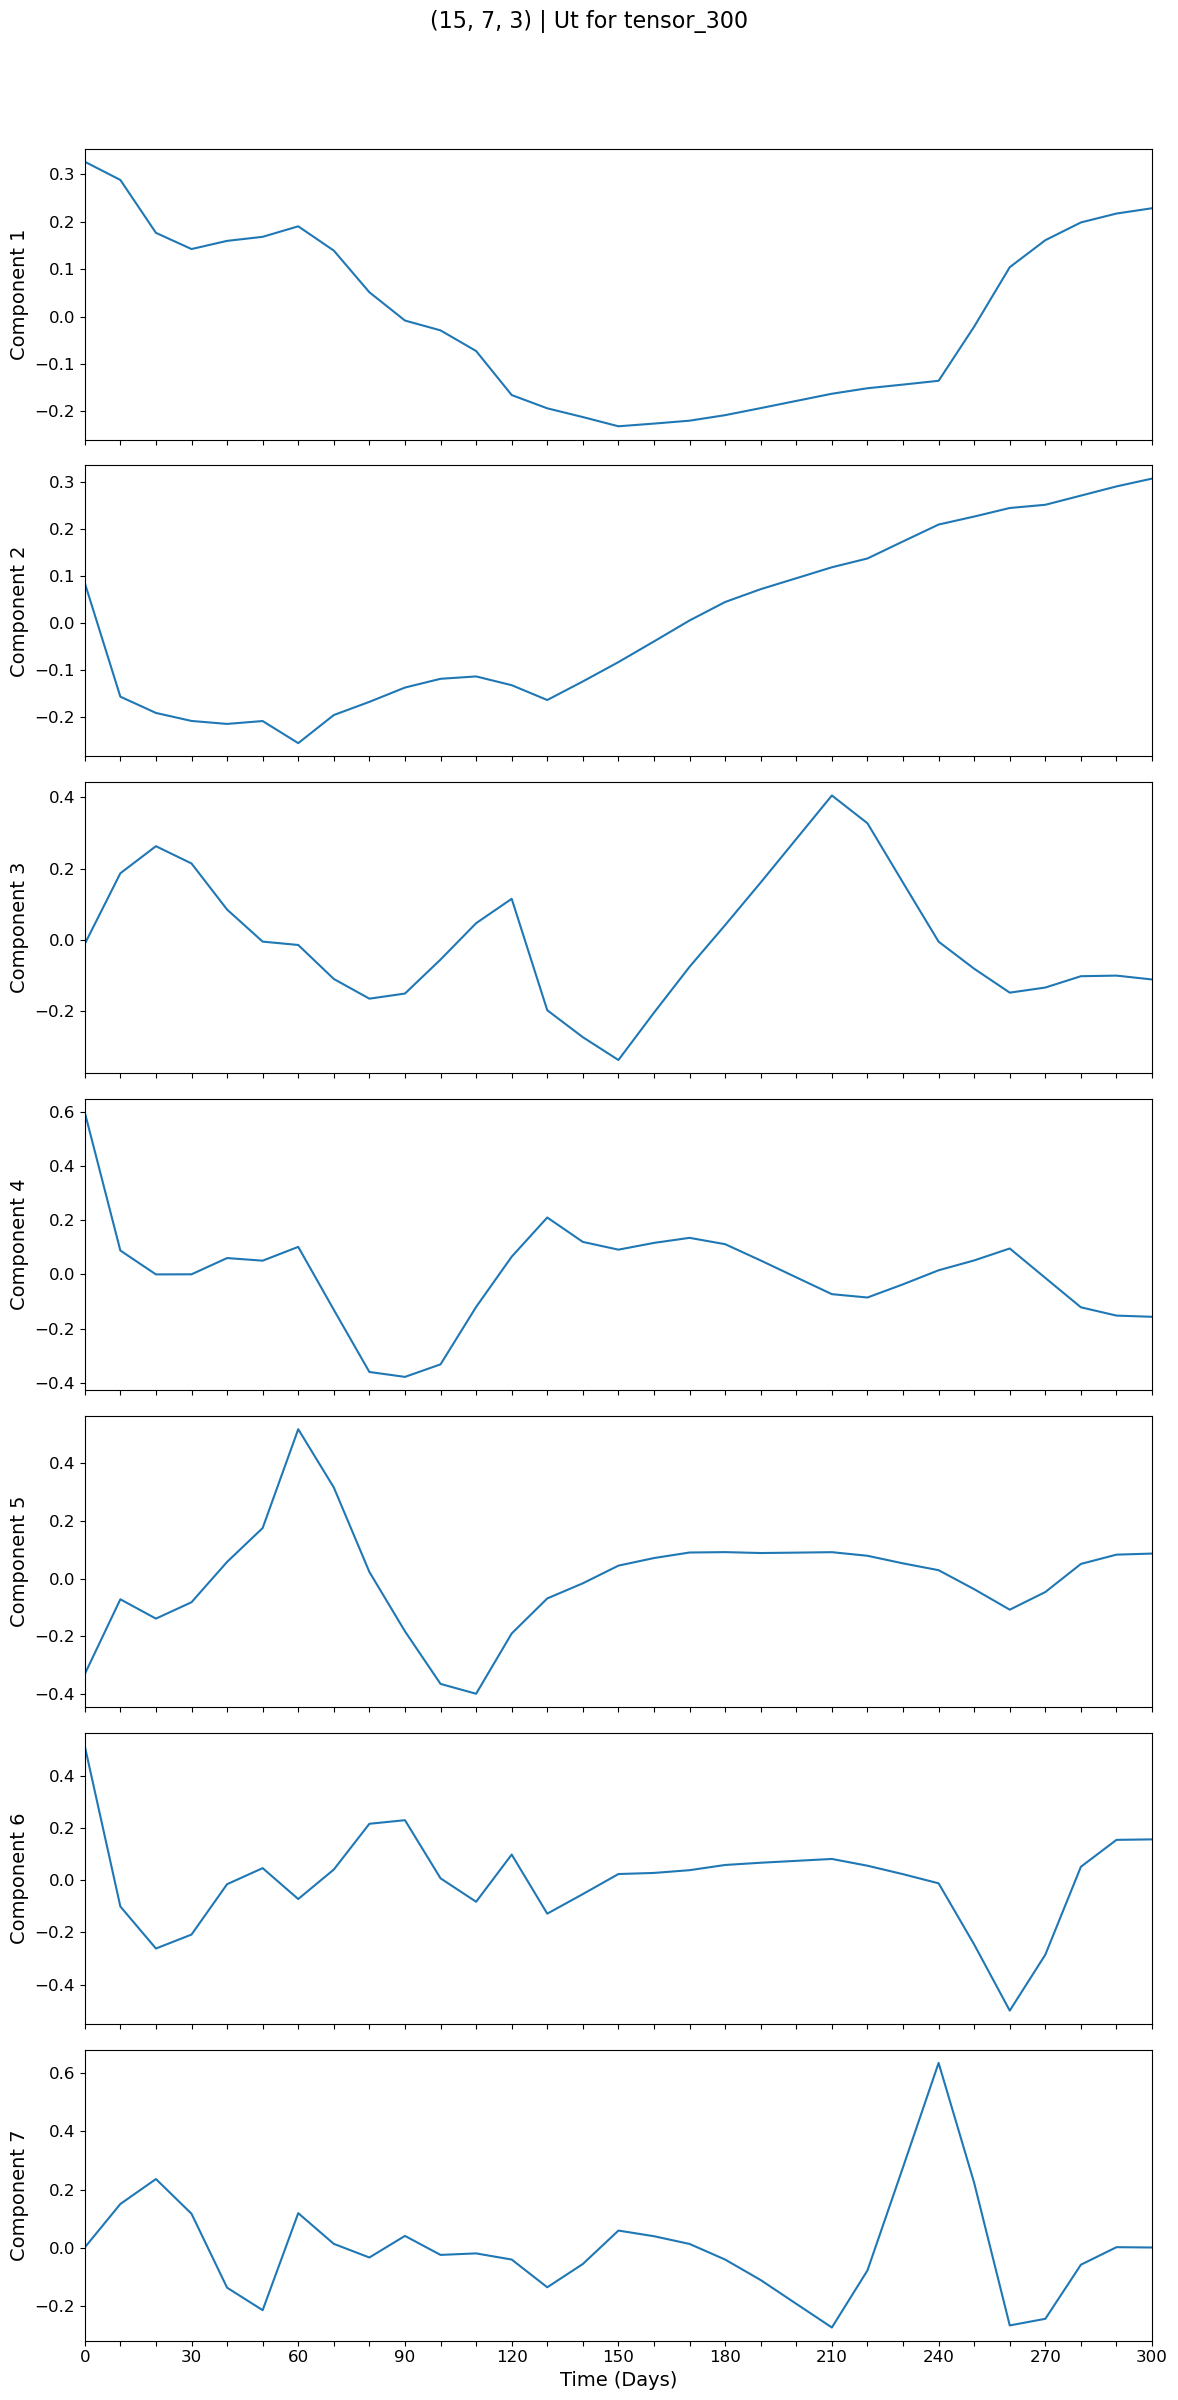

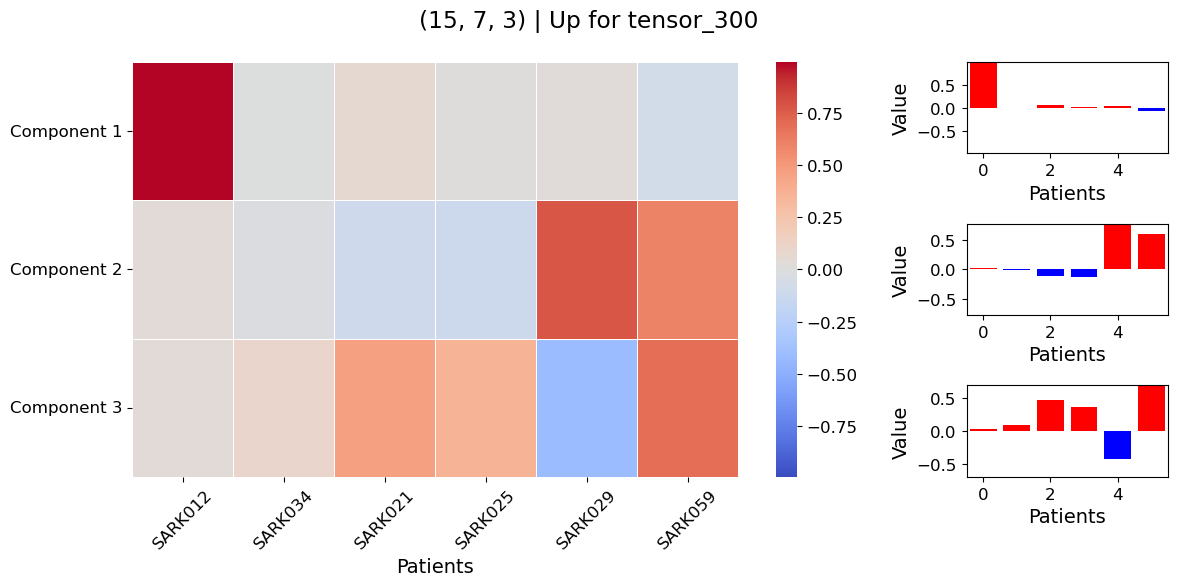

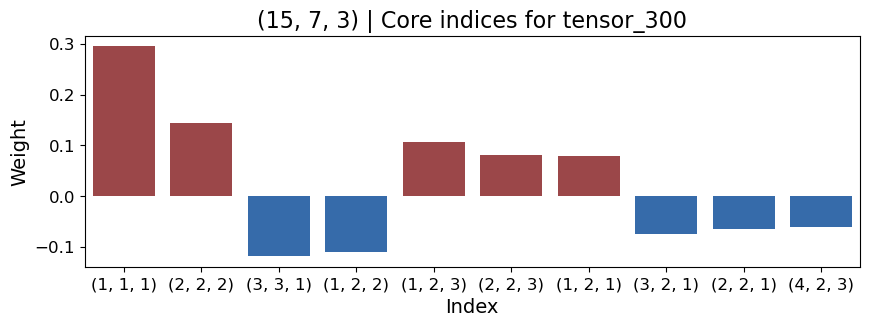


 Plotting cent_tensor_300 with ranks (8, 6, 4)


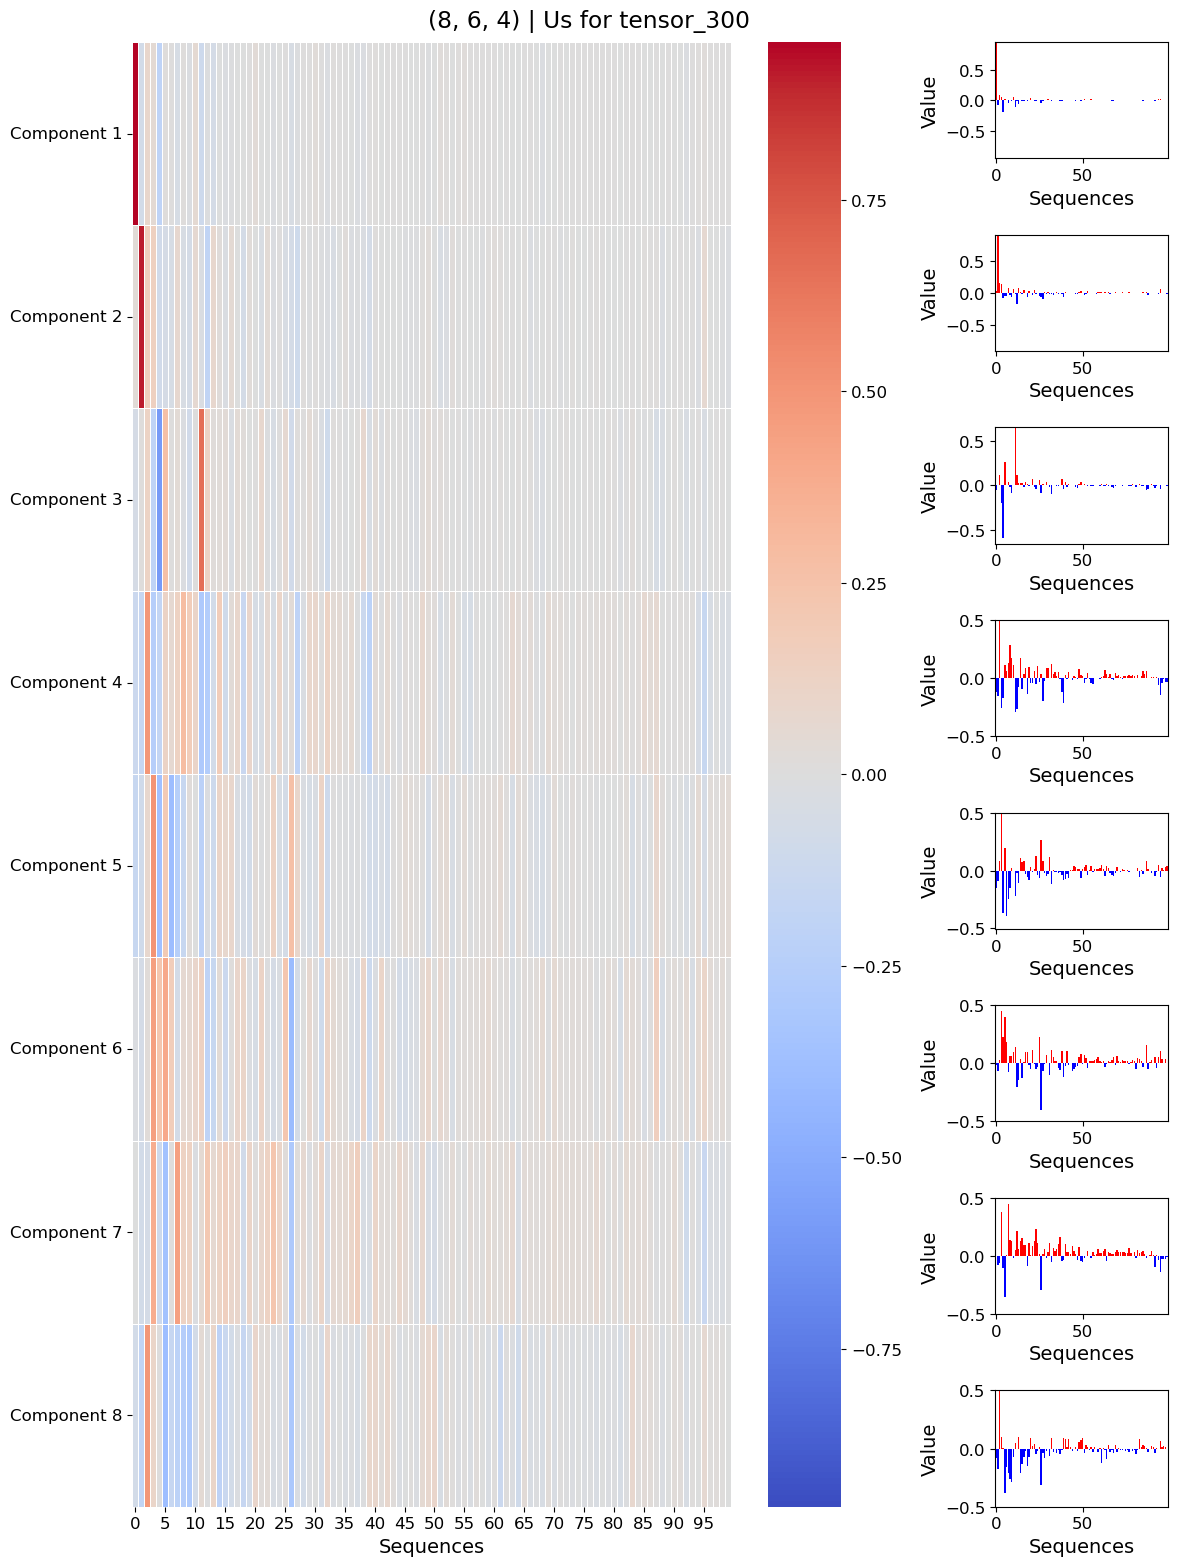

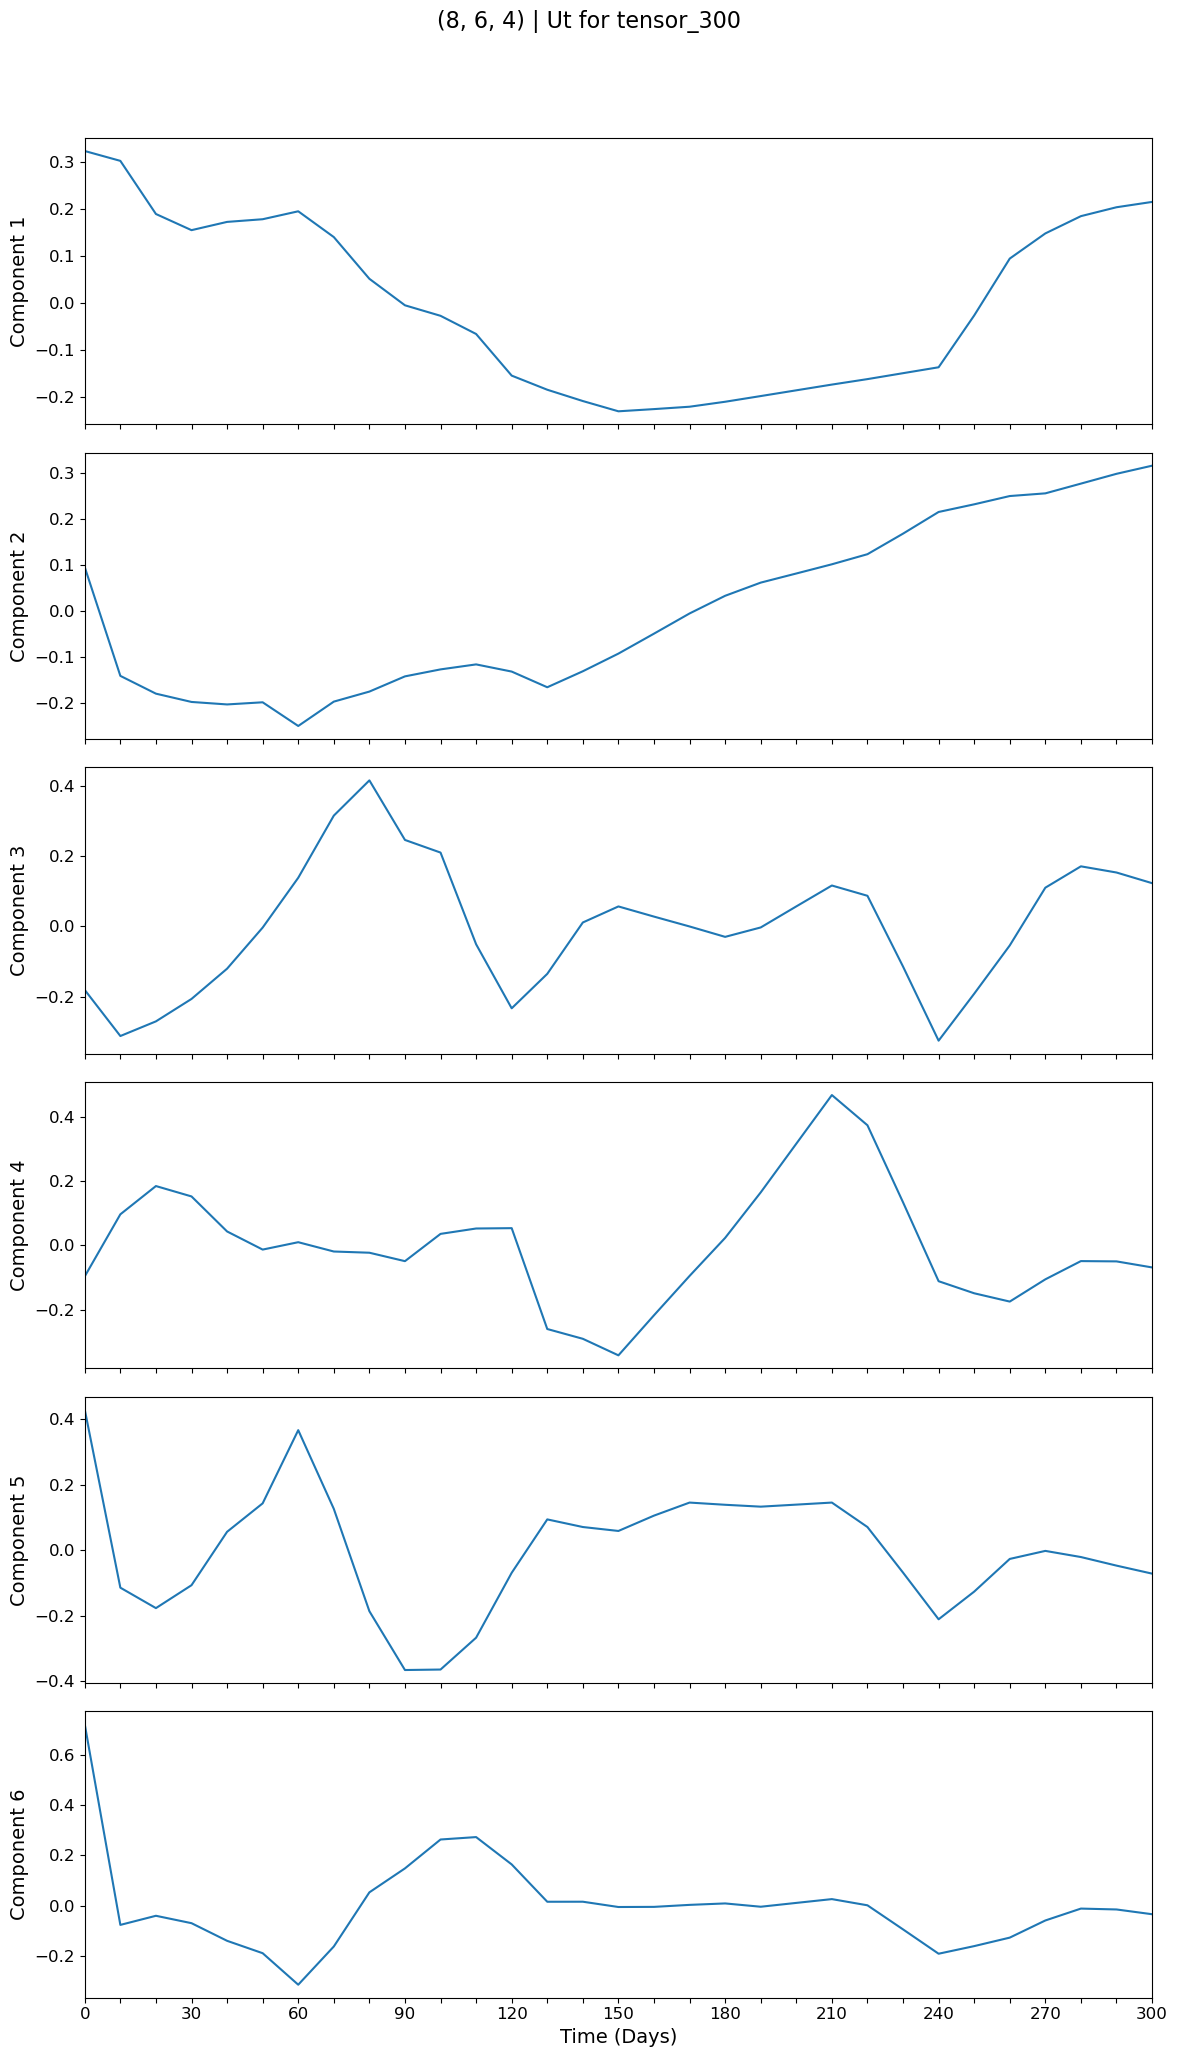

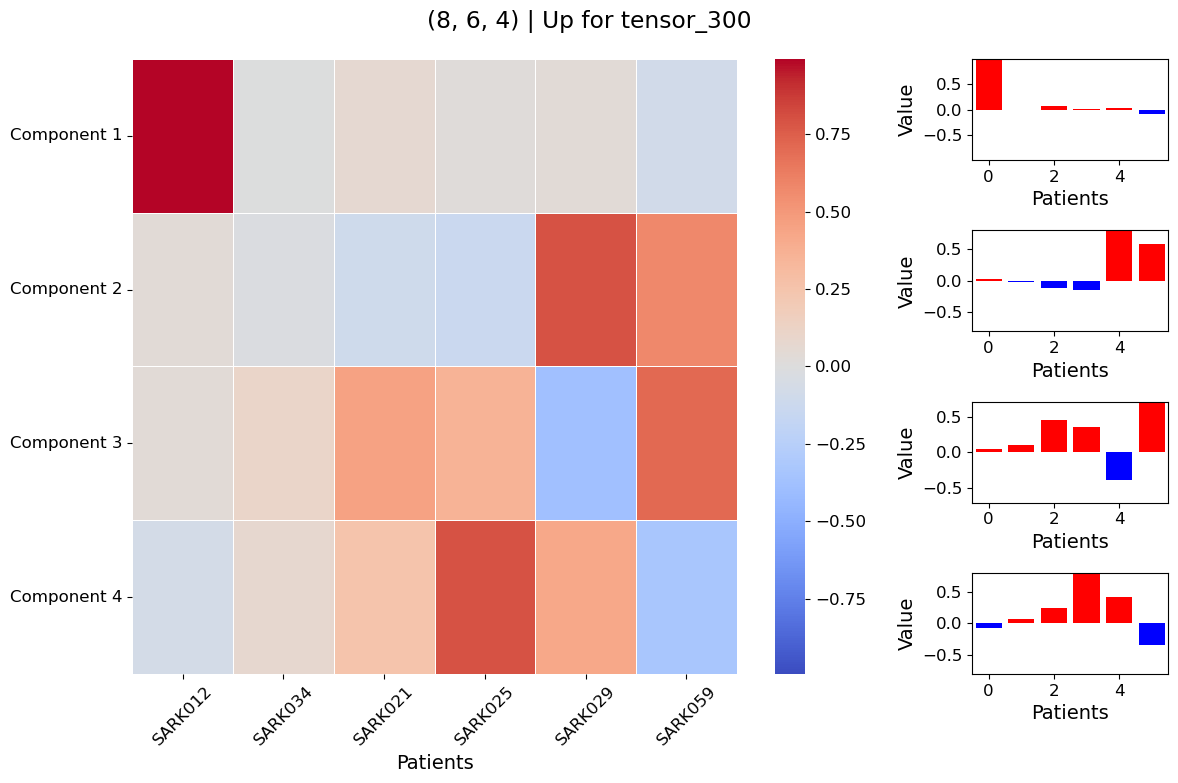

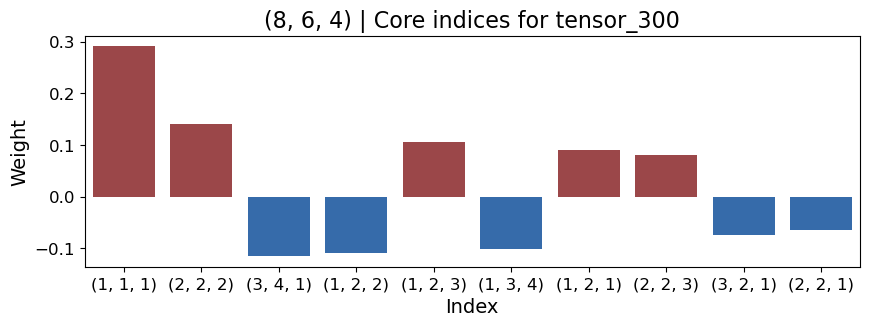

In [24]:
pat_list = ['SARK012', 'SARK034', 'SARK021', 'SARK025', 
            'SARK029', 'SARK059']
tensor_name = "tensor_300"
type_name = "cent" 
plot_all_rank_decompositions(tensor_name, type_name, tucker_results, pat_list)